# Отток клиентов Ниединогоразрыва.ком

## Изучение общей информации о данных

In [1]:
pip install skimpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
#импортирование библиотек

import pandas as pd
import numpy as np
import sklearn
from skimpy import clean_columns
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score
from catboost.utils import get_roc_curve
from sklearn import metrics
from catboost.utils import get_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [4]:
#загрузка данных

#информация о договоре
contract = pd.read_csv('/datasets/contract_new.csv')

#персональные данные клиента
personal = pd.read_csv('/datasets/personal_new.csv')

#информация об интернет-услугах
internet = pd.read_csv('/datasets/internet_new.csv')

#информация об услугах телефонии
phone = pd.read_csv('/datasets/phone_new.csv')

In [5]:
#переменная-констатнта для даты выгрузки

date_of_unloading = pd.to_datetime('2020-02-01')

In [6]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

In [7]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [8]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [9]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Получили первый взгляд на данные. В предоставленных данных нет пропущенных значений, выборки разного размера - phone и internet меньше

## Предобработка данных

In [10]:
#приведение названий признаков к стилю snake

contract = clean_columns(contract)
personal = clean_columns(personal)
internet = clean_columns(internet)
phone = clean_columns(phone)

8 column names have been cleaned

4 column names have been cleaned

8 column names have been cleaned

2 column names have been cleaned

In [11]:
#проверка на явные дубликаты

print(contract.duplicated().sum())
print(personal.duplicated().sum())
print(internet.duplicated().sum())
print(phone.duplicated().sum())

0
0
0
0


In [12]:
#просмотр столбца total_charges со строковыми значениями

contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='ignore')
contract.loc[contract['total_charges'].str.isspace()]

customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check            20.25                
936                Mailed check            80.85                
1082               Mailed check            25.75                
1340    Credit card (automatic)            56.05                
3331               Mailed check            19.85                
3826               Mailed check            25.35                
4380               Mailed check            20.00                
5218               Mailed check            19.70                
6670               Mailed check            73.35                
6754  Bank transfer (automatic)            61.90

В столбце total_charges существуют скрытые пропуски обозначенные пробелом у клиентов, договор которых открыт числом выгрузки данных. Поэтому эти значения заполним значением monthly_charges

In [13]:
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges'])

In [14]:
#создание целевого признака, где 1 отмечены ушедшие клиенты

contract['gone'] = contract['end_date'] != 'No'
contract['gone'] = contract['gone'].astype('int64')

In [15]:
#преобразование в формат даты begin_date

contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')

Чтобы вычислить количество дней от старта договора, заменяю значение 'no' в end_date на дату выгрузки. После вычисления разности, столбец begin_date удаляется за ненадобностью, столбец end_date удаляется во избежание утечки целевого признака

In [16]:
#замена значений 'no' для последующих вычислений

contract['end_date'] = contract['end_date'].replace(['No'], date_of_unloading)

#преобразование в формат даты end_date 

contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

In [17]:
#создание переменной с количеством дней пользования услугами

contract['duration'] = contract['end_date'] - contract['begin_date']
contract['duration'] = contract['duration'].dt.days

# Итоги I этапа

1. Загружены данные. Обнаружено, что выборки phone и internet меньшего размера. Не обнаружены пропуски и дубликаты.
2. Устранены пробелы в данных о новых клиентах в признаке "всего потрачено на услуги".
3. Создан признак, явно указывающий на клиентов, расторгнувших договор.
4. Создан признак, указывающий на количество дней пользования услугами по договору.
5. Типы данных приведены к соответстсвующим.

In [18]:
#объединение таблиц 

df = contract.merge(personal, on='customer_id', how='left') 
df = df.merge(internet, on='customer_id', how='left')
df = df.merge(phone, on='customer_id', how='left')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gone               7043 non-null   int64         
 9   duration           7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   int64         
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Пропуски, обусловленные тем, что часть клиентов не подключала интернет или телефон, заменяем на 'No'. Для однородности данных и экономии памяти заменяем тип данных у бинарных признаков со значениями да и нет.

In [20]:
df = df.fillna('No')

In [21]:
#смена типа данных

columns = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
df[columns] = df[columns].replace(['No'], 0).replace(['Yes'], 1)

In [22]:
#удаление ненужных столбцов

df = df.drop(columns=['begin_date', 'end_date', 'customer_id'])

## Проведение EDA анализа

In [23]:
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

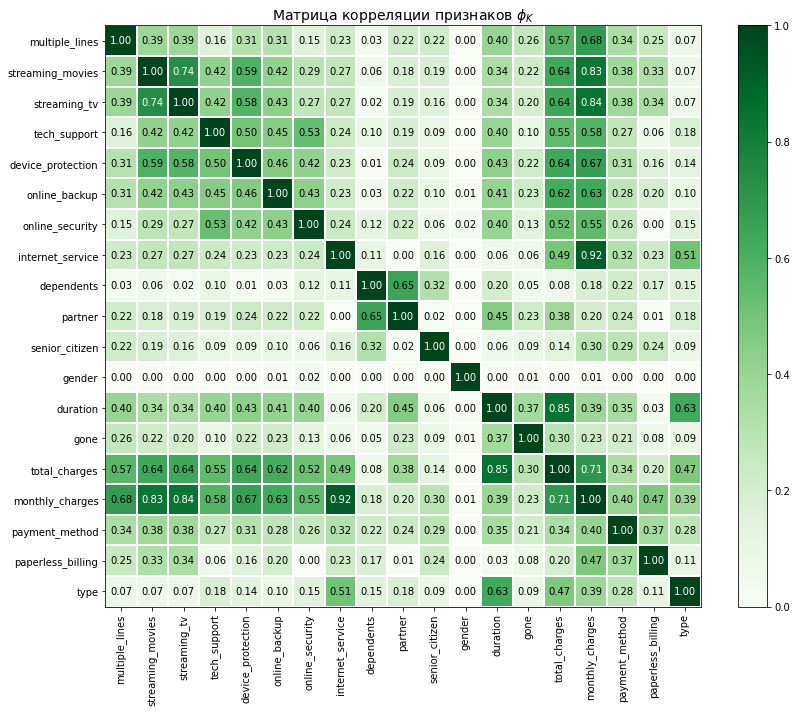

In [24]:
interval_cols = ['monthly_charges', 'total_charges', 'duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.round(2).values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляции признаков $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 10))
plt.tight_layout()

Можно заметить, что существует сильная зависимость между расходами за месяц, интернет сервисом и подключенными услугами. Признак пола почти совсем не значим, в том числе и на целевой признак. У целевого признака нет выраженной зависимости с какими-либо признаками - максимальный коэффициент с количеством дней от начала договора - 0.37

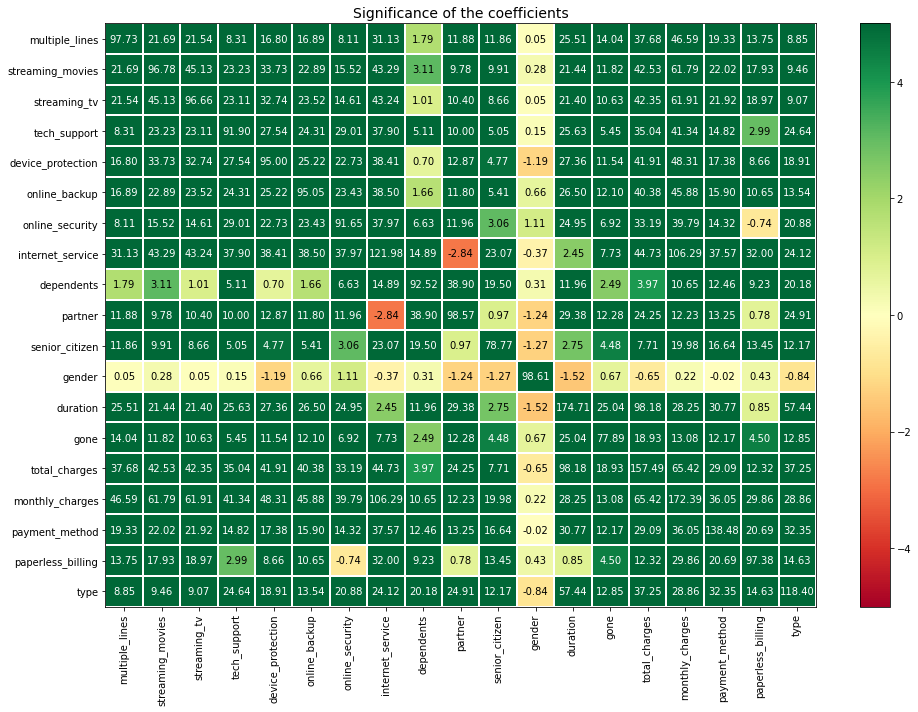

In [25]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(14, 10))
plt.tight_layout()

Матрица статистической значимости подтверждает выводы о присутствии мультиколлинеарности. Это нужно было бы иметь в виду при построении линейной модели.

Text(0.5, 1.0, 'Распределения значений признаков')

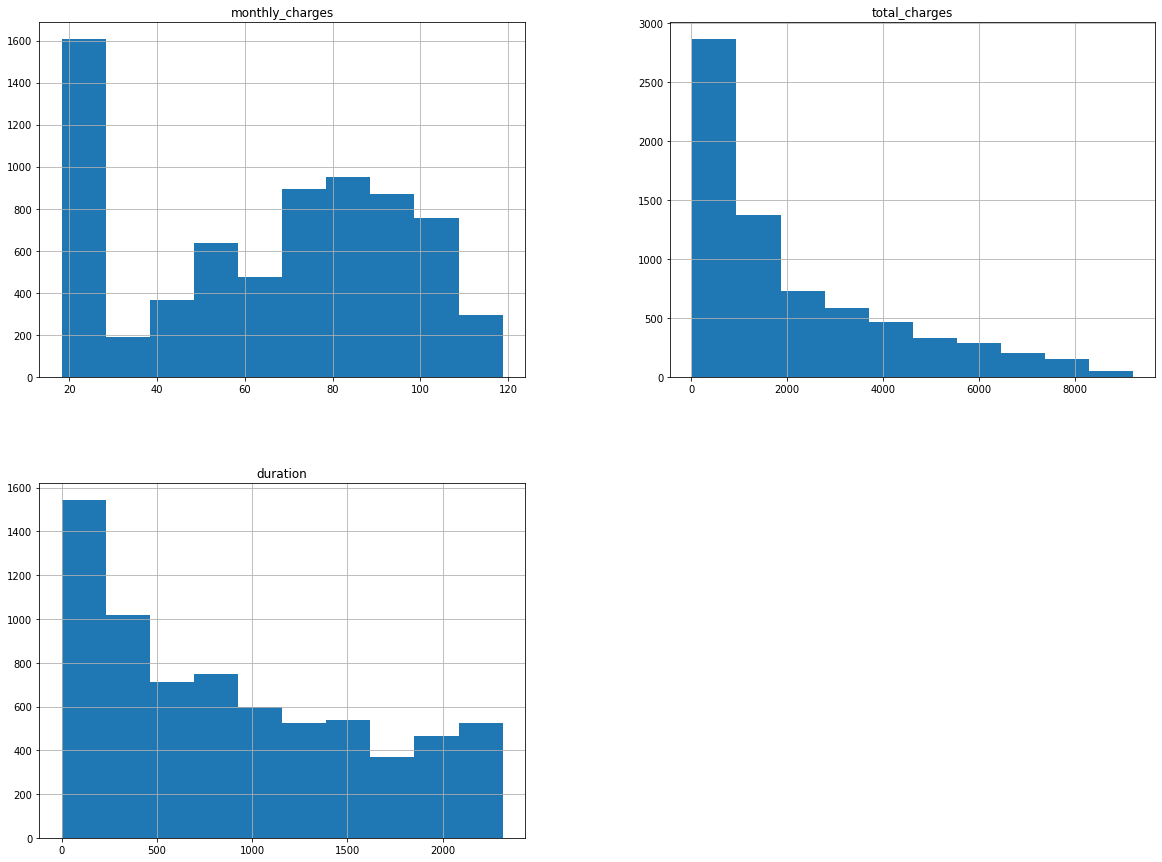

In [26]:
df[interval_cols].hist(figsize=(20, 15));
plt.title('Распределения значений признаков')

<Figure size 432x288 with 0 Axes>

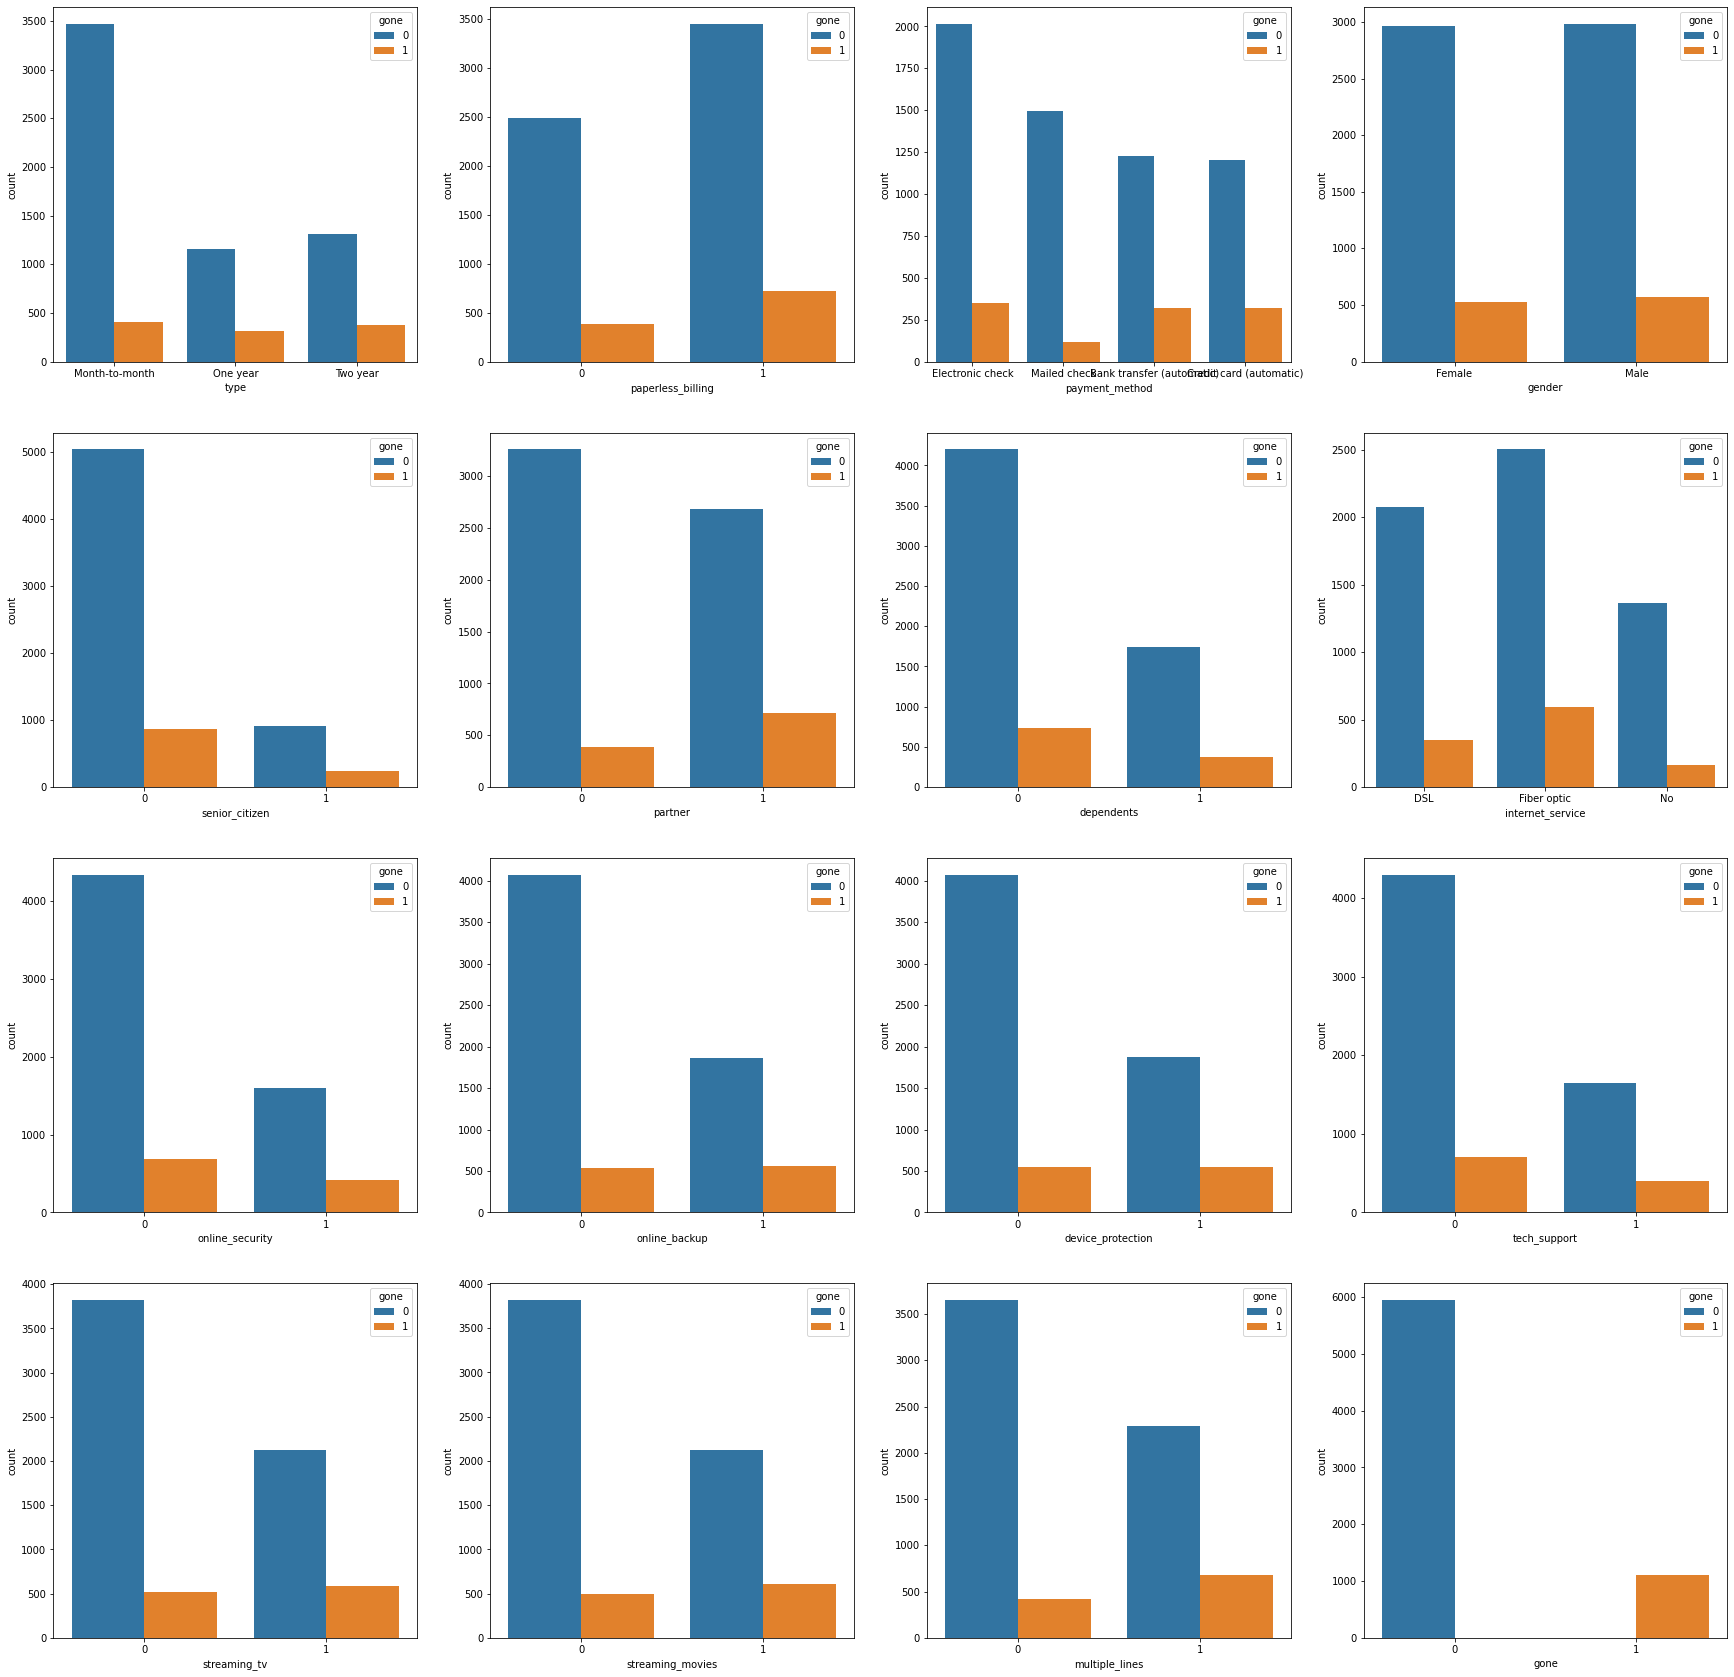

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
cats =  ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'gone']

#параметры для функции subplots

fig, axes = plt.subplots(4, 4, figsize=(30, 30))
axe = axes.ravel()

#построение графиков для категориальных переменных

for i, col in enumerate(df[cats].columns):
    plt.figure(i)
    sns.countplot(x=col, data=df, hue='gone', ax=axe[i])

# Выводы по визуальному анализу  

Можно заметить дисбаланс классов в целевом признаке - в выборке закрыли договор около 15 процентов клиентов.  

Больше половины клиентов договор заключают на месяц. Процент ушедших клиентов в этой категории меньше, чем среди договоров на год и на два. Но нужно принять во внимание, что это возможно потому, что пользуются услугами меньше года - большое количество новых клиентов, по истечению этого срока возможно договор закроют.    

В процентом соотношении ушедших меньше среди тех, кто получают электронный чек и чек на почту относительно двух других категорий.   

Чаще закрывают договор те, у кого есть партнер.  

Больше 20-ти % не подключают интернет. Это не влияет на отток клиентов, как и тип используемого оптического волокна.  

Каждую доп услугу подключает примерно треть клиентов. При этом среди тех кто подключил - ушедших столько же.  

Подключающих многоканальную телефонию на треть меньше, но ушедших среди них больше.   

Четверть клиентов платит минимальную сумму в месяц - до 30 ден. ед.  

Больше полутора тысяч новых клиентов - они пользуются услугами меньше полугода, это сказывается на общих тратах по клиенту.

## Построение модели обучения

In [28]:
#выделение целевого признака

target = df['gone']
features = df.drop('gone', axis=1)

#выделение тренировочной части в соотношении 75% и 25%
fea_train, fea_test, tar_train, tar_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=220523)

print(fea_train.shape)
print(fea_test.shape)
print(tar_train.shape)
print(tar_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [29]:
# порядковое кодирование для модели случайного леса

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

cat_features =  ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner',
'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection',
'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

encoder.fit(fea_train[cat_features])

fea_train_ord = fea_train.copy()
fea_test_ord = fea_test.copy()

fea_train_ord[cat_features] = encoder.transform(fea_train_ord[cat_features])
fea_test_ord[cat_features] = encoder.transform(fea_test_ord[cat_features])

In [30]:
#словарь с параметрами для модели случайного леса

parametrs = { 'max_depth': range (2, 16, 2),
              'n_estimators': range (1, 200, 10) }

In [31]:
model1 = RandomForestClassifier(random_state=220523)

#подбор параметров модели 

grid = GridSearchCV(model1, parametrs, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(fea_train_ord, tar_train)
print('Лучшие параметры для RandomForestClassifier', grid.best_params_)
print('Метрика roc_auc', grid.best_score_)

Лучшие параметры для RandomForestClassifier {'max_depth': 8, 'n_estimators': 111}
Метрика roc_auc 0.8330857798282054


Показатель 0.83 меньше требуемого 0.85, обучим другую модель

In [32]:
#словарь с параметрами для модели catboost

parameters = {'depth'         : [4,5,6,7,8,9,10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [1000]
                 }

In [33]:
model2 = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, random_seed=220523)

#подбор параметров модели

grid_cbc = GridSearchCV(model2, parameters, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0);
grid_cbc.fit(fea_train, tar_train)
print('Лучшие параметры для CatBoostClassifier', grid_cbc.best_params_)
print('Метрика roc_auc', grid_cbc.best_score_)

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 52.4ms	remaining: 52.3s
1:	total: 57.4ms	remaining: 28.6s
2:	total: 61.7ms	remaining: 20.5s
3:	total: 66.7ms	remaining: 16.6s
4:	total: 70.3ms	remaining: 14s
5:	total: 74.9ms	remaining: 12.4s
6:	total: 79.3ms	remaining: 11.3s
7:	total: 83.7ms	remaining: 10.4s
8:	total: 88ms	remaining: 9.69s
9:	total: 92.4ms	remaining: 9.15s
10:	total: 96.9ms	remaining: 8.71s
11:	total: 101ms	remaining: 8.32s
12:	total: 105ms	remaining: 7.99s
13:	total: 109ms	remaining: 7.68s
14:	total: 113ms	remaining: 7.45s
15:	total: 118ms	remaining: 7.23s
16:	total: 122ms	remaining: 7.05s
17:	total: 127ms	remaining: 6.9s
18:	total: 131ms	remaining: 6.75s
19:	total: 135ms	remaining: 6.61s
20:	total: 139ms	remaining: 6.49s
21:	total: 144ms	remaining: 6.38s
22:	total: 148ms	remaining: 6.3s
23:	total: 152ms	remaining: 6.19s
24:	total: 156ms	remaining: 6.09s
25:	total: 160ms	remaining: 6.01s
26:	total: 164ms	remaining: 5.93s
27:	total: 168ms	remaining: 5.84s
28:	total: 173ms	remaining: 5.78s
29:	total: 177ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.87ms	remaining: 4.87s
1:	total: 9.63ms	remaining: 4.8s
2:	total: 14.4ms	remaining: 4.78s
3:	total: 18.6ms	remaining: 4.63s
4:	total: 23.2ms	remaining: 4.61s
5:	total: 27.6ms	remaining: 4.56s
6:	total: 31.8ms	remaining: 4.5s
7:	total: 34.3ms	remaining: 4.25s
8:	total: 38.2ms	remaining: 4.21s
9:	total: 41.1ms	remaining: 4.06s
10:	total: 44.7ms	remaining: 4.02s
11:	total: 49ms	remaining: 4.03s
12:	total: 52.9ms	remaining: 4.02s
13:	total: 56ms	remaining: 3.94s
14:	total: 59.9ms	remaining: 3.93s
15:	total: 63ms	remaining: 3.88s
16:	total: 67.6ms	remaining: 3.91s
17:	total: 71.7ms	remaining: 3.91s
18:	total: 75.9ms	remaining: 3.92s
19:	total: 80ms	remaining: 3.92s
20:	total: 84.1ms	remaining: 3.92s
21:	total: 88.1ms	remaining: 3.92s
22:	total: 92ms	remaining: 3.91s
23:	total: 95.9ms	remaining: 3.9s
24:	total: 99.7ms	remaining: 3.89s
25:	total: 104ms	remaining: 3.88s
26:	total: 107ms	remaining: 3.86s
27:	total: 111ms	remaining: 3.86s
28:	total: 115ms	remaining: 3.87s
29:	total: 1

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.62ms	remaining: 4.62s
1:	total: 8.89ms	remaining: 4.44s
2:	total: 13ms	remaining: 4.32s
3:	total: 17ms	remaining: 4.22s
4:	total: 21.1ms	remaining: 4.19s
5:	total: 25.2ms	remaining: 4.17s
6:	total: 29.2ms	remaining: 4.14s
7:	total: 33.3ms	remaining: 4.13s
8:	total: 37.2ms	remaining: 4.09s
9:	total: 41.3ms	remaining: 4.09s
10:	total: 45.2ms	remaining: 4.07s
11:	total: 49.3ms	remaining: 4.06s
12:	total: 53.3ms	remaining: 4.05s
13:	total: 55.9ms	remaining: 3.93s
14:	total: 57.9ms	remaining: 3.8s
15:	total: 62ms	remaining: 3.82s
16:	total: 64.2ms	remaining: 3.71s
17:	total: 68.1ms	remaining: 3.71s
18:	total: 71.8ms	remaining: 3.71s
19:	total: 75.9ms	remaining: 3.72s
20:	total: 78.7ms	remaining: 3.67s
21:	total: 81.3ms	remaining: 3.61s
22:	total: 84.2ms	remaining: 3.58s
23:	total: 88.3ms	remaining: 3.59s
24:	total: 91.9ms	remaining: 3.58s
25:	total: 94.3ms	remaining: 3.53s
26:	total: 98.2ms	remaining: 3.54s
27:	total: 102ms	remaining: 3.54s
28:	total: 105ms	remaining: 3.51s
29:	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.68ms	remaining: 4.68s
1:	total: 8.38ms	remaining: 4.18s
2:	total: 13.3ms	remaining: 4.41s
3:	total: 17.4ms	remaining: 4.32s
4:	total: 22.2ms	remaining: 4.42s
5:	total: 27.1ms	remaining: 4.5s
6:	total: 31.2ms	remaining: 4.43s
7:	total: 35.1ms	remaining: 4.35s
8:	total: 39.2ms	remaining: 4.31s
9:	total: 43.2ms	remaining: 4.28s
10:	total: 47.2ms	remaining: 4.25s
11:	total: 51.2ms	remaining: 4.21s
12:	total: 55.8ms	remaining: 4.24s
13:	total: 60.1ms	remaining: 4.24s
14:	total: 64.4ms	remaining: 4.23s
15:	total: 68.4ms	remaining: 4.21s
16:	total: 72.5ms	remaining: 4.2s
17:	total: 75.9ms	remaining: 4.14s
18:	total: 80ms	remaining: 4.13s
19:	total: 83.7ms	remaining: 4.1s
20:	total: 88.3ms	remaining: 4.12s
21:	total: 92.6ms	remaining: 4.11s
22:	total: 96.6ms	remaining: 4.11s
23:	total: 101ms	remaining: 4.1s
24:	total: 105ms	remaining: 4.09s
25:	total: 109ms	remaining: 4.09s
26:	total: 114ms	remaining: 4.09s
27:	total: 118ms	remaining: 4.08s
28:	total: 122ms	remaining: 4.09s
29:	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.8ms	remaining: 4.79s
1:	total: 9.78ms	remaining: 4.88s
2:	total: 13.9ms	remaining: 4.63s
3:	total: 18.1ms	remaining: 4.51s
4:	total: 22.3ms	remaining: 4.45s
5:	total: 26.1ms	remaining: 4.33s
6:	total: 30.3ms	remaining: 4.29s
7:	total: 34.2ms	remaining: 4.24s
8:	total: 38.2ms	remaining: 4.2s
9:	total: 42.3ms	remaining: 4.18s
10:	total: 46.3ms	remaining: 4.16s
11:	total: 50.3ms	remaining: 4.14s
12:	total: 54.1ms	remaining: 4.11s
13:	total: 58ms	remaining: 4.09s
14:	total: 62.3ms	remaining: 4.09s
15:	total: 66.3ms	remaining: 4.08s
16:	total: 70.1ms	remaining: 4.05s
17:	total: 73.8ms	remaining: 4.02s
18:	total: 77.5ms	remaining: 4s
19:	total: 81.3ms	remaining: 3.98s
20:	total: 85.3ms	remaining: 3.98s
21:	total: 89.1ms	remaining: 3.96s
22:	total: 92.7ms	remaining: 3.94s
23:	total: 96.6ms	remaining: 3.93s
24:	total: 100ms	remaining: 3.92s
25:	total: 104ms	remaining: 3.9s
26:	total: 108ms	remaining: 3.89s
27:	total: 112ms	remaining: 3.88s
28:	total: 116ms	remaining: 3.88s
29:	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.92ms	remaining: 4.92s
1:	total: 9.81ms	remaining: 4.89s
2:	total: 16.4ms	remaining: 5.45s
3:	total: 20.8ms	remaining: 5.19s
4:	total: 25.4ms	remaining: 5.05s
5:	total: 29.9ms	remaining: 4.96s
6:	total: 34.4ms	remaining: 4.88s
7:	total: 39ms	remaining: 4.83s
8:	total: 43.5ms	remaining: 4.79s
9:	total: 47.8ms	remaining: 4.74s
10:	total: 52ms	remaining: 4.68s
11:	total: 56.9ms	remaining: 4.68s
12:	total: 59.5ms	remaining: 4.52s
13:	total: 63.7ms	remaining: 4.49s
14:	total: 68.2ms	remaining: 4.48s
15:	total: 72.8ms	remaining: 4.48s
16:	total: 77.4ms	remaining: 4.47s
17:	total: 82ms	remaining: 4.48s
18:	total: 86.8ms	remaining: 4.48s
19:	total: 91.4ms	remaining: 4.48s
20:	total: 96.1ms	remaining: 4.48s
21:	total: 100ms	remaining: 4.47s
22:	total: 105ms	remaining: 4.47s
23:	total: 110ms	remaining: 4.46s
24:	total: 114ms	remaining: 4.46s
25:	total: 119ms	remaining: 4.45s
26:	total: 122ms	remaining: 4.41s
27:	total: 127ms	remaining: 4.4s
28:	total: 132ms	remaining: 4.41s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.72ms	remaining: 4.72s
1:	total: 8.94ms	remaining: 4.46s
2:	total: 13.5ms	remaining: 4.5s
3:	total: 17.8ms	remaining: 4.43s
4:	total: 22.1ms	remaining: 4.39s
5:	total: 26ms	remaining: 4.31s
6:	total: 30.7ms	remaining: 4.36s
7:	total: 34ms	remaining: 4.22s
8:	total: 39.9ms	remaining: 4.39s
9:	total: 43.9ms	remaining: 4.34s
10:	total: 47.9ms	remaining: 4.3s
11:	total: 50.8ms	remaining: 4.18s
12:	total: 55.1ms	remaining: 4.18s
13:	total: 60.2ms	remaining: 4.24s
14:	total: 64.9ms	remaining: 4.26s
15:	total: 69.5ms	remaining: 4.27s
16:	total: 75.3ms	remaining: 4.36s
17:	total: 81.1ms	remaining: 4.42s
18:	total: 85.8ms	remaining: 4.43s
19:	total: 91.1ms	remaining: 4.46s
20:	total: 95.5ms	remaining: 4.45s
21:	total: 101ms	remaining: 4.47s
22:	total: 105ms	remaining: 4.45s
23:	total: 109ms	remaining: 4.43s
24:	total: 113ms	remaining: 4.42s
25:	total: 117ms	remaining: 4.4s
26:	total: 122ms	remaining: 4.4s
27:	total: 125ms	remaining: 4.35s
28:	total: 130ms	remaining: 4.35s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.91ms	remaining: 4.9s
1:	total: 9.52ms	remaining: 4.75s
2:	total: 13.9ms	remaining: 4.62s
3:	total: 18.1ms	remaining: 4.5s
4:	total: 22.4ms	remaining: 4.46s
5:	total: 26.7ms	remaining: 4.42s
6:	total: 31.7ms	remaining: 4.49s
7:	total: 36.5ms	remaining: 4.53s
8:	total: 40.7ms	remaining: 4.48s
9:	total: 44.8ms	remaining: 4.44s
10:	total: 48.6ms	remaining: 4.37s
11:	total: 52.8ms	remaining: 4.34s
12:	total: 56.7ms	remaining: 4.31s
13:	total: 61.5ms	remaining: 4.33s
14:	total: 65.8ms	remaining: 4.32s
15:	total: 70.1ms	remaining: 4.31s
16:	total: 74.7ms	remaining: 4.32s
17:	total: 79.4ms	remaining: 4.33s
18:	total: 84ms	remaining: 4.34s
19:	total: 88.2ms	remaining: 4.32s
20:	total: 93ms	remaining: 4.34s
21:	total: 97ms	remaining: 4.31s
22:	total: 101ms	remaining: 4.3s
23:	total: 106ms	remaining: 4.31s
24:	total: 113ms	remaining: 4.4s
25:	total: 121ms	remaining: 4.51s
26:	total: 128ms	remaining: 4.6s
27:	total: 135ms	remaining: 4.68s
28:	total: 140ms	remaining: 4.68s
29:	total: 14

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.96ms	remaining: 4.95s
1:	total: 8.66ms	remaining: 4.32s
2:	total: 13.6ms	remaining: 4.53s
3:	total: 17.7ms	remaining: 4.4s
4:	total: 22.3ms	remaining: 4.43s
5:	total: 26.5ms	remaining: 4.38s
6:	total: 30.7ms	remaining: 4.36s
7:	total: 35ms	remaining: 4.34s
8:	total: 39.4ms	remaining: 4.33s
9:	total: 43.8ms	remaining: 4.34s
10:	total: 48ms	remaining: 4.31s
11:	total: 52.6ms	remaining: 4.33s
12:	total: 56.8ms	remaining: 4.31s
13:	total: 60.9ms	remaining: 4.29s
14:	total: 65.1ms	remaining: 4.28s
15:	total: 69.5ms	remaining: 4.27s
16:	total: 73.9ms	remaining: 4.27s
17:	total: 78.1ms	remaining: 4.26s
18:	total: 80.8ms	remaining: 4.17s
19:	total: 85ms	remaining: 4.16s
20:	total: 88.9ms	remaining: 4.14s
21:	total: 93ms	remaining: 4.13s
22:	total: 96.2ms	remaining: 4.09s
23:	total: 99.9ms	remaining: 4.06s
24:	total: 104ms	remaining: 4.06s
25:	total: 109ms	remaining: 4.07s
26:	total: 113ms	remaining: 4.06s
27:	total: 117ms	remaining: 4.05s
28:	total: 121ms	remaining: 4.07s
29:	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.03ms	remaining: 5.03s
1:	total: 9.52ms	remaining: 4.75s
2:	total: 13.9ms	remaining: 4.63s
3:	total: 18.7ms	remaining: 4.65s
4:	total: 23ms	remaining: 4.58s
5:	total: 27.9ms	remaining: 4.62s
6:	total: 32.8ms	remaining: 4.65s
7:	total: 37.6ms	remaining: 4.66s
8:	total: 42.2ms	remaining: 4.65s
9:	total: 45.4ms	remaining: 4.5s
10:	total: 50.1ms	remaining: 4.5s
11:	total: 54.3ms	remaining: 4.47s
12:	total: 59.3ms	remaining: 4.5s
13:	total: 63.1ms	remaining: 4.45s
14:	total: 68.1ms	remaining: 4.47s
15:	total: 72.8ms	remaining: 4.48s
16:	total: 77.2ms	remaining: 4.46s
17:	total: 82ms	remaining: 4.47s
18:	total: 86.6ms	remaining: 4.47s
19:	total: 88.9ms	remaining: 4.36s
20:	total: 93.2ms	remaining: 4.34s
21:	total: 97.6ms	remaining: 4.34s
22:	total: 102ms	remaining: 4.35s
23:	total: 107ms	remaining: 4.36s
24:	total: 111ms	remaining: 4.35s
25:	total: 116ms	remaining: 4.35s
26:	total: 121ms	remaining: 4.37s
27:	total: 126ms	remaining: 4.39s
28:	total: 131ms	remaining: 4.4s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.78ms	remaining: 4.78s
1:	total: 9.46ms	remaining: 4.72s
2:	total: 13.7ms	remaining: 4.56s
3:	total: 18ms	remaining: 4.48s
4:	total: 21.6ms	remaining: 4.29s
5:	total: 25.6ms	remaining: 4.24s
6:	total: 29.6ms	remaining: 4.2s
7:	total: 33.4ms	remaining: 4.14s
8:	total: 36.9ms	remaining: 4.06s
9:	total: 41.1ms	remaining: 4.07s
10:	total: 44.9ms	remaining: 4.04s
11:	total: 48.7ms	remaining: 4.01s
12:	total: 52.1ms	remaining: 3.96s
13:	total: 55.9ms	remaining: 3.94s
14:	total: 60.1ms	remaining: 3.94s
15:	total: 64.3ms	remaining: 3.96s
16:	total: 66.4ms	remaining: 3.84s
17:	total: 70.7ms	remaining: 3.86s
18:	total: 75ms	remaining: 3.87s
19:	total: 79.3ms	remaining: 3.88s
20:	total: 83.4ms	remaining: 3.89s
21:	total: 87.8ms	remaining: 3.9s
22:	total: 92.6ms	remaining: 3.93s
23:	total: 96.7ms	remaining: 3.93s
24:	total: 101ms	remaining: 3.92s
25:	total: 104ms	remaining: 3.89s
26:	total: 108ms	remaining: 3.89s
27:	total: 112ms	remaining: 3.88s
28:	total: 116ms	remaining: 3.88s
29:	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.08ms	remaining: 5.07s
1:	total: 10.1ms	remaining: 5.02s
2:	total: 14.9ms	remaining: 4.94s
3:	total: 19.3ms	remaining: 4.8s
4:	total: 23.6ms	remaining: 4.71s
5:	total: 27.9ms	remaining: 4.62s
6:	total: 32.1ms	remaining: 4.55s
7:	total: 34.5ms	remaining: 4.27s
8:	total: 38.5ms	remaining: 4.24s
9:	total: 41.5ms	remaining: 4.1s
10:	total: 46ms	remaining: 4.14s
11:	total: 48ms	remaining: 3.95s
12:	total: 52.4ms	remaining: 3.98s
13:	total: 56.8ms	remaining: 4s
14:	total: 60.1ms	remaining: 3.95s
15:	total: 64.2ms	remaining: 3.95s
16:	total: 68.2ms	remaining: 3.94s
17:	total: 70.3ms	remaining: 3.83s
18:	total: 74.6ms	remaining: 3.85s
19:	total: 78.6ms	remaining: 3.85s
20:	total: 82.3ms	remaining: 3.84s
21:	total: 86.1ms	remaining: 3.83s
22:	total: 88.1ms	remaining: 3.74s
23:	total: 92.1ms	remaining: 3.75s
24:	total: 96ms	remaining: 3.74s
25:	total: 100ms	remaining: 3.75s
26:	total: 104ms	remaining: 3.77s
27:	total: 109ms	remaining: 3.78s
28:	total: 113ms	remaining: 3.79s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.46ms	remaining: 5.45s
1:	total: 11.1ms	remaining: 5.56s
2:	total: 16.3ms	remaining: 5.4s
3:	total: 21.3ms	remaining: 5.31s
4:	total: 26.1ms	remaining: 5.19s
5:	total: 30.3ms	remaining: 5.02s
6:	total: 34.6ms	remaining: 4.91s
7:	total: 39.1ms	remaining: 4.85s
8:	total: 43.2ms	remaining: 4.76s
9:	total: 48ms	remaining: 4.75s
10:	total: 52.2ms	remaining: 4.69s
11:	total: 55.7ms	remaining: 4.58s
12:	total: 60.3ms	remaining: 4.58s
13:	total: 64.5ms	remaining: 4.54s
14:	total: 68.9ms	remaining: 4.53s
15:	total: 73.1ms	remaining: 4.49s
16:	total: 77.4ms	remaining: 4.47s
17:	total: 81.4ms	remaining: 4.44s
18:	total: 85.6ms	remaining: 4.42s
19:	total: 90.1ms	remaining: 4.41s
20:	total: 94.2ms	remaining: 4.39s
21:	total: 98.8ms	remaining: 4.39s
22:	total: 104ms	remaining: 4.42s
23:	total: 109ms	remaining: 4.42s
24:	total: 113ms	remaining: 4.4s
25:	total: 117ms	remaining: 4.37s
26:	total: 121ms	remaining: 4.35s
27:	total: 124ms	remaining: 4.31s
28:	total: 128ms	remaining: 4.29s
29:	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.57ms	remaining: 4.56s
1:	total: 8.01ms	remaining: 4s
2:	total: 12.1ms	remaining: 4.01s
3:	total: 16.4ms	remaining: 4.08s
4:	total: 20.1ms	remaining: 4s
5:	total: 24.4ms	remaining: 4.05s
6:	total: 28.7ms	remaining: 4.07s
7:	total: 33.1ms	remaining: 4.11s
8:	total: 35.8ms	remaining: 3.94s
9:	total: 39.8ms	remaining: 3.94s
10:	total: 41.9ms	remaining: 3.77s
11:	total: 45.9ms	remaining: 3.78s
12:	total: 49.6ms	remaining: 3.77s
13:	total: 53.3ms	remaining: 3.76s
14:	total: 55.5ms	remaining: 3.64s
15:	total: 59.4ms	remaining: 3.65s
16:	total: 63.3ms	remaining: 3.66s
17:	total: 67ms	remaining: 3.65s
18:	total: 70.8ms	remaining: 3.65s
19:	total: 74.4ms	remaining: 3.65s
20:	total: 78.3ms	remaining: 3.65s
21:	total: 82.2ms	remaining: 3.65s
22:	total: 86.2ms	remaining: 3.66s
23:	total: 90ms	remaining: 3.66s
24:	total: 93.9ms	remaining: 3.66s
25:	total: 98.2ms	remaining: 3.68s
26:	total: 102ms	remaining: 3.68s
27:	total: 106ms	remaining: 3.68s
28:	total: 110ms	remaining: 3.68s
29:	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.46ms	remaining: 4.46s
1:	total: 8.58ms	remaining: 4.28s
2:	total: 12.8ms	remaining: 4.24s
3:	total: 17ms	remaining: 4.22s
4:	total: 21ms	remaining: 4.18s
5:	total: 25.1ms	remaining: 4.15s
6:	total: 29ms	remaining: 4.12s
7:	total: 32.9ms	remaining: 4.08s
8:	total: 36.3ms	remaining: 4s
9:	total: 40.2ms	remaining: 3.98s
10:	total: 43.7ms	remaining: 3.93s
11:	total: 47.5ms	remaining: 3.91s
12:	total: 50.6ms	remaining: 3.84s
13:	total: 54.5ms	remaining: 3.84s
14:	total: 58.2ms	remaining: 3.82s
15:	total: 61.9ms	remaining: 3.81s
16:	total: 65.8ms	remaining: 3.8s
17:	total: 69.5ms	remaining: 3.79s
18:	total: 73.5ms	remaining: 3.8s
19:	total: 77.1ms	remaining: 3.78s
20:	total: 80.8ms	remaining: 3.77s
21:	total: 84.8ms	remaining: 3.77s
22:	total: 88ms	remaining: 3.74s
23:	total: 91.3ms	remaining: 3.71s
24:	total: 95ms	remaining: 3.71s
25:	total: 98.9ms	remaining: 3.71s
26:	total: 104ms	remaining: 3.73s
27:	total: 107ms	remaining: 3.73s
28:	total: 111ms	remaining: 3.73s
29:	total: 11

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.87ms	remaining: 4.87s
1:	total: 9.11ms	remaining: 4.55s
2:	total: 13.1ms	remaining: 4.37s
3:	total: 17.1ms	remaining: 4.26s
4:	total: 20.5ms	remaining: 4.09s
5:	total: 24.6ms	remaining: 4.07s
6:	total: 29.1ms	remaining: 4.13s
7:	total: 33ms	remaining: 4.09s
8:	total: 36.5ms	remaining: 4.02s
9:	total: 40.6ms	remaining: 4.02s
10:	total: 44.7ms	remaining: 4.01s
11:	total: 48ms	remaining: 3.96s
12:	total: 51.7ms	remaining: 3.92s
13:	total: 55.3ms	remaining: 3.9s
14:	total: 59ms	remaining: 3.87s
15:	total: 63.1ms	remaining: 3.88s
16:	total: 66.6ms	remaining: 3.85s
17:	total: 70.4ms	remaining: 3.84s
18:	total: 75.1ms	remaining: 3.88s
19:	total: 79.7ms	remaining: 3.91s
20:	total: 83.6ms	remaining: 3.9s
21:	total: 87.6ms	remaining: 3.9s
22:	total: 91.7ms	remaining: 3.9s
23:	total: 95.4ms	remaining: 3.88s
24:	total: 99.6ms	remaining: 3.88s
25:	total: 103ms	remaining: 3.87s
26:	total: 107ms	remaining: 3.85s
27:	total: 111ms	remaining: 3.85s
28:	total: 115ms	remaining: 3.85s
29:	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.48ms	remaining: 5.47s
1:	total: 11.9ms	remaining: 5.96s
2:	total: 17.2ms	remaining: 5.71s
3:	total: 21.7ms	remaining: 5.41s
4:	total: 26.6ms	remaining: 5.3s
5:	total: 30.8ms	remaining: 5.1s
6:	total: 34.5ms	remaining: 4.9s
7:	total: 36.7ms	remaining: 4.55s
8:	total: 40.5ms	remaining: 4.45s
9:	total: 42.9ms	remaining: 4.24s
10:	total: 46ms	remaining: 4.13s
11:	total: 50.7ms	remaining: 4.17s
12:	total: 54.2ms	remaining: 4.11s
13:	total: 56.5ms	remaining: 3.98s
14:	total: 59.8ms	remaining: 3.93s
15:	total: 63.7ms	remaining: 3.92s
16:	total: 67.7ms	remaining: 3.91s
17:	total: 71.8ms	remaining: 3.92s
18:	total: 76.9ms	remaining: 3.97s
19:	total: 81.9ms	remaining: 4.01s
20:	total: 86.9ms	remaining: 4.05s
21:	total: 91.5ms	remaining: 4.07s
22:	total: 95.3ms	remaining: 4.05s
23:	total: 100ms	remaining: 4.07s
24:	total: 105ms	remaining: 4.09s
25:	total: 109ms	remaining: 4.09s
26:	total: 113ms	remaining: 4.08s
27:	total: 118ms	remaining: 4.08s
28:	total: 121ms	remaining: 4.04s
29:	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.05ms	remaining: 5.05s
1:	total: 10ms	remaining: 5s
2:	total: 14.6ms	remaining: 4.85s
3:	total: 19.2ms	remaining: 4.79s
4:	total: 23ms	remaining: 4.57s
5:	total: 27.7ms	remaining: 4.6s
6:	total: 32.4ms	remaining: 4.59s
7:	total: 36.9ms	remaining: 4.58s
8:	total: 40.8ms	remaining: 4.5s
9:	total: 45.6ms	remaining: 4.51s
10:	total: 50ms	remaining: 4.5s
11:	total: 54.3ms	remaining: 4.47s
12:	total: 58.3ms	remaining: 4.42s
13:	total: 62.5ms	remaining: 4.4s
14:	total: 66.9ms	remaining: 4.39s
15:	total: 70.5ms	remaining: 4.33s
16:	total: 74.5ms	remaining: 4.31s
17:	total: 77.9ms	remaining: 4.25s
18:	total: 82.4ms	remaining: 4.26s
19:	total: 85.4ms	remaining: 4.18s
20:	total: 89.3ms	remaining: 4.16s
21:	total: 93.8ms	remaining: 4.17s
22:	total: 98.2ms	remaining: 4.17s
23:	total: 103ms	remaining: 4.17s
24:	total: 107ms	remaining: 4.17s
25:	total: 111ms	remaining: 4.17s
26:	total: 116ms	remaining: 4.17s
27:	total: 120ms	remaining: 4.17s
28:	total: 124ms	remaining: 4.16s
29:	total: 129

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 4.57ms	remaining: 4.56s
1:	total: 8.33ms	remaining: 4.16s
2:	total: 12.5ms	remaining: 4.17s
3:	total: 16.8ms	remaining: 4.19s
4:	total: 20.9ms	remaining: 4.16s
5:	total: 25.2ms	remaining: 4.18s
6:	total: 29.3ms	remaining: 4.16s
7:	total: 33.4ms	remaining: 4.14s
8:	total: 37.6ms	remaining: 4.14s
9:	total: 42.1ms	remaining: 4.16s
10:	total: 46.3ms	remaining: 4.16s
11:	total: 50.7ms	remaining: 4.17s
12:	total: 54.8ms	remaining: 4.16s
13:	total: 58.5ms	remaining: 4.12s
14:	total: 63.8ms	remaining: 4.19s
15:	total: 67.6ms	remaining: 4.16s
16:	total: 71.2ms	remaining: 4.12s
17:	total: 74.9ms	remaining: 4.08s
18:	total: 77.1ms	remaining: 3.98s
19:	total: 82ms	remaining: 4.02s
20:	total: 85.3ms	remaining: 3.98s
21:	total: 89.3ms	remaining: 3.97s
22:	total: 93.4ms	remaining: 3.97s
23:	total: 98.2ms	remaining: 3.99s
24:	total: 102ms	remaining: 3.99s
25:	total: 107ms	remaining: 3.99s
26:	total: 111ms	remaining: 3.99s
27:	total: 115ms	remaining: 3.98s
28:	total: 119ms	remaining: 3.97s
29

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.58ms	remaining: 6.58s
1:	total: 12.6ms	remaining: 6.27s
2:	total: 17.9ms	remaining: 5.96s
3:	total: 22.6ms	remaining: 5.62s
4:	total: 28.6ms	remaining: 5.69s
5:	total: 33.7ms	remaining: 5.59s
6:	total: 39.1ms	remaining: 5.54s
7:	total: 43.8ms	remaining: 5.42s
8:	total: 48.4ms	remaining: 5.33s
9:	total: 53.3ms	remaining: 5.28s
10:	total: 57.7ms	remaining: 5.19s
11:	total: 62.3ms	remaining: 5.13s
12:	total: 66.7ms	remaining: 5.06s
13:	total: 71.3ms	remaining: 5.02s
14:	total: 75.8ms	remaining: 4.98s
15:	total: 80.1ms	remaining: 4.92s
16:	total: 84.4ms	remaining: 4.88s
17:	total: 88.7ms	remaining: 4.84s
18:	total: 93ms	remaining: 4.8s
19:	total: 97.2ms	remaining: 4.76s
20:	total: 102ms	remaining: 4.74s
21:	total: 106ms	remaining: 4.72s
22:	total: 110ms	remaining: 4.69s
23:	total: 114ms	remaining: 4.66s
24:	total: 119ms	remaining: 4.63s
25:	total: 123ms	remaining: 4.6s
26:	total: 125ms	remaining: 4.51s
27:	total: 129ms	remaining: 4.49s
28:	total: 133ms	remaining: 4.46s
29:	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.92ms	remaining: 5.91s
1:	total: 11.8ms	remaining: 5.88s
2:	total: 16.9ms	remaining: 5.62s
3:	total: 21.8ms	remaining: 5.44s
4:	total: 26.9ms	remaining: 5.36s
5:	total: 31.7ms	remaining: 5.24s
6:	total: 36.5ms	remaining: 5.18s
7:	total: 41.6ms	remaining: 5.16s
8:	total: 44.9ms	remaining: 4.94s
9:	total: 49.6ms	remaining: 4.92s
10:	total: 54.2ms	remaining: 4.87s
11:	total: 59.5ms	remaining: 4.9s
12:	total: 64.5ms	remaining: 4.89s
13:	total: 69.7ms	remaining: 4.91s
14:	total: 74.8ms	remaining: 4.91s
15:	total: 79.4ms	remaining: 4.88s
16:	total: 83.8ms	remaining: 4.84s
17:	total: 88.4ms	remaining: 4.82s
18:	total: 92.3ms	remaining: 4.77s
19:	total: 97.4ms	remaining: 4.77s
20:	total: 103ms	remaining: 4.78s
21:	total: 107ms	remaining: 4.77s
22:	total: 112ms	remaining: 4.75s
23:	total: 118ms	remaining: 4.78s
24:	total: 122ms	remaining: 4.76s
25:	total: 125ms	remaining: 4.69s
26:	total: 129ms	remaining: 4.64s
27:	total: 133ms	remaining: 4.62s
28:	total: 138ms	remaining: 4.61s
29:	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.26ms	remaining: 6.25s
1:	total: 12ms	remaining: 6s
2:	total: 17.1ms	remaining: 5.7s
3:	total: 22.4ms	remaining: 5.57s
4:	total: 27.6ms	remaining: 5.49s
5:	total: 32.6ms	remaining: 5.4s
6:	total: 38.9ms	remaining: 5.52s
7:	total: 45.9ms	remaining: 5.69s
8:	total: 49.2ms	remaining: 5.42s
9:	total: 54.8ms	remaining: 5.43s
10:	total: 60.5ms	remaining: 5.44s
11:	total: 65.9ms	remaining: 5.43s
12:	total: 71.1ms	remaining: 5.4s
13:	total: 76.8ms	remaining: 5.41s
14:	total: 82.1ms	remaining: 5.39s
15:	total: 89ms	remaining: 5.47s
16:	total: 94.2ms	remaining: 5.45s
17:	total: 99.5ms	remaining: 5.43s
18:	total: 105ms	remaining: 5.44s
19:	total: 109ms	remaining: 5.36s
20:	total: 114ms	remaining: 5.31s
21:	total: 120ms	remaining: 5.31s
22:	total: 125ms	remaining: 5.3s
23:	total: 130ms	remaining: 5.27s
24:	total: 135ms	remaining: 5.25s
25:	total: 137ms	remaining: 5.13s
26:	total: 142ms	remaining: 5.12s
27:	total: 145ms	remaining: 5.05s
28:	total: 151ms	remaining: 5.04s
29:	total: 156ms	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.98ms	remaining: 5.97s
1:	total: 11.3ms	remaining: 5.64s
2:	total: 15.9ms	remaining: 5.29s
3:	total: 21ms	remaining: 5.22s
4:	total: 25.3ms	remaining: 5.04s
5:	total: 30.4ms	remaining: 5.03s
6:	total: 34.8ms	remaining: 4.93s
7:	total: 37.2ms	remaining: 4.61s
8:	total: 41.9ms	remaining: 4.61s
9:	total: 46.7ms	remaining: 4.62s
10:	total: 51.6ms	remaining: 4.64s
11:	total: 56ms	remaining: 4.61s
12:	total: 60.5ms	remaining: 4.59s
13:	total: 65ms	remaining: 4.58s
14:	total: 68.7ms	remaining: 4.51s
15:	total: 74.2ms	remaining: 4.56s
16:	total: 79ms	remaining: 4.57s
17:	total: 84.2ms	remaining: 4.59s
18:	total: 90.8ms	remaining: 4.68s
19:	total: 97.1ms	remaining: 4.76s
20:	total: 102ms	remaining: 4.77s
21:	total: 107ms	remaining: 4.76s
22:	total: 112ms	remaining: 4.77s
23:	total: 115ms	remaining: 4.69s
24:	total: 119ms	remaining: 4.64s
25:	total: 124ms	remaining: 4.63s
26:	total: 130ms	remaining: 4.68s
27:	total: 134ms	remaining: 4.65s
28:	total: 138ms	remaining: 4.63s
29:	total: 1

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.52ms	remaining: 5.51s
1:	total: 10.5ms	remaining: 5.22s
2:	total: 15.2ms	remaining: 5.04s
3:	total: 20.1ms	remaining: 5.02s
4:	total: 25.1ms	remaining: 4.99s
5:	total: 30.4ms	remaining: 5.04s
6:	total: 35.2ms	remaining: 4.99s
7:	total: 37.5ms	remaining: 4.65s
8:	total: 42.1ms	remaining: 4.64s
9:	total: 47.5ms	remaining: 4.7s
10:	total: 52.6ms	remaining: 4.73s
11:	total: 57.9ms	remaining: 4.76s
12:	total: 60.5ms	remaining: 4.59s
13:	total: 62.7ms	remaining: 4.42s
14:	total: 66.8ms	remaining: 4.38s
15:	total: 69.4ms	remaining: 4.27s
16:	total: 71.3ms	remaining: 4.12s
17:	total: 75.8ms	remaining: 4.14s
18:	total: 80.5ms	remaining: 4.16s
19:	total: 84.9ms	remaining: 4.16s
20:	total: 89.7ms	remaining: 4.18s
21:	total: 94.4ms	remaining: 4.19s
22:	total: 99ms	remaining: 4.2s
23:	total: 104ms	remaining: 4.21s
24:	total: 108ms	remaining: 4.21s
25:	total: 112ms	remaining: 4.19s
26:	total: 116ms	remaining: 4.19s
27:	total: 121ms	remaining: 4.21s
28:	total: 125ms	remaining: 4.19s
29:	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.04ms	remaining: 6.04s
1:	total: 11.3ms	remaining: 5.62s
2:	total: 16ms	remaining: 5.33s
3:	total: 21.1ms	remaining: 5.26s
4:	total: 25.7ms	remaining: 5.12s
5:	total: 30.7ms	remaining: 5.08s
6:	total: 36.5ms	remaining: 5.17s
7:	total: 38.9ms	remaining: 4.82s
8:	total: 43.5ms	remaining: 4.79s
9:	total: 49.1ms	remaining: 4.86s
10:	total: 54.1ms	remaining: 4.86s
11:	total: 58.9ms	remaining: 4.85s
12:	total: 64ms	remaining: 4.86s
13:	total: 69.1ms	remaining: 4.86s
14:	total: 74.7ms	remaining: 4.9s
15:	total: 79.1ms	remaining: 4.86s
16:	total: 82.2ms	remaining: 4.75s
17:	total: 87ms	remaining: 4.75s
18:	total: 91.2ms	remaining: 4.71s
19:	total: 96.3ms	remaining: 4.72s
20:	total: 98.7ms	remaining: 4.6s
21:	total: 101ms	remaining: 4.48s
22:	total: 106ms	remaining: 4.49s
23:	total: 110ms	remaining: 4.48s
24:	total: 115ms	remaining: 4.49s
25:	total: 117ms	remaining: 4.38s
26:	total: 121ms	remaining: 4.38s
27:	total: 126ms	remaining: 4.36s
28:	total: 131ms	remaining: 4.38s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.29ms	remaining: 6.29s
1:	total: 13.1ms	remaining: 6.54s
2:	total: 18.7ms	remaining: 6.22s
3:	total: 23.9ms	remaining: 5.94s
4:	total: 29.1ms	remaining: 5.8s
5:	total: 34.4ms	remaining: 5.69s
6:	total: 39.3ms	remaining: 5.58s
7:	total: 44.4ms	remaining: 5.51s
8:	total: 50.2ms	remaining: 5.53s
9:	total: 52.6ms	remaining: 5.21s
10:	total: 58.1ms	remaining: 5.22s
11:	total: 62.8ms	remaining: 5.17s
12:	total: 68.8ms	remaining: 5.22s
13:	total: 73.5ms	remaining: 5.17s
14:	total: 79.8ms	remaining: 5.24s
15:	total: 82ms	remaining: 5.04s
16:	total: 85ms	remaining: 4.91s
17:	total: 89.9ms	remaining: 4.9s
18:	total: 94.6ms	remaining: 4.88s
19:	total: 99.4ms	remaining: 4.87s
20:	total: 104ms	remaining: 4.86s
21:	total: 108ms	remaining: 4.81s
22:	total: 111ms	remaining: 4.72s
23:	total: 116ms	remaining: 4.72s
24:	total: 120ms	remaining: 4.66s
25:	total: 124ms	remaining: 4.65s
26:	total: 128ms	remaining: 4.61s
27:	total: 133ms	remaining: 4.6s
28:	total: 135ms	remaining: 4.53s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.68ms	remaining: 5.68s
1:	total: 11ms	remaining: 5.51s
2:	total: 16.3ms	remaining: 5.4s
3:	total: 21.3ms	remaining: 5.31s
4:	total: 26.5ms	remaining: 5.28s
5:	total: 31.8ms	remaining: 5.26s
6:	total: 36.8ms	remaining: 5.22s
7:	total: 41.9ms	remaining: 5.19s
8:	total: 45.1ms	remaining: 4.96s
9:	total: 49.7ms	remaining: 4.92s
10:	total: 54.5ms	remaining: 4.9s
11:	total: 60.1ms	remaining: 4.95s
12:	total: 65.4ms	remaining: 4.97s
13:	total: 70.8ms	remaining: 4.98s
14:	total: 75.7ms	remaining: 4.97s
15:	total: 80.5ms	remaining: 4.95s
16:	total: 82.9ms	remaining: 4.8s
17:	total: 88.1ms	remaining: 4.8s
18:	total: 90.2ms	remaining: 4.66s
19:	total: 94.7ms	remaining: 4.64s
20:	total: 99.9ms	remaining: 4.66s
21:	total: 103ms	remaining: 4.56s
22:	total: 108ms	remaining: 4.57s
23:	total: 113ms	remaining: 4.58s
24:	total: 116ms	remaining: 4.53s
25:	total: 121ms	remaining: 4.52s
26:	total: 125ms	remaining: 4.52s
27:	total: 129ms	remaining: 4.48s
28:	total: 133ms	remaining: 4.45s
29:	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.49ms	remaining: 5.48s
1:	total: 11.2ms	remaining: 5.57s
2:	total: 16.2ms	remaining: 5.39s
3:	total: 21ms	remaining: 5.23s
4:	total: 26.5ms	remaining: 5.28s
5:	total: 31.9ms	remaining: 5.28s
6:	total: 37.1ms	remaining: 5.26s
7:	total: 42.6ms	remaining: 5.28s
8:	total: 46.1ms	remaining: 5.07s
9:	total: 50.1ms	remaining: 4.96s
10:	total: 55.7ms	remaining: 5.01s
11:	total: 61.1ms	remaining: 5.03s
12:	total: 66.3ms	remaining: 5.04s
13:	total: 71.1ms	remaining: 5s
14:	total: 76ms	remaining: 4.99s
15:	total: 81.1ms	remaining: 4.99s
16:	total: 86.6ms	remaining: 5s
17:	total: 91.8ms	remaining: 5.01s
18:	total: 96.9ms	remaining: 5s
19:	total: 102ms	remaining: 5s
20:	total: 107ms	remaining: 5.01s
21:	total: 111ms	remaining: 4.93s
22:	total: 116ms	remaining: 4.94s
23:	total: 122ms	remaining: 4.94s
24:	total: 127ms	remaining: 4.93s
25:	total: 132ms	remaining: 4.93s
26:	total: 137ms	remaining: 4.93s
27:	total: 142ms	remaining: 4.91s
28:	total: 146ms	remaining: 4.89s
29:	total: 150ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.06ms	remaining: 6.05s
1:	total: 12ms	remaining: 5.99s
2:	total: 18.4ms	remaining: 6.1s
3:	total: 23.5ms	remaining: 5.84s
4:	total: 28.7ms	remaining: 5.7s
5:	total: 34.1ms	remaining: 5.65s
6:	total: 39.7ms	remaining: 5.63s
7:	total: 42.3ms	remaining: 5.24s
8:	total: 47.7ms	remaining: 5.25s
9:	total: 53.5ms	remaining: 5.29s
10:	total: 60ms	remaining: 5.39s
11:	total: 66.2ms	remaining: 5.45s
12:	total: 72.5ms	remaining: 5.5s
13:	total: 77.3ms	remaining: 5.44s
14:	total: 82.4ms	remaining: 5.41s
15:	total: 87.6ms	remaining: 5.39s
16:	total: 93.2ms	remaining: 5.39s
17:	total: 98.9ms	remaining: 5.4s
18:	total: 104ms	remaining: 5.39s
19:	total: 110ms	remaining: 5.39s
20:	total: 115ms	remaining: 5.36s
21:	total: 120ms	remaining: 5.34s
22:	total: 125ms	remaining: 5.33s
23:	total: 130ms	remaining: 5.29s
24:	total: 134ms	remaining: 5.24s
25:	total: 140ms	remaining: 5.25s
26:	total: 146ms	remaining: 5.25s
27:	total: 151ms	remaining: 5.25s
28:	total: 156ms	remaining: 5.22s
29:	total: 159

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.62ms	remaining: 5.62s
1:	total: 11.3ms	remaining: 5.62s
2:	total: 16.1ms	remaining: 5.36s
3:	total: 21.3ms	remaining: 5.31s
4:	total: 26ms	remaining: 5.17s
5:	total: 31.2ms	remaining: 5.16s
6:	total: 36.6ms	remaining: 5.19s
7:	total: 42ms	remaining: 5.21s
8:	total: 47.1ms	remaining: 5.18s
9:	total: 52.2ms	remaining: 5.17s
10:	total: 57.3ms	remaining: 5.15s
11:	total: 62.4ms	remaining: 5.13s
12:	total: 67.9ms	remaining: 5.15s
13:	total: 72.8ms	remaining: 5.13s
14:	total: 78.6ms	remaining: 5.16s
15:	total: 84.2ms	remaining: 5.17s
16:	total: 89.8ms	remaining: 5.19s
17:	total: 95.2ms	remaining: 5.2s
18:	total: 100ms	remaining: 5.19s
19:	total: 106ms	remaining: 5.19s
20:	total: 111ms	remaining: 5.18s
21:	total: 116ms	remaining: 5.17s
22:	total: 119ms	remaining: 5.04s
23:	total: 123ms	remaining: 4.98s
24:	total: 125ms	remaining: 4.86s
25:	total: 128ms	remaining: 4.8s
26:	total: 133ms	remaining: 4.8s
27:	total: 136ms	remaining: 4.73s
28:	total: 141ms	remaining: 4.72s
29:	total: 14

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.82ms	remaining: 5.82s
1:	total: 11.6ms	remaining: 5.78s
2:	total: 17ms	remaining: 5.64s
3:	total: 22.4ms	remaining: 5.58s
4:	total: 28ms	remaining: 5.58s
5:	total: 33.7ms	remaining: 5.58s
6:	total: 39.3ms	remaining: 5.58s
7:	total: 45ms	remaining: 5.58s
8:	total: 48.5ms	remaining: 5.33s
9:	total: 51.2ms	remaining: 5.07s
10:	total: 56.7ms	remaining: 5.1s
11:	total: 61.9ms	remaining: 5.1s
12:	total: 67.6ms	remaining: 5.13s
13:	total: 72.9ms	remaining: 5.14s
14:	total: 76.5ms	remaining: 5.03s
15:	total: 82.1ms	remaining: 5.05s
16:	total: 87.9ms	remaining: 5.08s
17:	total: 93.5ms	remaining: 5.1s
18:	total: 96.2ms	remaining: 4.96s
19:	total: 102ms	remaining: 4.98s
20:	total: 104ms	remaining: 4.87s
21:	total: 110ms	remaining: 4.88s
22:	total: 115ms	remaining: 4.87s
23:	total: 120ms	remaining: 4.87s
24:	total: 125ms	remaining: 4.88s
25:	total: 130ms	remaining: 4.89s
26:	total: 136ms	remaining: 4.91s
27:	total: 141ms	remaining: 4.9s
28:	total: 146ms	remaining: 4.89s
29:	total: 151m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.46ms	remaining: 5.46s
1:	total: 10.8ms	remaining: 5.4s
2:	total: 15.6ms	remaining: 5.18s
3:	total: 20.4ms	remaining: 5.08s
4:	total: 25.6ms	remaining: 5.09s
5:	total: 30.9ms	remaining: 5.12s
6:	total: 36ms	remaining: 5.11s
7:	total: 41.1ms	remaining: 5.1s
8:	total: 44.5ms	remaining: 4.9s
9:	total: 50.2ms	remaining: 4.97s
10:	total: 55.4ms	remaining: 4.98s
11:	total: 60.3ms	remaining: 4.96s
12:	total: 65.1ms	remaining: 4.94s
13:	total: 70.5ms	remaining: 4.96s
14:	total: 73ms	remaining: 4.79s
15:	total: 77.6ms	remaining: 4.77s
16:	total: 82.2ms	remaining: 4.75s
17:	total: 87.3ms	remaining: 4.76s
18:	total: 92.3ms	remaining: 4.76s
19:	total: 97.2ms	remaining: 4.76s
20:	total: 102ms	remaining: 4.77s
21:	total: 107ms	remaining: 4.75s
22:	total: 111ms	remaining: 4.72s
23:	total: 114ms	remaining: 4.64s
24:	total: 119ms	remaining: 4.63s
25:	total: 123ms	remaining: 4.62s
26:	total: 126ms	remaining: 4.53s
27:	total: 131ms	remaining: 4.54s
28:	total: 134ms	remaining: 4.48s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.82ms	remaining: 5.82s
1:	total: 10.9ms	remaining: 5.44s
2:	total: 15.7ms	remaining: 5.23s
3:	total: 21.1ms	remaining: 5.25s
4:	total: 26.2ms	remaining: 5.21s
5:	total: 31.2ms	remaining: 5.17s
6:	total: 36.6ms	remaining: 5.19s
7:	total: 41ms	remaining: 5.09s
8:	total: 43.9ms	remaining: 4.83s
9:	total: 49.8ms	remaining: 4.93s
10:	total: 52.1ms	remaining: 4.68s
11:	total: 58ms	remaining: 4.77s
12:	total: 63.9ms	remaining: 4.85s
13:	total: 69.3ms	remaining: 4.88s
14:	total: 74.3ms	remaining: 4.88s
15:	total: 79ms	remaining: 4.86s
16:	total: 84ms	remaining: 4.86s
17:	total: 89.2ms	remaining: 4.87s
18:	total: 94.2ms	remaining: 4.87s
19:	total: 100ms	remaining: 4.92s
20:	total: 107ms	remaining: 4.97s
21:	total: 112ms	remaining: 5s
22:	total: 118ms	remaining: 4.99s
23:	total: 121ms	remaining: 4.92s
24:	total: 126ms	remaining: 4.91s
25:	total: 132ms	remaining: 4.93s
26:	total: 135ms	remaining: 4.85s
27:	total: 140ms	remaining: 4.87s
28:	total: 145ms	remaining: 4.87s
29:	total: 151ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.37ms	remaining: 5.36s
1:	total: 10.8ms	remaining: 5.41s
2:	total: 15.4ms	remaining: 5.11s
3:	total: 20.5ms	remaining: 5.11s
4:	total: 25.1ms	remaining: 5s
5:	total: 29.9ms	remaining: 4.96s
6:	total: 32.6ms	remaining: 4.63s
7:	total: 37.8ms	remaining: 4.69s
8:	total: 40ms	remaining: 4.4s
9:	total: 44.5ms	remaining: 4.41s
10:	total: 48.6ms	remaining: 4.37s
11:	total: 53.8ms	remaining: 4.43s
12:	total: 58.6ms	remaining: 4.45s
13:	total: 63.3ms	remaining: 4.46s
14:	total: 66.1ms	remaining: 4.34s
15:	total: 71ms	remaining: 4.37s
16:	total: 73.5ms	remaining: 4.25s
17:	total: 77.8ms	remaining: 4.24s
18:	total: 82.4ms	remaining: 4.26s
19:	total: 84.7ms	remaining: 4.15s
20:	total: 88.5ms	remaining: 4.13s
21:	total: 91.3ms	remaining: 4.06s
22:	total: 96.1ms	remaining: 4.08s
23:	total: 101ms	remaining: 4.1s
24:	total: 104ms	remaining: 4.07s
25:	total: 107ms	remaining: 4.01s
26:	total: 112ms	remaining: 4.02s
27:	total: 116ms	remaining: 4.03s
28:	total: 120ms	remaining: 4.03s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.57ms	remaining: 5.57s
1:	total: 10.9ms	remaining: 5.42s
2:	total: 16.2ms	remaining: 5.39s
3:	total: 21.6ms	remaining: 5.37s
4:	total: 27.1ms	remaining: 5.4s
5:	total: 32ms	remaining: 5.29s
6:	total: 36.6ms	remaining: 5.19s
7:	total: 41.4ms	remaining: 5.13s
8:	total: 44.2ms	remaining: 4.87s
9:	total: 49.1ms	remaining: 4.86s
10:	total: 55.1ms	remaining: 4.95s
11:	total: 61.5ms	remaining: 5.07s
12:	total: 66.6ms	remaining: 5.05s
13:	total: 71.9ms	remaining: 5.07s
14:	total: 74.4ms	remaining: 4.88s
15:	total: 76.3ms	remaining: 4.69s
16:	total: 81.4ms	remaining: 4.71s
17:	total: 86.3ms	remaining: 4.71s
18:	total: 91.2ms	remaining: 4.71s
19:	total: 95.6ms	remaining: 4.69s
20:	total: 98.7ms	remaining: 4.6s
21:	total: 102ms	remaining: 4.56s
22:	total: 105ms	remaining: 4.44s
23:	total: 110ms	remaining: 4.46s
24:	total: 115ms	remaining: 4.47s
25:	total: 120ms	remaining: 4.49s
26:	total: 125ms	remaining: 4.49s
27:	total: 130ms	remaining: 4.51s
28:	total: 135ms	remaining: 4.54s
29:	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.01ms	remaining: 6s
1:	total: 11.5ms	remaining: 5.74s
2:	total: 17.1ms	remaining: 5.67s
3:	total: 22.3ms	remaining: 5.56s
4:	total: 27.6ms	remaining: 5.49s
5:	total: 32.4ms	remaining: 5.36s
6:	total: 38ms	remaining: 5.39s
7:	total: 43.2ms	remaining: 5.36s
8:	total: 46.4ms	remaining: 5.11s
9:	total: 50.8ms	remaining: 5.03s
10:	total: 53ms	remaining: 4.76s
11:	total: 58.2ms	remaining: 4.79s
12:	total: 63.1ms	remaining: 4.79s
13:	total: 65.3ms	remaining: 4.6s
14:	total: 70.1ms	remaining: 4.6s
15:	total: 75ms	remaining: 4.62s
16:	total: 80.3ms	remaining: 4.64s
17:	total: 85.5ms	remaining: 4.66s
18:	total: 90.4ms	remaining: 4.67s
19:	total: 95.3ms	remaining: 4.67s
20:	total: 100ms	remaining: 4.67s
21:	total: 102ms	remaining: 4.55s
22:	total: 105ms	remaining: 4.46s
23:	total: 110ms	remaining: 4.46s
24:	total: 112ms	remaining: 4.38s
25:	total: 118ms	remaining: 4.41s
26:	total: 122ms	remaining: 4.41s
27:	total: 127ms	remaining: 4.42s
28:	total: 132ms	remaining: 4.41s
29:	total: 136m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.69ms	remaining: 5.69s
1:	total: 11ms	remaining: 5.49s
2:	total: 16ms	remaining: 5.32s
3:	total: 20.8ms	remaining: 5.18s
4:	total: 25.9ms	remaining: 5.16s
5:	total: 30.9ms	remaining: 5.13s
6:	total: 35.8ms	remaining: 5.08s
7:	total: 41ms	remaining: 5.08s
8:	total: 44.1ms	remaining: 4.85s
9:	total: 48.8ms	remaining: 4.83s
10:	total: 53.5ms	remaining: 4.81s
11:	total: 58.6ms	remaining: 4.82s
12:	total: 63.8ms	remaining: 4.84s
13:	total: 68.9ms	remaining: 4.85s
14:	total: 73.5ms	remaining: 4.83s
15:	total: 78.1ms	remaining: 4.8s
16:	total: 80.4ms	remaining: 4.65s
17:	total: 84.9ms	remaining: 4.63s
18:	total: 87ms	remaining: 4.49s
19:	total: 91.3ms	remaining: 4.47s
20:	total: 95.7ms	remaining: 4.46s
21:	total: 100ms	remaining: 4.46s
22:	total: 105ms	remaining: 4.46s
23:	total: 110ms	remaining: 4.47s
24:	total: 115ms	remaining: 4.47s
25:	total: 120ms	remaining: 4.49s
26:	total: 125ms	remaining: 4.49s
27:	total: 130ms	remaining: 4.5s
28:	total: 135ms	remaining: 4.51s
29:	total: 13

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.2ms	remaining: 6.19s
1:	total: 11.5ms	remaining: 5.74s
2:	total: 17.1ms	remaining: 5.67s
3:	total: 22.2ms	remaining: 5.54s
4:	total: 27.8ms	remaining: 5.54s
5:	total: 34.1ms	remaining: 5.65s
6:	total: 39.4ms	remaining: 5.59s
7:	total: 43.4ms	remaining: 5.38s
8:	total: 46.2ms	remaining: 5.09s
9:	total: 51.1ms	remaining: 5.06s
10:	total: 53.2ms	remaining: 4.78s
11:	total: 58.2ms	remaining: 4.79s
12:	total: 63.4ms	remaining: 4.81s
13:	total: 67.8ms	remaining: 4.77s
14:	total: 72.9ms	remaining: 4.79s
15:	total: 78ms	remaining: 4.8s
16:	total: 82.9ms	remaining: 4.8s
17:	total: 88ms	remaining: 4.8s
18:	total: 92.5ms	remaining: 4.78s
19:	total: 97.5ms	remaining: 4.78s
20:	total: 102ms	remaining: 4.75s
21:	total: 107ms	remaining: 4.76s
22:	total: 112ms	remaining: 4.75s
23:	total: 115ms	remaining: 4.66s
24:	total: 118ms	remaining: 4.6s
25:	total: 123ms	remaining: 4.59s
26:	total: 127ms	remaining: 4.58s
27:	total: 132ms	remaining: 4.58s
28:	total: 137ms	remaining: 4.59s
29:	total: 14

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.28ms	remaining: 6.27s
1:	total: 12ms	remaining: 6.01s
2:	total: 17.5ms	remaining: 5.82s
3:	total: 23.1ms	remaining: 5.74s
4:	total: 28ms	remaining: 5.58s
5:	total: 33.2ms	remaining: 5.49s
6:	total: 36ms	remaining: 5.1s
7:	total: 41.2ms	remaining: 5.11s
8:	total: 43.6ms	remaining: 4.79s
9:	total: 48.2ms	remaining: 4.77s
10:	total: 52.2ms	remaining: 4.69s
11:	total: 57.5ms	remaining: 4.73s
12:	total: 62.5ms	remaining: 4.75s
13:	total: 67.7ms	remaining: 4.77s
14:	total: 72.5ms	remaining: 4.76s
15:	total: 77.2ms	remaining: 4.75s
16:	total: 83.2ms	remaining: 4.81s
17:	total: 88.5ms	remaining: 4.83s
18:	total: 94.6ms	remaining: 4.88s
19:	total: 99.8ms	remaining: 4.89s
20:	total: 107ms	remaining: 4.99s
21:	total: 113ms	remaining: 5.04s
22:	total: 119ms	remaining: 5.06s
23:	total: 122ms	remaining: 4.98s
24:	total: 125ms	remaining: 4.88s
25:	total: 132ms	remaining: 4.93s
26:	total: 138ms	remaining: 4.96s
27:	total: 141ms	remaining: 4.89s
28:	total: 147ms	remaining: 4.91s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 5.33ms	remaining: 5.33s
1:	total: 10.8ms	remaining: 5.37s
2:	total: 16.2ms	remaining: 5.39s
3:	total: 21.4ms	remaining: 5.33s
4:	total: 27.8ms	remaining: 5.54s
5:	total: 35.1ms	remaining: 5.82s
6:	total: 40.2ms	remaining: 5.7s
7:	total: 46.6ms	remaining: 5.78s
8:	total: 49.8ms	remaining: 5.48s
9:	total: 54.5ms	remaining: 5.4s
10:	total: 59.5ms	remaining: 5.35s
11:	total: 65.9ms	remaining: 5.43s
12:	total: 70.5ms	remaining: 5.35s
13:	total: 75.2ms	remaining: 5.3s
14:	total: 80ms	remaining: 5.25s
15:	total: 84.5ms	remaining: 5.2s
16:	total: 89.5ms	remaining: 5.18s
17:	total: 93.6ms	remaining: 5.1s
18:	total: 99.1ms	remaining: 5.12s
19:	total: 104ms	remaining: 5.12s
20:	total: 108ms	remaining: 5.01s
21:	total: 113ms	remaining: 5.02s
22:	total: 118ms	remaining: 5s
23:	total: 122ms	remaining: 4.98s
24:	total: 127ms	remaining: 4.96s
25:	total: 132ms	remaining: 4.95s
26:	total: 134ms	remaining: 4.84s
27:	total: 140ms	remaining: 4.85s
28:	total: 144ms	remaining: 4.84s
29:	total: 150m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.09ms	remaining: 9.08s
1:	total: 16.2ms	remaining: 8.08s
2:	total: 21.7ms	remaining: 7.21s
3:	total: 24.5ms	remaining: 6.11s
4:	total: 31.9ms	remaining: 6.34s
5:	total: 39.6ms	remaining: 6.56s
6:	total: 43.3ms	remaining: 6.14s
7:	total: 45.8ms	remaining: 5.68s
8:	total: 52.5ms	remaining: 5.78s
9:	total: 59.5ms	remaining: 5.88s
10:	total: 65ms	remaining: 5.84s
11:	total: 72.2ms	remaining: 5.95s
12:	total: 79.4ms	remaining: 6.03s
13:	total: 86.4ms	remaining: 6.08s
14:	total: 91.2ms	remaining: 5.99s
15:	total: 94.3ms	remaining: 5.8s
16:	total: 97.1ms	remaining: 5.62s
17:	total: 104ms	remaining: 5.65s
18:	total: 109ms	remaining: 5.65s
19:	total: 113ms	remaining: 5.54s
20:	total: 120ms	remaining: 5.6s
21:	total: 127ms	remaining: 5.64s
22:	total: 129ms	remaining: 5.48s
23:	total: 136ms	remaining: 5.52s
24:	total: 142ms	remaining: 5.55s
25:	total: 148ms	remaining: 5.55s
26:	total: 154ms	remaining: 5.57s
27:	total: 160ms	remaining: 5.57s
28:	total: 167ms	remaining: 5.59s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.43ms	remaining: 7.42s
1:	total: 16.3ms	remaining: 8.14s
2:	total: 21.6ms	remaining: 7.17s
3:	total: 24.4ms	remaining: 6.07s
4:	total: 31.8ms	remaining: 6.33s
5:	total: 39.7ms	remaining: 6.57s
6:	total: 43.2ms	remaining: 6.12s
7:	total: 45.8ms	remaining: 5.67s
8:	total: 53.8ms	remaining: 5.92s
9:	total: 61.5ms	remaining: 6.09s
10:	total: 68.5ms	remaining: 6.16s
11:	total: 76.8ms	remaining: 6.32s
12:	total: 83.8ms	remaining: 6.36s
13:	total: 90.4ms	remaining: 6.37s
14:	total: 95.9ms	remaining: 6.3s
15:	total: 102ms	remaining: 6.25s
16:	total: 108ms	remaining: 6.23s
17:	total: 115ms	remaining: 6.26s
18:	total: 119ms	remaining: 6.13s
19:	total: 126ms	remaining: 6.17s
20:	total: 128ms	remaining: 5.99s
21:	total: 134ms	remaining: 5.97s
22:	total: 140ms	remaining: 5.95s
23:	total: 146ms	remaining: 5.94s
24:	total: 152ms	remaining: 5.94s
25:	total: 155ms	remaining: 5.81s
26:	total: 157ms	remaining: 5.67s
27:	total: 163ms	remaining: 5.66s
28:	total: 165ms	remaining: 5.54s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.53ms	remaining: 7.52s
1:	total: 14.1ms	remaining: 7.05s
2:	total: 21.2ms	remaining: 7.04s
3:	total: 26.6ms	remaining: 6.63s
4:	total: 29.5ms	remaining: 5.87s
5:	total: 36.6ms	remaining: 6.06s
6:	total: 43.4ms	remaining: 6.15s
7:	total: 48.4ms	remaining: 6s
8:	total: 51.8ms	remaining: 5.7s
9:	total: 57.7ms	remaining: 5.72s
10:	total: 62.7ms	remaining: 5.64s
11:	total: 64.9ms	remaining: 5.34s
12:	total: 70.8ms	remaining: 5.38s
13:	total: 76.4ms	remaining: 5.38s
14:	total: 82.7ms	remaining: 5.43s
15:	total: 86.8ms	remaining: 5.34s
16:	total: 89.6ms	remaining: 5.18s
17:	total: 95.4ms	remaining: 5.21s
18:	total: 102ms	remaining: 5.25s
19:	total: 107ms	remaining: 5.25s
20:	total: 113ms	remaining: 5.28s
21:	total: 119ms	remaining: 5.28s
22:	total: 126ms	remaining: 5.34s
23:	total: 132ms	remaining: 5.36s
24:	total: 138ms	remaining: 5.38s
25:	total: 144ms	remaining: 5.41s
26:	total: 150ms	remaining: 5.41s
27:	total: 156ms	remaining: 5.43s
28:	total: 162ms	remaining: 5.44s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.61ms	remaining: 7.6s
1:	total: 14.8ms	remaining: 7.4s
2:	total: 22.3ms	remaining: 7.42s
3:	total: 29.5ms	remaining: 7.34s
4:	total: 36.7ms	remaining: 7.29s
5:	total: 42.2ms	remaining: 6.99s
6:	total: 49.2ms	remaining: 6.99s
7:	total: 56.3ms	remaining: 6.98s
8:	total: 58.7ms	remaining: 6.46s
9:	total: 65.1ms	remaining: 6.45s
10:	total: 72.3ms	remaining: 6.5s
11:	total: 79.5ms	remaining: 6.55s
12:	total: 81.9ms	remaining: 6.22s
13:	total: 88.6ms	remaining: 6.24s
14:	total: 95.1ms	remaining: 6.24s
15:	total: 101ms	remaining: 6.23s
16:	total: 108ms	remaining: 6.22s
17:	total: 114ms	remaining: 6.2s
18:	total: 119ms	remaining: 6.17s
19:	total: 126ms	remaining: 6.17s
20:	total: 132ms	remaining: 6.14s
21:	total: 138ms	remaining: 6.14s
22:	total: 144ms	remaining: 6.13s
23:	total: 150ms	remaining: 6.1s
24:	total: 152ms	remaining: 5.93s
25:	total: 154ms	remaining: 5.77s
26:	total: 160ms	remaining: 5.76s
27:	total: 164ms	remaining: 5.68s
28:	total: 169ms	remaining: 5.67s
29:	total: 172

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.55ms	remaining: 6.55s
1:	total: 12.5ms	remaining: 6.22s
2:	total: 19.2ms	remaining: 6.4s
3:	total: 25.7ms	remaining: 6.4s
4:	total: 29ms	remaining: 5.78s
5:	total: 33.7ms	remaining: 5.58s
6:	total: 37.5ms	remaining: 5.32s
7:	total: 39.5ms	remaining: 4.9s
8:	total: 45.7ms	remaining: 5.04s
9:	total: 51.2ms	remaining: 5.07s
10:	total: 56.7ms	remaining: 5.1s
11:	total: 60.2ms	remaining: 4.96s
12:	total: 65.6ms	remaining: 4.98s
13:	total: 72.2ms	remaining: 5.08s
14:	total: 77.9ms	remaining: 5.11s
15:	total: 83.8ms	remaining: 5.15s
16:	total: 88.7ms	remaining: 5.13s
17:	total: 92.1ms	remaining: 5.02s
18:	total: 96.8ms	remaining: 5s
19:	total: 102ms	remaining: 5.02s
20:	total: 110ms	remaining: 5.13s
21:	total: 117ms	remaining: 5.22s
22:	total: 121ms	remaining: 5.13s
23:	total: 128ms	remaining: 5.2s
24:	total: 134ms	remaining: 5.21s
25:	total: 137ms	remaining: 5.13s
26:	total: 139ms	remaining: 5.02s
27:	total: 145ms	remaining: 5.04s
28:	total: 150ms	remaining: 5.02s
29:	total: 152m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.18ms	remaining: 7.17s
1:	total: 14ms	remaining: 7s
2:	total: 19.2ms	remaining: 6.39s
3:	total: 24.4ms	remaining: 6.07s
4:	total: 29.5ms	remaining: 5.87s
5:	total: 33.9ms	remaining: 5.61s
6:	total: 40.3ms	remaining: 5.71s
7:	total: 44.8ms	remaining: 5.55s
8:	total: 47.2ms	remaining: 5.2s
9:	total: 51.2ms	remaining: 5.06s
10:	total: 53.4ms	remaining: 4.8s
11:	total: 60.4ms	remaining: 4.97s
12:	total: 64.1ms	remaining: 4.87s
13:	total: 69.8ms	remaining: 4.92s
14:	total: 76ms	remaining: 4.99s
15:	total: 80.9ms	remaining: 4.97s
16:	total: 88.5ms	remaining: 5.12s
17:	total: 95.2ms	remaining: 5.2s
18:	total: 98.2ms	remaining: 5.07s
19:	total: 101ms	remaining: 4.95s
20:	total: 106ms	remaining: 4.95s
21:	total: 113ms	remaining: 5.02s
22:	total: 115ms	remaining: 4.88s
23:	total: 122ms	remaining: 4.96s
24:	total: 128ms	remaining: 4.99s
25:	total: 135ms	remaining: 5.05s
26:	total: 139ms	remaining: 5s
27:	total: 145ms	remaining: 5.02s
28:	total: 152ms	remaining: 5.08s
29:	total: 158ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.66ms	remaining: 6.65s
1:	total: 13.3ms	remaining: 6.62s
2:	total: 18ms	remaining: 6s
3:	total: 20.6ms	remaining: 5.12s
4:	total: 26.8ms	remaining: 5.33s
5:	total: 29.9ms	remaining: 4.95s
6:	total: 31.7ms	remaining: 4.5s
7:	total: 34.8ms	remaining: 4.32s
8:	total: 40.6ms	remaining: 4.46s
9:	total: 46.1ms	remaining: 4.57s
10:	total: 51.7ms	remaining: 4.65s
11:	total: 57.4ms	remaining: 4.72s
12:	total: 62.8ms	remaining: 4.77s
13:	total: 68.9ms	remaining: 4.86s
14:	total: 74.5ms	remaining: 4.89s
15:	total: 81ms	remaining: 4.98s
16:	total: 86.9ms	remaining: 5.03s
17:	total: 89.6ms	remaining: 4.88s
18:	total: 95.6ms	remaining: 4.94s
19:	total: 97.6ms	remaining: 4.78s
20:	total: 101ms	remaining: 4.69s
21:	total: 106ms	remaining: 4.71s
22:	total: 112ms	remaining: 4.74s
23:	total: 117ms	remaining: 4.76s
24:	total: 122ms	remaining: 4.76s
25:	total: 128ms	remaining: 4.79s
26:	total: 130ms	remaining: 4.68s
27:	total: 136ms	remaining: 4.73s
28:	total: 142ms	remaining: 4.75s
29:	total: 1

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.85ms	remaining: 7.84s
1:	total: 15.1ms	remaining: 7.51s
2:	total: 22ms	remaining: 7.32s
3:	total: 28.1ms	remaining: 6.99s
4:	total: 35.2ms	remaining: 7.01s
5:	total: 40ms	remaining: 6.63s
6:	total: 46.4ms	remaining: 6.58s
7:	total: 53.1ms	remaining: 6.58s
8:	total: 55.2ms	remaining: 6.08s
9:	total: 62ms	remaining: 6.13s
10:	total: 64.1ms	remaining: 5.77s
11:	total: 71.4ms	remaining: 5.87s
12:	total: 78.3ms	remaining: 5.94s
13:	total: 84.6ms	remaining: 5.96s
14:	total: 91.3ms	remaining: 5.99s
15:	total: 97.8ms	remaining: 6.02s
16:	total: 104ms	remaining: 6.04s
17:	total: 111ms	remaining: 6.05s
18:	total: 113ms	remaining: 5.85s
19:	total: 118ms	remaining: 5.77s
20:	total: 125ms	remaining: 5.81s
21:	total: 131ms	remaining: 5.81s
22:	total: 137ms	remaining: 5.82s
23:	total: 143ms	remaining: 5.8s
24:	total: 149ms	remaining: 5.82s
25:	total: 153ms	remaining: 5.73s
26:	total: 161ms	remaining: 5.79s
27:	total: 167ms	remaining: 5.81s
28:	total: 174ms	remaining: 5.83s
29:	total: 179m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.96ms	remaining: 7.95s
1:	total: 14.8ms	remaining: 7.37s
2:	total: 21.6ms	remaining: 7.18s
3:	total: 26.7ms	remaining: 6.65s
4:	total: 29.3ms	remaining: 5.83s
5:	total: 35.7ms	remaining: 5.91s
6:	total: 40.6ms	remaining: 5.76s
7:	total: 43.1ms	remaining: 5.35s
8:	total: 46ms	remaining: 5.07s
9:	total: 52.2ms	remaining: 5.17s
10:	total: 54.5ms	remaining: 4.9s
11:	total: 58.4ms	remaining: 4.81s
12:	total: 63.9ms	remaining: 4.85s
13:	total: 69.4ms	remaining: 4.89s
14:	total: 75.6ms	remaining: 4.96s
15:	total: 82.3ms	remaining: 5.06s
16:	total: 86.3ms	remaining: 4.99s
17:	total: 89ms	remaining: 4.85s
18:	total: 91.5ms	remaining: 4.72s
19:	total: 98.1ms	remaining: 4.81s
20:	total: 104ms	remaining: 4.85s
21:	total: 110ms	remaining: 4.9s
22:	total: 116ms	remaining: 4.93s
23:	total: 122ms	remaining: 4.95s
24:	total: 128ms	remaining: 4.98s
25:	total: 132ms	remaining: 4.93s
26:	total: 138ms	remaining: 4.97s
27:	total: 144ms	remaining: 4.99s
28:	total: 146ms	remaining: 4.89s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.43ms	remaining: 7.42s
1:	total: 14.4ms	remaining: 7.19s
2:	total: 21.6ms	remaining: 7.17s
3:	total: 28.6ms	remaining: 7.13s
4:	total: 32.3ms	remaining: 6.42s
5:	total: 37.5ms	remaining: 6.21s
6:	total: 41.8ms	remaining: 5.93s
7:	total: 47.6ms	remaining: 5.9s
8:	total: 54.5ms	remaining: 6s
9:	total: 61.2ms	remaining: 6.06s
10:	total: 67.6ms	remaining: 6.08s
11:	total: 76ms	remaining: 6.26s
12:	total: 79.3ms	remaining: 6.02s
13:	total: 86.4ms	remaining: 6.09s
14:	total: 89.5ms	remaining: 5.88s
15:	total: 95.9ms	remaining: 5.89s
16:	total: 106ms	remaining: 6.11s
17:	total: 114ms	remaining: 6.21s
18:	total: 122ms	remaining: 6.28s
19:	total: 129ms	remaining: 6.3s
20:	total: 133ms	remaining: 6.2s
21:	total: 143ms	remaining: 6.37s
22:	total: 151ms	remaining: 6.41s
23:	total: 160ms	remaining: 6.53s
24:	total: 170ms	remaining: 6.61s
25:	total: 172ms	remaining: 6.46s
26:	total: 179ms	remaining: 6.46s
27:	total: 184ms	remaining: 6.38s
28:	total: 191ms	remaining: 6.4s
29:	total: 199ms	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.5ms	remaining: 6.5s
1:	total: 12.8ms	remaining: 6.39s
2:	total: 17.5ms	remaining: 5.82s
3:	total: 21.7ms	remaining: 5.41s
4:	total: 26.9ms	remaining: 5.36s
5:	total: 30.9ms	remaining: 5.12s
6:	total: 33ms	remaining: 4.67s
7:	total: 38.8ms	remaining: 4.81s
8:	total: 44.8ms	remaining: 4.93s
9:	total: 50.5ms	remaining: 5s
10:	total: 56.6ms	remaining: 5.09s
11:	total: 58.6ms	remaining: 4.83s
12:	total: 64.7ms	remaining: 4.91s
13:	total: 70.3ms	remaining: 4.95s
14:	total: 73.2ms	remaining: 4.8s
15:	total: 79ms	remaining: 4.86s
16:	total: 84.8ms	remaining: 4.91s
17:	total: 90.6ms	remaining: 4.94s
18:	total: 93ms	remaining: 4.8s
19:	total: 99.3ms	remaining: 4.87s
20:	total: 105ms	remaining: 4.9s
21:	total: 111ms	remaining: 4.91s
22:	total: 116ms	remaining: 4.94s
23:	total: 122ms	remaining: 4.96s
24:	total: 127ms	remaining: 4.95s
25:	total: 131ms	remaining: 4.91s
26:	total: 135ms	remaining: 4.88s
27:	total: 141ms	remaining: 4.9s
28:	total: 147ms	remaining: 4.91s
29:	total: 152ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.91ms	remaining: 6.9s
1:	total: 13.7ms	remaining: 6.82s
2:	total: 18.5ms	remaining: 6.13s
3:	total: 21.1ms	remaining: 5.25s
4:	total: 27.8ms	remaining: 5.54s
5:	total: 34.8ms	remaining: 5.76s
6:	total: 40.8ms	remaining: 5.79s
7:	total: 47.3ms	remaining: 5.86s
8:	total: 50.2ms	remaining: 5.53s
9:	total: 56.4ms	remaining: 5.59s
10:	total: 58.4ms	remaining: 5.25s
11:	total: 64.1ms	remaining: 5.28s
12:	total: 69.5ms	remaining: 5.28s
13:	total: 72.4ms	remaining: 5.1s
14:	total: 79.2ms	remaining: 5.2s
15:	total: 84.7ms	remaining: 5.21s
16:	total: 87.8ms	remaining: 5.08s
17:	total: 94ms	remaining: 5.13s
18:	total: 98.8ms	remaining: 5.1s
19:	total: 105ms	remaining: 5.13s
20:	total: 107ms	remaining: 4.99s
21:	total: 109ms	remaining: 4.85s
22:	total: 111ms	remaining: 4.73s
23:	total: 114ms	remaining: 4.62s
24:	total: 118ms	remaining: 4.59s
25:	total: 124ms	remaining: 4.64s
26:	total: 130ms	remaining: 4.68s
27:	total: 134ms	remaining: 4.66s
28:	total: 141ms	remaining: 4.71s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.79ms	remaining: 6.78s
1:	total: 13.2ms	remaining: 6.59s
2:	total: 19.8ms	remaining: 6.58s
3:	total: 26.8ms	remaining: 6.67s
4:	total: 33.4ms	remaining: 6.66s
5:	total: 39.5ms	remaining: 6.54s
6:	total: 45.8ms	remaining: 6.49s
7:	total: 51.8ms	remaining: 6.42s
8:	total: 53.8ms	remaining: 5.92s
9:	total: 56.5ms	remaining: 5.59s
10:	total: 63.5ms	remaining: 5.71s
11:	total: 69.8ms	remaining: 5.74s
12:	total: 75.4ms	remaining: 5.72s
13:	total: 81.2ms	remaining: 5.72s
14:	total: 87.4ms	remaining: 5.74s
15:	total: 89.7ms	remaining: 5.51s
16:	total: 95.8ms	remaining: 5.54s
17:	total: 102ms	remaining: 5.54s
18:	total: 104ms	remaining: 5.35s
19:	total: 110ms	remaining: 5.38s
20:	total: 116ms	remaining: 5.4s
21:	total: 121ms	remaining: 5.39s
22:	total: 127ms	remaining: 5.4s
23:	total: 135ms	remaining: 5.47s
24:	total: 142ms	remaining: 5.55s
25:	total: 150ms	remaining: 5.62s
26:	total: 156ms	remaining: 5.63s
27:	total: 163ms	remaining: 5.64s
28:	total: 169ms	remaining: 5.65s
29:	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.34ms	remaining: 7.34s
1:	total: 13.8ms	remaining: 6.88s
2:	total: 20.7ms	remaining: 6.87s
3:	total: 23.3ms	remaining: 5.81s
4:	total: 28.2ms	remaining: 5.6s
5:	total: 34.2ms	remaining: 5.67s
6:	total: 39.8ms	remaining: 5.64s
7:	total: 42.5ms	remaining: 5.26s
8:	total: 45ms	remaining: 4.96s
9:	total: 51.3ms	remaining: 5.08s
10:	total: 57.1ms	remaining: 5.13s
11:	total: 64.6ms	remaining: 5.32s
12:	total: 68.9ms	remaining: 5.23s
13:	total: 75.2ms	remaining: 5.29s
14:	total: 82.6ms	remaining: 5.42s
15:	total: 89.4ms	remaining: 5.5s
16:	total: 96ms	remaining: 5.55s
17:	total: 98.6ms	remaining: 5.38s
18:	total: 102ms	remaining: 5.29s
19:	total: 106ms	remaining: 5.21s
20:	total: 109ms	remaining: 5.06s
21:	total: 114ms	remaining: 5.08s
22:	total: 121ms	remaining: 5.12s
23:	total: 127ms	remaining: 5.16s
24:	total: 133ms	remaining: 5.17s
25:	total: 138ms	remaining: 5.18s
26:	total: 144ms	remaining: 5.19s
27:	total: 147ms	remaining: 5.12s
28:	total: 154ms	remaining: 5.16s
29:	total: 1

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 10.5ms	remaining: 10.5s
1:	total: 18.3ms	remaining: 9.14s
2:	total: 27.6ms	remaining: 9.16s
3:	total: 30.3ms	remaining: 7.54s
4:	total: 35.9ms	remaining: 7.14s
5:	total: 42.8ms	remaining: 7.09s
6:	total: 49.2ms	remaining: 6.97s
7:	total: 52.1ms	remaining: 6.46s
8:	total: 55.7ms	remaining: 6.13s
9:	total: 61.6ms	remaining: 6.1s
10:	total: 68.4ms	remaining: 6.15s
11:	total: 75ms	remaining: 6.17s
12:	total: 81.8ms	remaining: 6.21s
13:	total: 84.7ms	remaining: 5.96s
14:	total: 91ms	remaining: 5.98s
15:	total: 94.3ms	remaining: 5.8s
16:	total: 101ms	remaining: 5.84s
17:	total: 107ms	remaining: 5.85s
18:	total: 113ms	remaining: 5.86s
19:	total: 119ms	remaining: 5.83s
20:	total: 125ms	remaining: 5.81s
21:	total: 129ms	remaining: 5.74s
22:	total: 137ms	remaining: 5.84s
23:	total: 145ms	remaining: 5.88s
24:	total: 152ms	remaining: 5.91s
25:	total: 157ms	remaining: 5.87s
26:	total: 160ms	remaining: 5.76s
27:	total: 170ms	remaining: 5.89s
28:	total: 178ms	remaining: 5.94s
29:	total: 186

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.19ms	remaining: 7.19s
1:	total: 13.6ms	remaining: 6.79s
2:	total: 18.5ms	remaining: 6.14s
3:	total: 23.3ms	remaining: 5.79s
4:	total: 27.5ms	remaining: 5.48s
5:	total: 33.8ms	remaining: 5.6s
6:	total: 40.5ms	remaining: 5.74s
7:	total: 46.8ms	remaining: 5.8s
8:	total: 52.5ms	remaining: 5.78s
9:	total: 57.6ms	remaining: 5.71s
10:	total: 63.6ms	remaining: 5.72s
11:	total: 69.9ms	remaining: 5.75s
12:	total: 76.3ms	remaining: 5.8s
13:	total: 78.6ms	remaining: 5.53s
14:	total: 84.7ms	remaining: 5.56s
15:	total: 90.6ms	remaining: 5.57s
16:	total: 94.1ms	remaining: 5.44s
17:	total: 99.5ms	remaining: 5.43s
18:	total: 102ms	remaining: 5.27s
19:	total: 106ms	remaining: 5.18s
20:	total: 111ms	remaining: 5.19s
21:	total: 116ms	remaining: 5.15s
22:	total: 122ms	remaining: 5.19s
23:	total: 128ms	remaining: 5.22s
24:	total: 134ms	remaining: 5.23s
25:	total: 140ms	remaining: 5.25s
26:	total: 146ms	remaining: 5.25s
27:	total: 149ms	remaining: 5.18s
28:	total: 155ms	remaining: 5.2s
29:	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.4ms	remaining: 7.39s
1:	total: 13.9ms	remaining: 6.93s
2:	total: 20.5ms	remaining: 6.83s
3:	total: 27.1ms	remaining: 6.75s
4:	total: 33.4ms	remaining: 6.65s
5:	total: 39.6ms	remaining: 6.55s
6:	total: 46.1ms	remaining: 6.54s
7:	total: 53.1ms	remaining: 6.59s
8:	total: 59.5ms	remaining: 6.55s
9:	total: 66ms	remaining: 6.53s
10:	total: 71ms	remaining: 6.39s
11:	total: 73.3ms	remaining: 6.04s
12:	total: 80.1ms	remaining: 6.08s
13:	total: 82.8ms	remaining: 5.83s
14:	total: 85ms	remaining: 5.58s
15:	total: 90.4ms	remaining: 5.56s
16:	total: 96.8ms	remaining: 5.59s
17:	total: 104ms	remaining: 5.65s
18:	total: 110ms	remaining: 5.66s
19:	total: 116ms	remaining: 5.68s
20:	total: 119ms	remaining: 5.53s
21:	total: 125ms	remaining: 5.54s
22:	total: 128ms	remaining: 5.42s
23:	total: 135ms	remaining: 5.49s
24:	total: 137ms	remaining: 5.34s
25:	total: 143ms	remaining: 5.37s
26:	total: 150ms	remaining: 5.39s
27:	total: 155ms	remaining: 5.38s
28:	total: 159ms	remaining: 5.33s
29:	total: 161

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.87ms	remaining: 7.86s
1:	total: 15.3ms	remaining: 7.62s
2:	total: 22.7ms	remaining: 7.54s
3:	total: 29.5ms	remaining: 7.34s
4:	total: 36.2ms	remaining: 7.21s
5:	total: 38.5ms	remaining: 6.37s
6:	total: 47.5ms	remaining: 6.73s
7:	total: 54.3ms	remaining: 6.73s
8:	total: 57.4ms	remaining: 6.32s
9:	total: 64ms	remaining: 6.34s
10:	total: 71ms	remaining: 6.38s
11:	total: 79.1ms	remaining: 6.51s
12:	total: 85.8ms	remaining: 6.51s
13:	total: 92.4ms	remaining: 6.5s
14:	total: 100ms	remaining: 6.57s
15:	total: 102ms	remaining: 6.29s
16:	total: 109ms	remaining: 6.32s
17:	total: 116ms	remaining: 6.34s
18:	total: 122ms	remaining: 6.31s
19:	total: 130ms	remaining: 6.35s
20:	total: 136ms	remaining: 6.36s
21:	total: 142ms	remaining: 6.29s
22:	total: 144ms	remaining: 6.11s
23:	total: 151ms	remaining: 6.12s
24:	total: 154ms	remaining: 6s
25:	total: 160ms	remaining: 5.99s
26:	total: 166ms	remaining: 5.99s
27:	total: 173ms	remaining: 6s
28:	total: 177ms	remaining: 5.92s
29:	total: 184ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 7.31ms	remaining: 7.3s
1:	total: 13.7ms	remaining: 6.86s
2:	total: 16ms	remaining: 5.33s
3:	total: 22.6ms	remaining: 5.62s
4:	total: 27ms	remaining: 5.38s
5:	total: 33.9ms	remaining: 5.61s
6:	total: 41.5ms	remaining: 5.89s
7:	total: 47.9ms	remaining: 5.93s
8:	total: 50.5ms	remaining: 5.57s
9:	total: 57.3ms	remaining: 5.68s
10:	total: 63.6ms	remaining: 5.72s
11:	total: 69.5ms	remaining: 5.72s
12:	total: 75.5ms	remaining: 5.74s
13:	total: 83ms	remaining: 5.84s
14:	total: 89.3ms	remaining: 5.86s
15:	total: 95.2ms	remaining: 5.85s
16:	total: 102ms	remaining: 5.88s
17:	total: 106ms	remaining: 5.79s
18:	total: 112ms	remaining: 5.78s
19:	total: 115ms	remaining: 5.64s
20:	total: 122ms	remaining: 5.67s
21:	total: 128ms	remaining: 5.7s
22:	total: 132ms	remaining: 5.61s
23:	total: 134ms	remaining: 5.46s
24:	total: 139ms	remaining: 5.44s
25:	total: 148ms	remaining: 5.55s
26:	total: 154ms	remaining: 5.55s
27:	total: 157ms	remaining: 5.44s
28:	total: 162ms	remaining: 5.43s
29:	total: 168ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.88ms	remaining: 6.87s
1:	total: 13.5ms	remaining: 6.75s
2:	total: 20ms	remaining: 6.63s
3:	total: 26.3ms	remaining: 6.55s
4:	total: 32.4ms	remaining: 6.45s
5:	total: 38.1ms	remaining: 6.31s
6:	total: 40.6ms	remaining: 5.75s
7:	total: 46.1ms	remaining: 5.72s
8:	total: 52.7ms	remaining: 5.8s
9:	total: 60ms	remaining: 5.94s
10:	total: 66.8ms	remaining: 6s
11:	total: 72.9ms	remaining: 6s
12:	total: 79.8ms	remaining: 6.06s
13:	total: 81.9ms	remaining: 5.77s
14:	total: 84.1ms	remaining: 5.52s
15:	total: 90.3ms	remaining: 5.55s
16:	total: 94.2ms	remaining: 5.45s
17:	total: 100ms	remaining: 5.47s
18:	total: 105ms	remaining: 5.43s
19:	total: 108ms	remaining: 5.27s
20:	total: 114ms	remaining: 5.3s
21:	total: 120ms	remaining: 5.34s
22:	total: 126ms	remaining: 5.35s
23:	total: 131ms	remaining: 5.34s
24:	total: 134ms	remaining: 5.24s
25:	total: 139ms	remaining: 5.19s
26:	total: 144ms	remaining: 5.19s
27:	total: 150ms	remaining: 5.2s
28:	total: 156ms	remaining: 5.23s
29:	total: 164ms	rem

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 10.3ms	remaining: 10.3s
1:	total: 18.6ms	remaining: 9.28s
2:	total: 24.7ms	remaining: 8.22s
3:	total: 26.9ms	remaining: 6.71s
4:	total: 34.3ms	remaining: 6.83s
5:	total: 42.1ms	remaining: 6.97s
6:	total: 50.2ms	remaining: 7.12s
7:	total: 58.2ms	remaining: 7.21s
8:	total: 62.2ms	remaining: 6.84s
9:	total: 68ms	remaining: 6.74s
10:	total: 76.4ms	remaining: 6.87s
11:	total: 83.7ms	remaining: 6.89s
12:	total: 91.6ms	remaining: 6.96s
13:	total: 94ms	remaining: 6.62s
14:	total: 96.2ms	remaining: 6.31s
15:	total: 99.2ms	remaining: 6.1s
16:	total: 106ms	remaining: 6.14s
17:	total: 113ms	remaining: 6.15s
18:	total: 121ms	remaining: 6.27s
19:	total: 127ms	remaining: 6.21s
20:	total: 135ms	remaining: 6.29s
21:	total: 143ms	remaining: 6.38s
22:	total: 146ms	remaining: 6.21s
23:	total: 155ms	remaining: 6.29s
24:	total: 158ms	remaining: 6.16s
25:	total: 165ms	remaining: 6.18s
26:	total: 171ms	remaining: 6.15s
27:	total: 179ms	remaining: 6.21s
28:	total: 182ms	remaining: 6.11s
29:	total: 19

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.32ms	remaining: 9.31s
1:	total: 17.4ms	remaining: 8.7s
2:	total: 24ms	remaining: 7.97s
3:	total: 26.1ms	remaining: 6.5s
4:	total: 28.2ms	remaining: 5.61s
5:	total: 30.2ms	remaining: 5s
6:	total: 34.7ms	remaining: 4.92s
7:	total: 40.4ms	remaining: 5s
8:	total: 43.8ms	remaining: 4.83s
9:	total: 52.7ms	remaining: 5.22s
10:	total: 60.4ms	remaining: 5.43s
11:	total: 69.9ms	remaining: 5.76s
12:	total: 74ms	remaining: 5.62s
13:	total: 78.7ms	remaining: 5.54s
14:	total: 82.4ms	remaining: 5.41s
15:	total: 92ms	remaining: 5.66s
16:	total: 101ms	remaining: 5.82s
17:	total: 109ms	remaining: 5.97s
18:	total: 118ms	remaining: 6.08s
19:	total: 126ms	remaining: 6.15s
20:	total: 129ms	remaining: 6.02s
21:	total: 132ms	remaining: 5.87s
22:	total: 141ms	remaining: 5.99s
23:	total: 146ms	remaining: 5.95s
24:	total: 149ms	remaining: 5.79s
25:	total: 154ms	remaining: 5.76s
26:	total: 160ms	remaining: 5.77s
27:	total: 169ms	remaining: 5.85s
28:	total: 171ms	remaining: 5.74s
29:	total: 180ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.99ms	remaining: 8.98s
1:	total: 18.1ms	remaining: 9.04s
2:	total: 26ms	remaining: 8.64s
3:	total: 33.9ms	remaining: 8.43s
4:	total: 42.7ms	remaining: 8.49s
5:	total: 45.4ms	remaining: 7.53s
6:	total: 52.6ms	remaining: 7.46s
7:	total: 56.1ms	remaining: 6.95s
8:	total: 62.1ms	remaining: 6.84s
9:	total: 70.9ms	remaining: 7.02s
10:	total: 77.2ms	remaining: 6.94s
11:	total: 85.8ms	remaining: 7.06s
12:	total: 90.8ms	remaining: 6.9s
13:	total: 98.8ms	remaining: 6.96s
14:	total: 108ms	remaining: 7.08s
15:	total: 115ms	remaining: 7.08s
16:	total: 123ms	remaining: 7.11s
17:	total: 125ms	remaining: 6.83s
18:	total: 133ms	remaining: 6.89s
19:	total: 141ms	remaining: 6.88s
20:	total: 143ms	remaining: 6.68s
21:	total: 151ms	remaining: 6.72s
22:	total: 157ms	remaining: 6.66s
23:	total: 164ms	remaining: 6.68s
24:	total: 173ms	remaining: 6.75s
25:	total: 179ms	remaining: 6.7s
26:	total: 186ms	remaining: 6.72s
27:	total: 191ms	remaining: 6.63s
28:	total: 199ms	remaining: 6.67s
29:	total: 203

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.57ms	remaining: 9.56s
1:	total: 17.7ms	remaining: 8.82s
2:	total: 25.8ms	remaining: 8.57s
3:	total: 34.1ms	remaining: 8.5s
4:	total: 42.7ms	remaining: 8.49s
5:	total: 45.4ms	remaining: 7.51s
6:	total: 53.5ms	remaining: 7.59s
7:	total: 56.7ms	remaining: 7.03s
8:	total: 63.9ms	remaining: 7.03s
9:	total: 67.3ms	remaining: 6.67s
10:	total: 69.2ms	remaining: 6.23s
11:	total: 73.9ms	remaining: 6.08s
12:	total: 77.7ms	remaining: 5.9s
13:	total: 83.7ms	remaining: 5.89s
14:	total: 91.4ms	remaining: 6s
15:	total: 95.1ms	remaining: 5.85s
16:	total: 102ms	remaining: 5.88s
17:	total: 106ms	remaining: 5.77s
18:	total: 112ms	remaining: 5.8s
19:	total: 115ms	remaining: 5.62s
20:	total: 118ms	remaining: 5.48s
21:	total: 125ms	remaining: 5.58s
22:	total: 134ms	remaining: 5.71s
23:	total: 141ms	remaining: 5.73s
24:	total: 144ms	remaining: 5.6s
25:	total: 152ms	remaining: 5.68s
26:	total: 159ms	remaining: 5.73s
27:	total: 163ms	remaining: 5.66s
28:	total: 171ms	remaining: 5.72s
29:	total: 179m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 10.5ms	remaining: 10.5s
1:	total: 20.1ms	remaining: 10.1s
2:	total: 28.7ms	remaining: 9.55s
3:	total: 37.4ms	remaining: 9.32s
4:	total: 46.4ms	remaining: 9.23s
5:	total: 48.9ms	remaining: 8.1s
6:	total: 52.4ms	remaining: 7.43s
7:	total: 61.4ms	remaining: 7.61s
8:	total: 65.2ms	remaining: 7.18s
9:	total: 74.5ms	remaining: 7.38s
10:	total: 78.4ms	remaining: 7.05s
11:	total: 81.1ms	remaining: 6.68s
12:	total: 85ms	remaining: 6.46s
13:	total: 93.8ms	remaining: 6.6s
14:	total: 95.8ms	remaining: 6.29s
15:	total: 104ms	remaining: 6.37s
16:	total: 110ms	remaining: 6.36s
17:	total: 118ms	remaining: 6.46s
18:	total: 127ms	remaining: 6.53s
19:	total: 137ms	remaining: 6.69s
20:	total: 140ms	remaining: 6.54s
21:	total: 146ms	remaining: 6.49s
22:	total: 148ms	remaining: 6.3s
23:	total: 153ms	remaining: 6.21s
24:	total: 160ms	remaining: 6.25s
25:	total: 169ms	remaining: 6.32s
26:	total: 176ms	remaining: 6.35s
27:	total: 180ms	remaining: 6.26s
28:	total: 190ms	remaining: 6.35s
29:	total: 192

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.33ms	remaining: 9.32s
1:	total: 17.5ms	remaining: 8.73s
2:	total: 24.1ms	remaining: 8s
3:	total: 26.2ms	remaining: 6.53s
4:	total: 34.2ms	remaining: 6.81s
5:	total: 42.2ms	remaining: 6.99s
6:	total: 50.5ms	remaining: 7.17s
7:	total: 58.5ms	remaining: 7.25s
8:	total: 62.2ms	remaining: 6.85s
9:	total: 67.9ms	remaining: 6.72s
10:	total: 75.6ms	remaining: 6.8s
11:	total: 83.1ms	remaining: 6.84s
12:	total: 91ms	remaining: 6.91s
13:	total: 93.1ms	remaining: 6.56s
14:	total: 101ms	remaining: 6.61s
15:	total: 105ms	remaining: 6.46s
16:	total: 108ms	remaining: 6.24s
17:	total: 111ms	remaining: 6.04s
18:	total: 115ms	remaining: 5.95s
19:	total: 123ms	remaining: 6.02s
20:	total: 126ms	remaining: 5.88s
21:	total: 133ms	remaining: 5.92s
22:	total: 141ms	remaining: 5.99s
23:	total: 144ms	remaining: 5.87s
24:	total: 148ms	remaining: 5.77s
25:	total: 150ms	remaining: 5.62s
26:	total: 152ms	remaining: 5.49s
27:	total: 155ms	remaining: 5.37s
28:	total: 162ms	remaining: 5.43s
29:	total: 170ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.92ms	remaining: 8.91s
1:	total: 17.2ms	remaining: 8.57s
2:	total: 23.6ms	remaining: 7.85s
3:	total: 25.6ms	remaining: 6.36s
4:	total: 31.5ms	remaining: 6.26s
5:	total: 37.7ms	remaining: 6.24s
6:	total: 45.2ms	remaining: 6.41s
7:	total: 52.7ms	remaining: 6.54s
8:	total: 56.2ms	remaining: 6.19s
9:	total: 64.3ms	remaining: 6.36s
10:	total: 70.3ms	remaining: 6.32s
11:	total: 77.8ms	remaining: 6.41s
12:	total: 85.3ms	remaining: 6.47s
13:	total: 93.6ms	remaining: 6.59s
14:	total: 97.7ms	remaining: 6.42s
15:	total: 103ms	remaining: 6.31s
16:	total: 104ms	remaining: 6.04s
17:	total: 106ms	remaining: 5.8s
18:	total: 110ms	remaining: 5.68s
19:	total: 113ms	remaining: 5.52s
20:	total: 117ms	remaining: 5.47s
21:	total: 125ms	remaining: 5.57s
22:	total: 133ms	remaining: 5.65s
23:	total: 138ms	remaining: 5.6s
24:	total: 146ms	remaining: 5.68s
25:	total: 149ms	remaining: 5.58s
26:	total: 157ms	remaining: 5.65s
27:	total: 159ms	remaining: 5.53s
28:	total: 162ms	remaining: 5.41s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.9ms	remaining: 8.89s
1:	total: 17.7ms	remaining: 8.85s
2:	total: 25.8ms	remaining: 8.56s
3:	total: 34.2ms	remaining: 8.51s
4:	total: 43.3ms	remaining: 8.61s
5:	total: 51.4ms	remaining: 8.51s
6:	total: 59.7ms	remaining: 8.47s
7:	total: 67.1ms	remaining: 8.32s
8:	total: 75.3ms	remaining: 8.29s
9:	total: 83.4ms	remaining: 8.26s
10:	total: 89.7ms	remaining: 8.06s
11:	total: 93.1ms	remaining: 7.67s
12:	total: 100ms	remaining: 7.62s
13:	total: 103ms	remaining: 7.28s
14:	total: 106ms	remaining: 6.98s
15:	total: 113ms	remaining: 6.97s
16:	total: 121ms	remaining: 6.98s
17:	total: 126ms	remaining: 6.89s
18:	total: 130ms	remaining: 6.72s
19:	total: 136ms	remaining: 6.67s
20:	total: 141ms	remaining: 6.55s
21:	total: 144ms	remaining: 6.4s
22:	total: 146ms	remaining: 6.21s
23:	total: 149ms	remaining: 6.04s
24:	total: 156ms	remaining: 6.07s
25:	total: 158ms	remaining: 5.92s
26:	total: 163ms	remaining: 5.86s
27:	total: 170ms	remaining: 5.9s
28:	total: 172ms	remaining: 5.76s
29:	total: 180m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.78ms	remaining: 9.77s
1:	total: 17.7ms	remaining: 8.81s
2:	total: 26.5ms	remaining: 8.79s
3:	total: 34.4ms	remaining: 8.56s
4:	total: 42.5ms	remaining: 8.46s
5:	total: 45.2ms	remaining: 7.49s
6:	total: 47.8ms	remaining: 6.79s
7:	total: 52.7ms	remaining: 6.53s
8:	total: 56.5ms	remaining: 6.22s
9:	total: 59ms	remaining: 5.84s
10:	total: 63.1ms	remaining: 5.68s
11:	total: 67.7ms	remaining: 5.57s
12:	total: 71ms	remaining: 5.39s
13:	total: 75.9ms	remaining: 5.34s
14:	total: 79.1ms	remaining: 5.2s
15:	total: 87.1ms	remaining: 5.36s
16:	total: 94.9ms	remaining: 5.49s
17:	total: 97ms	remaining: 5.29s
18:	total: 99.9ms	remaining: 5.16s
19:	total: 108ms	remaining: 5.29s
20:	total: 111ms	remaining: 5.19s
21:	total: 114ms	remaining: 5.07s
22:	total: 122ms	remaining: 5.2s
23:	total: 125ms	remaining: 5.07s
24:	total: 128ms	remaining: 5s
25:	total: 137ms	remaining: 5.12s
26:	total: 145ms	remaining: 5.22s
27:	total: 153ms	remaining: 5.32s
28:	total: 156ms	remaining: 5.21s
29:	total: 163ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.01ms	remaining: 9s
1:	total: 17.3ms	remaining: 8.62s
2:	total: 25.4ms	remaining: 8.43s
3:	total: 32.6ms	remaining: 8.12s
4:	total: 40.5ms	remaining: 8.05s
5:	total: 42.9ms	remaining: 7.11s
6:	total: 51.8ms	remaining: 7.35s
7:	total: 61.1ms	remaining: 7.57s
8:	total: 63.3ms	remaining: 6.97s
9:	total: 71.5ms	remaining: 7.08s
10:	total: 73.7ms	remaining: 6.62s
11:	total: 77.8ms	remaining: 6.41s
12:	total: 85.5ms	remaining: 6.5s
13:	total: 90ms	remaining: 6.34s
14:	total: 93.1ms	remaining: 6.11s
15:	total: 99.7ms	remaining: 6.13s
16:	total: 107ms	remaining: 6.21s
17:	total: 110ms	remaining: 6s
18:	total: 117ms	remaining: 6.06s
19:	total: 125ms	remaining: 6.15s
20:	total: 129ms	remaining: 6s
21:	total: 137ms	remaining: 6.1s
22:	total: 142ms	remaining: 6.04s
23:	total: 150ms	remaining: 6.1s
24:	total: 153ms	remaining: 5.98s
25:	total: 156ms	remaining: 5.83s
26:	total: 162ms	remaining: 5.84s
27:	total: 171ms	remaining: 5.92s
28:	total: 173ms	remaining: 5.79s
29:	total: 175ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.58ms	remaining: 8.57s
1:	total: 16.5ms	remaining: 8.23s
2:	total: 22.6ms	remaining: 7.5s
3:	total: 24.6ms	remaining: 6.13s
4:	total: 32.3ms	remaining: 6.42s
5:	total: 40.2ms	remaining: 6.66s
6:	total: 47.9ms	remaining: 6.8s
7:	total: 55.7ms	remaining: 6.91s
8:	total: 59.1ms	remaining: 6.51s
9:	total: 65ms	remaining: 6.43s
10:	total: 72.8ms	remaining: 6.55s
11:	total: 77.8ms	remaining: 6.41s
12:	total: 79.8ms	remaining: 6.05s
13:	total: 87.5ms	remaining: 6.16s
14:	total: 96.2ms	remaining: 6.32s
15:	total: 101ms	remaining: 6.22s
16:	total: 104ms	remaining: 6.03s
17:	total: 110ms	remaining: 5.98s
18:	total: 112ms	remaining: 5.8s
19:	total: 114ms	remaining: 5.61s
20:	total: 122ms	remaining: 5.7s
21:	total: 128ms	remaining: 5.67s
22:	total: 135ms	remaining: 5.72s
23:	total: 143ms	remaining: 5.81s
24:	total: 152ms	remaining: 5.92s
25:	total: 156ms	remaining: 5.86s
26:	total: 166ms	remaining: 5.98s
27:	total: 174ms	remaining: 6.05s
28:	total: 182ms	remaining: 6.1s
29:	total: 190ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.57ms	remaining: 8.56s
1:	total: 16.5ms	remaining: 8.23s
2:	total: 22.3ms	remaining: 7.41s
3:	total: 24.4ms	remaining: 6.07s
4:	total: 31.7ms	remaining: 6.31s
5:	total: 35.6ms	remaining: 5.9s
6:	total: 38ms	remaining: 5.39s
7:	total: 42.9ms	remaining: 5.31s
8:	total: 50.7ms	remaining: 5.59s
9:	total: 55.9ms	remaining: 5.53s
10:	total: 58ms	remaining: 5.21s
11:	total: 65.6ms	remaining: 5.4s
12:	total: 73.7ms	remaining: 5.6s
13:	total: 81.7ms	remaining: 5.75s
14:	total: 89.8ms	remaining: 5.89s
15:	total: 92.8ms	remaining: 5.71s
16:	total: 102ms	remaining: 5.87s
17:	total: 105ms	remaining: 5.75s
18:	total: 112ms	remaining: 5.76s
19:	total: 114ms	remaining: 5.58s
20:	total: 118ms	remaining: 5.48s
21:	total: 124ms	remaining: 5.53s
22:	total: 127ms	remaining: 5.4s
23:	total: 135ms	remaining: 5.47s
24:	total: 142ms	remaining: 5.55s
25:	total: 150ms	remaining: 5.6s
26:	total: 157ms	remaining: 5.64s
27:	total: 159ms	remaining: 5.5s
28:	total: 166ms	remaining: 5.57s
29:	total: 174ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.09ms	remaining: 9.08s
1:	total: 18.5ms	remaining: 9.21s
2:	total: 27.2ms	remaining: 9.03s
3:	total: 35.5ms	remaining: 8.85s
4:	total: 46.7ms	remaining: 9.29s
5:	total: 56.1ms	remaining: 9.3s
6:	total: 65.5ms	remaining: 9.29s
7:	total: 73.8ms	remaining: 9.15s
8:	total: 82.4ms	remaining: 9.08s
9:	total: 91ms	remaining: 9.01s
10:	total: 99.4ms	remaining: 8.94s
11:	total: 107ms	remaining: 8.83s
12:	total: 110ms	remaining: 8.39s
13:	total: 118ms	remaining: 8.32s
14:	total: 127ms	remaining: 8.32s
15:	total: 136ms	remaining: 8.36s
16:	total: 144ms	remaining: 8.35s
17:	total: 154ms	remaining: 8.42s
18:	total: 160ms	remaining: 8.24s
19:	total: 168ms	remaining: 8.22s
20:	total: 177ms	remaining: 8.24s
21:	total: 182ms	remaining: 8.1s
22:	total: 188ms	remaining: 8s
23:	total: 191ms	remaining: 7.79s
24:	total: 194ms	remaining: 7.58s
25:	total: 203ms	remaining: 7.6s
26:	total: 216ms	remaining: 7.78s
27:	total: 224ms	remaining: 7.78s
28:	total: 227ms	remaining: 7.6s
29:	total: 237ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.13ms	remaining: 9.12s
1:	total: 16.5ms	remaining: 8.22s
2:	total: 24.8ms	remaining: 8.25s
3:	total: 32.7ms	remaining: 8.14s
4:	total: 40.5ms	remaining: 8.05s
5:	total: 43.4ms	remaining: 7.19s
6:	total: 46ms	remaining: 6.52s
7:	total: 47.9ms	remaining: 5.94s
8:	total: 50.3ms	remaining: 5.54s
9:	total: 52.7ms	remaining: 5.21s
10:	total: 56.2ms	remaining: 5.06s
11:	total: 58.9ms	remaining: 4.85s
12:	total: 66.3ms	remaining: 5.04s
13:	total: 68.2ms	remaining: 4.8s
14:	total: 75.7ms	remaining: 4.97s
15:	total: 81.3ms	remaining: 5s
16:	total: 83.2ms	remaining: 4.81s
17:	total: 85.2ms	remaining: 4.65s
18:	total: 92.8ms	remaining: 4.79s
19:	total: 94.7ms	remaining: 4.64s
20:	total: 102ms	remaining: 4.76s
21:	total: 110ms	remaining: 4.91s
22:	total: 118ms	remaining: 5.03s
23:	total: 121ms	remaining: 4.92s
24:	total: 129ms	remaining: 5.05s
25:	total: 138ms	remaining: 5.16s
26:	total: 145ms	remaining: 5.24s
27:	total: 153ms	remaining: 5.3s
28:	total: 160ms	remaining: 5.34s
29:	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 10.1ms	remaining: 10.1s
1:	total: 19.2ms	remaining: 9.59s
2:	total: 28.4ms	remaining: 9.42s
3:	total: 37.1ms	remaining: 9.24s
4:	total: 46.1ms	remaining: 9.18s
5:	total: 49ms	remaining: 8.12s
6:	total: 57.5ms	remaining: 8.16s
7:	total: 64.5ms	remaining: 7.99s
8:	total: 66.8ms	remaining: 7.36s
9:	total: 75.4ms	remaining: 7.46s
10:	total: 77.4ms	remaining: 6.96s
11:	total: 81.3ms	remaining: 6.7s
12:	total: 88.9ms	remaining: 6.75s
13:	total: 93ms	remaining: 6.55s
14:	total: 100ms	remaining: 6.59s
15:	total: 108ms	remaining: 6.63s
16:	total: 113ms	remaining: 6.52s
17:	total: 115ms	remaining: 6.28s
18:	total: 120ms	remaining: 6.17s
19:	total: 124ms	remaining: 6.1s
20:	total: 129ms	remaining: 6.03s
21:	total: 132ms	remaining: 5.85s
22:	total: 137ms	remaining: 5.84s
23:	total: 140ms	remaining: 5.68s
24:	total: 143ms	remaining: 5.59s
25:	total: 152ms	remaining: 5.7s
26:	total: 160ms	remaining: 5.77s
27:	total: 163ms	remaining: 5.65s
28:	total: 169ms	remaining: 5.65s
29:	total: 177ms	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.91ms	remaining: 9.9s
1:	total: 18.2ms	remaining: 9.1s
2:	total: 24.9ms	remaining: 8.27s
3:	total: 27.2ms	remaining: 6.78s
4:	total: 33.7ms	remaining: 6.71s
5:	total: 37ms	remaining: 6.13s
6:	total: 46.2ms	remaining: 6.55s
7:	total: 53.9ms	remaining: 6.69s
8:	total: 59.3ms	remaining: 6.53s
9:	total: 65.1ms	remaining: 6.45s
10:	total: 71ms	remaining: 6.38s
11:	total: 73.1ms	remaining: 6.02s
12:	total: 75.2ms	remaining: 5.71s
13:	total: 78.6ms	remaining: 5.53s
14:	total: 85.9ms	remaining: 5.64s
15:	total: 93.1ms	remaining: 5.72s
16:	total: 101ms	remaining: 5.84s
17:	total: 109ms	remaining: 5.92s
18:	total: 116ms	remaining: 6.01s
19:	total: 120ms	remaining: 5.88s
20:	total: 127ms	remaining: 5.92s
21:	total: 133ms	remaining: 5.92s
22:	total: 135ms	remaining: 5.74s
23:	total: 140ms	remaining: 5.67s
24:	total: 146ms	remaining: 5.68s
25:	total: 149ms	remaining: 5.57s
26:	total: 153ms	remaining: 5.51s
27:	total: 161ms	remaining: 5.58s
28:	total: 169ms	remaining: 5.64s
29:	total: 174

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 8.72ms	remaining: 8.71s
1:	total: 16.4ms	remaining: 8.19s
2:	total: 22ms	remaining: 7.32s
3:	total: 24ms	remaining: 5.97s
4:	total: 31.5ms	remaining: 6.26s
5:	total: 39.2ms	remaining: 6.5s
6:	total: 44.6ms	remaining: 6.33s
7:	total: 52ms	remaining: 6.45s
8:	total: 54.9ms	remaining: 6.04s
9:	total: 58ms	remaining: 5.74s
10:	total: 63.3ms	remaining: 5.69s
11:	total: 70.5ms	remaining: 5.8s
12:	total: 73.2ms	remaining: 5.56s
13:	total: 80.2ms	remaining: 5.65s
14:	total: 86.6ms	remaining: 5.68s
15:	total: 93.9ms	remaining: 5.77s
16:	total: 96.9ms	remaining: 5.6s
17:	total: 104ms	remaining: 5.67s
18:	total: 112ms	remaining: 5.76s
19:	total: 120ms	remaining: 5.86s
20:	total: 126ms	remaining: 5.88s
21:	total: 134ms	remaining: 5.93s
22:	total: 136ms	remaining: 5.77s
23:	total: 144ms	remaining: 5.87s
24:	total: 149ms	remaining: 5.79s
25:	total: 152ms	remaining: 5.7s
26:	total: 160ms	remaining: 5.76s
27:	total: 163ms	remaining: 5.67s
28:	total: 165ms	remaining: 5.54s
29:	total: 172ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 10.5ms	remaining: 10.5s
1:	total: 20.1ms	remaining: 10.1s
2:	total: 29.4ms	remaining: 9.79s
3:	total: 38ms	remaining: 9.46s
4:	total: 44.1ms	remaining: 8.77s
5:	total: 52.2ms	remaining: 8.65s
6:	total: 55.9ms	remaining: 7.93s
7:	total: 62.1ms	remaining: 7.69s
8:	total: 65.3ms	remaining: 7.19s
9:	total: 67.5ms	remaining: 6.69s
10:	total: 72.3ms	remaining: 6.5s
11:	total: 86.2ms	remaining: 7.09s
12:	total: 89.6ms	remaining: 6.81s
13:	total: 104ms	remaining: 7.3s
14:	total: 114ms	remaining: 7.46s
15:	total: 116ms	remaining: 7.14s
16:	total: 122ms	remaining: 7.03s
17:	total: 125ms	remaining: 6.81s
18:	total: 135ms	remaining: 6.95s
19:	total: 139ms	remaining: 6.82s
20:	total: 148ms	remaining: 6.9s
21:	total: 159ms	remaining: 7.07s
22:	total: 166ms	remaining: 7.05s
23:	total: 179ms	remaining: 7.27s
24:	total: 191ms	remaining: 7.44s
25:	total: 200ms	remaining: 7.5s
26:	total: 209ms	remaining: 7.54s
27:	total: 219ms	remaining: 7.6s
28:	total: 223ms	remaining: 7.45s
29:	total: 231ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.25ms	remaining: 9.24s
1:	total: 21.8ms	remaining: 10.9s
2:	total: 32.3ms	remaining: 10.7s
3:	total: 40.6ms	remaining: 10.1s
4:	total: 50.7ms	remaining: 10.1s
5:	total: 54.6ms	remaining: 9.04s
6:	total: 58.4ms	remaining: 8.29s
7:	total: 67.4ms	remaining: 8.35s
8:	total: 69.6ms	remaining: 7.67s
9:	total: 72.4ms	remaining: 7.17s
10:	total: 79.6ms	remaining: 7.16s
11:	total: 87.7ms	remaining: 7.22s
12:	total: 97ms	remaining: 7.36s
13:	total: 100ms	remaining: 7.05s
14:	total: 106ms	remaining: 6.93s
15:	total: 109ms	remaining: 6.68s
16:	total: 116ms	remaining: 6.69s
17:	total: 124ms	remaining: 6.75s
18:	total: 132ms	remaining: 6.8s
19:	total: 134ms	remaining: 6.55s
20:	total: 138ms	remaining: 6.43s
21:	total: 146ms	remaining: 6.48s
22:	total: 154ms	remaining: 6.53s
23:	total: 161ms	remaining: 6.55s
24:	total: 167ms	remaining: 6.52s
25:	total: 170ms	remaining: 6.36s
26:	total: 172ms	remaining: 6.2s
27:	total: 175ms	remaining: 6.07s
28:	total: 184ms	remaining: 6.16s
29:	total: 192m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 9.55ms	remaining: 9.54s
1:	total: 12ms	remaining: 6.01s
2:	total: 20.7ms	remaining: 6.89s
3:	total: 30.3ms	remaining: 7.55s
4:	total: 40.5ms	remaining: 8.06s
5:	total: 49.1ms	remaining: 8.13s
6:	total: 53.5ms	remaining: 7.59s
7:	total: 57.7ms	remaining: 7.15s
8:	total: 60ms	remaining: 6.6s
9:	total: 63ms	remaining: 6.24s
10:	total: 71ms	remaining: 6.38s
11:	total: 79.7ms	remaining: 6.56s
12:	total: 88.7ms	remaining: 6.74s
13:	total: 97.1ms	remaining: 6.84s
14:	total: 99.6ms	remaining: 6.54s
15:	total: 102ms	remaining: 6.26s
16:	total: 110ms	remaining: 6.35s
17:	total: 115ms	remaining: 6.26s
18:	total: 118ms	remaining: 6.08s
19:	total: 120ms	remaining: 5.9s
20:	total: 127ms	remaining: 5.91s
21:	total: 130ms	remaining: 5.79s
22:	total: 138ms	remaining: 5.87s
23:	total: 146ms	remaining: 5.93s
24:	total: 154ms	remaining: 6.02s
25:	total: 157ms	remaining: 5.89s
26:	total: 160ms	remaining: 5.75s
27:	total: 169ms	remaining: 5.86s
28:	total: 177ms	remaining: 5.93s
29:	total: 183ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13.5ms	remaining: 13.5s
1:	total: 15.8ms	remaining: 7.88s
2:	total: 29ms	remaining: 9.64s
3:	total: 31.5ms	remaining: 7.83s
4:	total: 39.7ms	remaining: 7.91s
5:	total: 43.9ms	remaining: 7.28s
6:	total: 56.7ms	remaining: 8.05s
7:	total: 59.5ms	remaining: 7.37s
8:	total: 70.6ms	remaining: 7.78s
9:	total: 82ms	remaining: 8.12s
10:	total: 93.9ms	remaining: 8.45s
11:	total: 108ms	remaining: 8.91s
12:	total: 119ms	remaining: 9.05s
13:	total: 130ms	remaining: 9.18s
14:	total: 133ms	remaining: 8.74s
15:	total: 145ms	remaining: 8.89s
16:	total: 147ms	remaining: 8.49s
17:	total: 149ms	remaining: 8.12s
18:	total: 153ms	remaining: 7.9s
19:	total: 156ms	remaining: 7.66s
20:	total: 175ms	remaining: 8.15s
21:	total: 185ms	remaining: 8.21s
22:	total: 195ms	remaining: 8.27s
23:	total: 201ms	remaining: 8.17s
24:	total: 214ms	remaining: 8.33s
25:	total: 217ms	remaining: 8.13s
26:	total: 221ms	remaining: 7.97s
27:	total: 225ms	remaining: 7.79s
28:	total: 233ms	remaining: 7.79s
29:	total: 243ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.2ms	remaining: 12.2s
1:	total: 14.4ms	remaining: 7.17s
2:	total: 18.2ms	remaining: 6.05s
3:	total: 22.9ms	remaining: 5.69s
4:	total: 33.4ms	remaining: 6.64s
5:	total: 38.1ms	remaining: 6.31s
6:	total: 40ms	remaining: 5.67s
7:	total: 44.3ms	remaining: 5.49s
8:	total: 49.2ms	remaining: 5.42s
9:	total: 51.3ms	remaining: 5.08s
10:	total: 57.2ms	remaining: 5.14s
11:	total: 69ms	remaining: 5.68s
12:	total: 81.5ms	remaining: 6.19s
13:	total: 94.4ms	remaining: 6.65s
14:	total: 98ms	remaining: 6.44s
15:	total: 111ms	remaining: 6.83s
16:	total: 123ms	remaining: 7.13s
17:	total: 130ms	remaining: 7.08s
18:	total: 142ms	remaining: 7.34s
19:	total: 154ms	remaining: 7.55s
20:	total: 158ms	remaining: 7.34s
21:	total: 169ms	remaining: 7.53s
22:	total: 180ms	remaining: 7.66s
23:	total: 186ms	remaining: 7.58s
24:	total: 190ms	remaining: 7.41s
25:	total: 202ms	remaining: 7.57s
26:	total: 215ms	remaining: 7.76s
27:	total: 228ms	remaining: 7.93s
28:	total: 241ms	remaining: 8.06s
29:	total: 244m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13ms	remaining: 12.9s
1:	total: 21ms	remaining: 10.5s
2:	total: 32.6ms	remaining: 10.8s
3:	total: 34.8ms	remaining: 8.65s
4:	total: 37.3ms	remaining: 7.42s
5:	total: 42.3ms	remaining: 7s
6:	total: 44.6ms	remaining: 6.32s
7:	total: 48.1ms	remaining: 5.97s
8:	total: 59.1ms	remaining: 6.5s
9:	total: 64ms	remaining: 6.34s
10:	total: 69.9ms	remaining: 6.29s
11:	total: 72.5ms	remaining: 5.97s
12:	total: 80.5ms	remaining: 6.12s
13:	total: 90.8ms	remaining: 6.4s
14:	total: 94.2ms	remaining: 6.19s
15:	total: 106ms	remaining: 6.54s
16:	total: 118ms	remaining: 6.8s
17:	total: 129ms	remaining: 7.03s
18:	total: 132ms	remaining: 6.81s
19:	total: 142ms	remaining: 6.96s
20:	total: 148ms	remaining: 6.9s
21:	total: 159ms	remaining: 7.05s
22:	total: 164ms	remaining: 6.98s
23:	total: 175ms	remaining: 7.1s
24:	total: 180ms	remaining: 7.01s
25:	total: 182ms	remaining: 6.84s
26:	total: 194ms	remaining: 6.99s
27:	total: 205ms	remaining: 7.13s
28:	total: 208ms	remaining: 6.95s
29:	total: 214ms	remain

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 15.8ms	remaining: 15.8s
1:	total: 31.5ms	remaining: 15.7s
2:	total: 51.6ms	remaining: 17.2s
3:	total: 56.5ms	remaining: 14.1s
4:	total: 61.8ms	remaining: 12.3s
5:	total: 76.1ms	remaining: 12.6s
6:	total: 80.6ms	remaining: 11.4s
7:	total: 90.2ms	remaining: 11.2s
8:	total: 108ms	remaining: 11.9s
9:	total: 112ms	remaining: 11s
10:	total: 120ms	remaining: 10.8s
11:	total: 140ms	remaining: 11.5s
12:	total: 144ms	remaining: 10.9s
13:	total: 157ms	remaining: 11.1s
14:	total: 171ms	remaining: 11.2s
15:	total: 186ms	remaining: 11.4s
16:	total: 195ms	remaining: 11.3s
17:	total: 201ms	remaining: 10.9s
18:	total: 204ms	remaining: 10.5s
19:	total: 211ms	remaining: 10.3s
20:	total: 225ms	remaining: 10.5s
21:	total: 237ms	remaining: 10.5s
22:	total: 249ms	remaining: 10.6s
23:	total: 262ms	remaining: 10.7s
24:	total: 268ms	remaining: 10.5s
25:	total: 275ms	remaining: 10.3s
26:	total: 288ms	remaining: 10.4s
27:	total: 291ms	remaining: 10.1s
28:	total: 296ms	remaining: 9.9s
29:	total: 299ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13.9ms	remaining: 13.9s
1:	total: 26.7ms	remaining: 13.3s
2:	total: 35.6ms	remaining: 11.8s
3:	total: 46.5ms	remaining: 11.6s
4:	total: 50.2ms	remaining: 9.98s
5:	total: 55ms	remaining: 9.12s
6:	total: 64.6ms	remaining: 9.16s
7:	total: 76.6ms	remaining: 9.5s
8:	total: 89.8ms	remaining: 9.88s
9:	total: 103ms	remaining: 10.2s
10:	total: 115ms	remaining: 10.4s
11:	total: 128ms	remaining: 10.6s
12:	total: 138ms	remaining: 10.5s
13:	total: 146ms	remaining: 10.3s
14:	total: 155ms	remaining: 10.2s
15:	total: 160ms	remaining: 9.81s
16:	total: 163ms	remaining: 9.44s
17:	total: 177ms	remaining: 9.63s
18:	total: 184ms	remaining: 9.49s
19:	total: 187ms	remaining: 9.16s
20:	total: 199ms	remaining: 9.26s
21:	total: 205ms	remaining: 9.1s
22:	total: 211ms	remaining: 8.97s
23:	total: 223ms	remaining: 9.07s
24:	total: 228ms	remaining: 8.9s
25:	total: 240ms	remaining: 9s
26:	total: 252ms	remaining: 9.07s
27:	total: 264ms	remaining: 9.18s
28:	total: 269ms	remaining: 9.01s
29:	total: 277ms	remain

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.6ms	remaining: 12.6s
1:	total: 14.7ms	remaining: 7.33s
2:	total: 25.7ms	remaining: 8.54s
3:	total: 29.4ms	remaining: 7.31s
4:	total: 37.5ms	remaining: 7.46s
5:	total: 43.2ms	remaining: 7.15s
6:	total: 53.8ms	remaining: 7.63s
7:	total: 64.2ms	remaining: 7.96s
8:	total: 75.1ms	remaining: 8.27s
9:	total: 85.5ms	remaining: 8.46s
10:	total: 87.5ms	remaining: 7.87s
11:	total: 89.9ms	remaining: 7.4s
12:	total: 92.3ms	remaining: 7.01s
13:	total: 102ms	remaining: 7.22s
14:	total: 112ms	remaining: 7.37s
15:	total: 114ms	remaining: 7.01s
16:	total: 116ms	remaining: 6.71s
17:	total: 121ms	remaining: 6.58s
18:	total: 123ms	remaining: 6.33s
19:	total: 133ms	remaining: 6.53s
20:	total: 148ms	remaining: 6.88s
21:	total: 151ms	remaining: 6.73s
22:	total: 154ms	remaining: 6.54s
23:	total: 165ms	remaining: 6.69s
24:	total: 168ms	remaining: 6.57s
25:	total: 178ms	remaining: 6.68s
26:	total: 183ms	remaining: 6.6s
27:	total: 194ms	remaining: 6.72s
28:	total: 196ms	remaining: 6.56s
29:	total: 19

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.2ms	remaining: 12.2s
1:	total: 14.4ms	remaining: 7.19s
2:	total: 17.8ms	remaining: 5.92s
3:	total: 29.4ms	remaining: 7.33s
4:	total: 37.4ms	remaining: 7.45s
5:	total: 41.9ms	remaining: 6.94s
6:	total: 44ms	remaining: 6.24s
7:	total: 54.9ms	remaining: 6.8s
8:	total: 59.8ms	remaining: 6.58s
9:	total: 65.7ms	remaining: 6.51s
10:	total: 83.3ms	remaining: 7.49s
11:	total: 95ms	remaining: 7.82s
12:	total: 112ms	remaining: 8.5s
13:	total: 129ms	remaining: 9.08s
14:	total: 147ms	remaining: 9.65s
15:	total: 157ms	remaining: 9.63s
16:	total: 163ms	remaining: 9.42s
17:	total: 165ms	remaining: 8.99s
18:	total: 168ms	remaining: 8.65s
19:	total: 170ms	remaining: 8.31s
20:	total: 173ms	remaining: 8.04s
21:	total: 175ms	remaining: 7.78s
22:	total: 183ms	remaining: 7.75s
23:	total: 186ms	remaining: 7.57s
24:	total: 188ms	remaining: 7.34s
25:	total: 199ms	remaining: 7.47s
26:	total: 202ms	remaining: 7.28s
27:	total: 210ms	remaining: 7.3s
28:	total: 213ms	remaining: 7.12s
29:	total: 216ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.5ms	remaining: 12.5s
1:	total: 20.6ms	remaining: 10.3s
2:	total: 32.1ms	remaining: 10.7s
3:	total: 34.3ms	remaining: 8.55s
4:	total: 36.9ms	remaining: 7.33s
5:	total: 42ms	remaining: 6.95s
6:	total: 44.4ms	remaining: 6.3s
7:	total: 48.6ms	remaining: 6.03s
8:	total: 61.4ms	remaining: 6.76s
9:	total: 66.4ms	remaining: 6.57s
10:	total: 72.7ms	remaining: 6.54s
11:	total: 75.5ms	remaining: 6.22s
12:	total: 83.8ms	remaining: 6.36s
13:	total: 94.2ms	remaining: 6.64s
14:	total: 106ms	remaining: 6.98s
15:	total: 113ms	remaining: 6.98s
16:	total: 124ms	remaining: 7.19s
17:	total: 126ms	remaining: 6.9s
18:	total: 138ms	remaining: 7.12s
19:	total: 141ms	remaining: 6.89s
20:	total: 143ms	remaining: 6.67s
21:	total: 146ms	remaining: 6.47s
22:	total: 156ms	remaining: 6.62s
23:	total: 167ms	remaining: 6.78s
24:	total: 174ms	remaining: 6.8s
25:	total: 177ms	remaining: 6.62s
26:	total: 189ms	remaining: 6.8s
27:	total: 200ms	remaining: 6.95s
28:	total: 214ms	remaining: 7.17s
29:	total: 221ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 14ms	remaining: 14s
1:	total: 24.3ms	remaining: 12.1s
2:	total: 35.6ms	remaining: 11.8s
3:	total: 38.3ms	remaining: 9.54s
4:	total: 41.6ms	remaining: 8.28s
5:	total: 45.2ms	remaining: 7.49s
6:	total: 58.2ms	remaining: 8.25s
7:	total: 71ms	remaining: 8.8s
8:	total: 79.3ms	remaining: 8.73s
9:	total: 92.1ms	remaining: 9.11s
10:	total: 97.4ms	remaining: 8.76s
11:	total: 101ms	remaining: 8.31s
12:	total: 106ms	remaining: 8.06s
13:	total: 109ms	remaining: 7.66s
14:	total: 121ms	remaining: 7.95s
15:	total: 124ms	remaining: 7.63s
16:	total: 136ms	remaining: 7.89s
17:	total: 149ms	remaining: 8.11s
18:	total: 160ms	remaining: 8.27s
19:	total: 172ms	remaining: 8.41s
20:	total: 175ms	remaining: 8.14s
21:	total: 188ms	remaining: 8.34s
22:	total: 194ms	remaining: 8.26s
23:	total: 201ms	remaining: 8.17s
24:	total: 210ms	remaining: 8.17s
25:	total: 212ms	remaining: 7.94s
26:	total: 214ms	remaining: 7.72s
27:	total: 225ms	remaining: 7.8s
28:	total: 237ms	remaining: 7.93s
29:	total: 239ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 20.2ms	remaining: 20.2s
1:	total: 33.9ms	remaining: 16.9s
2:	total: 47.5ms	remaining: 15.8s
3:	total: 50.7ms	remaining: 12.6s
4:	total: 53.1ms	remaining: 10.6s
5:	total: 55.6ms	remaining: 9.21s
6:	total: 67.8ms	remaining: 9.62s
7:	total: 80.3ms	remaining: 9.95s
8:	total: 93.2ms	remaining: 10.3s
9:	total: 95.6ms	remaining: 9.46s
10:	total: 108ms	remaining: 9.68s
11:	total: 120ms	remaining: 9.89s
12:	total: 123ms	remaining: 9.32s
13:	total: 137ms	remaining: 9.62s
14:	total: 145ms	remaining: 9.54s
15:	total: 149ms	remaining: 9.19s
16:	total: 154ms	remaining: 8.89s
17:	total: 159ms	remaining: 8.67s
18:	total: 171ms	remaining: 8.84s
19:	total: 184ms	remaining: 9.01s
20:	total: 190ms	remaining: 8.87s
21:	total: 203ms	remaining: 9.01s
22:	total: 206ms	remaining: 8.74s
23:	total: 218ms	remaining: 8.88s
24:	total: 228ms	remaining: 8.88s
25:	total: 232ms	remaining: 8.69s
26:	total: 236ms	remaining: 8.49s
27:	total: 248ms	remaining: 8.6s
28:	total: 253ms	remaining: 8.46s
29:	total: 257m

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 19.3ms	remaining: 19.3s
1:	total: 22.2ms	remaining: 11.1s
2:	total: 35.5ms	remaining: 11.8s
3:	total: 41.1ms	remaining: 10.2s
4:	total: 46.1ms	remaining: 9.18s
5:	total: 48.3ms	remaining: 8s
6:	total: 53.6ms	remaining: 7.61s
7:	total: 57.3ms	remaining: 7.11s
8:	total: 60.3ms	remaining: 6.64s
9:	total: 62.9ms	remaining: 6.23s
10:	total: 68.1ms	remaining: 6.12s
11:	total: 79.4ms	remaining: 6.53s
12:	total: 90.2ms	remaining: 6.85s
13:	total: 92.4ms	remaining: 6.5s
14:	total: 104ms	remaining: 6.82s
15:	total: 110ms	remaining: 6.75s
16:	total: 121ms	remaining: 7.02s
17:	total: 125ms	remaining: 6.84s
18:	total: 136ms	remaining: 7.04s
19:	total: 148ms	remaining: 7.23s
20:	total: 158ms	remaining: 7.39s
21:	total: 169ms	remaining: 7.5s
22:	total: 185ms	remaining: 7.86s
23:	total: 189ms	remaining: 7.68s
24:	total: 207ms	remaining: 8.07s
25:	total: 220ms	remaining: 8.25s
26:	total: 232ms	remaining: 8.35s
27:	total: 243ms	remaining: 8.42s
28:	total: 254ms	remaining: 8.5s
29:	total: 265ms

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 19.5ms	remaining: 19.5s
1:	total: 21.7ms	remaining: 10.8s
2:	total: 33.3ms	remaining: 11.1s
3:	total: 44.3ms	remaining: 11s
4:	total: 54.8ms	remaining: 10.9s
5:	total: 65.5ms	remaining: 10.9s
6:	total: 68.3ms	remaining: 9.69s
7:	total: 72.5ms	remaining: 8.99s
8:	total: 76.4ms	remaining: 8.41s
9:	total: 78.4ms	remaining: 7.76s
10:	total: 92.7ms	remaining: 8.33s
11:	total: 97.6ms	remaining: 8.03s
12:	total: 113ms	remaining: 8.59s
13:	total: 121ms	remaining: 8.49s
14:	total: 124ms	remaining: 8.17s
15:	total: 135ms	remaining: 8.33s
16:	total: 138ms	remaining: 8s
17:	total: 140ms	remaining: 7.66s
18:	total: 153ms	remaining: 7.89s
19:	total: 168ms	remaining: 8.25s
20:	total: 180ms	remaining: 8.4s
21:	total: 189ms	remaining: 8.39s
22:	total: 195ms	remaining: 8.28s
23:	total: 198ms	remaining: 8.07s
24:	total: 210ms	remaining: 8.2s
25:	total: 221ms	remaining: 8.29s
26:	total: 232ms	remaining: 8.34s
27:	total: 242ms	remaining: 8.4s
28:	total: 253ms	remaining: 8.48s
29:	total: 255ms	rem

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.6ms	remaining: 12.6s
1:	total: 21ms	remaining: 10.5s
2:	total: 33.2ms	remaining: 11s
3:	total: 35.4ms	remaining: 8.81s
4:	total: 38.2ms	remaining: 7.61s
5:	total: 41.1ms	remaining: 6.8s
6:	total: 52.5ms	remaining: 7.45s
7:	total: 57.3ms	remaining: 7.11s
8:	total: 64ms	remaining: 7.04s
9:	total: 75.3ms	remaining: 7.46s
10:	total: 83.8ms	remaining: 7.53s
11:	total: 96.6ms	remaining: 7.95s
12:	total: 99.8ms	remaining: 7.58s
13:	total: 102ms	remaining: 7.21s
14:	total: 109ms	remaining: 7.18s
15:	total: 121ms	remaining: 7.45s
16:	total: 128ms	remaining: 7.38s
17:	total: 131ms	remaining: 7.17s
18:	total: 134ms	remaining: 6.94s
19:	total: 145ms	remaining: 7.09s
20:	total: 148ms	remaining: 6.92s
21:	total: 160ms	remaining: 7.12s
22:	total: 172ms	remaining: 7.29s
23:	total: 184ms	remaining: 7.48s
24:	total: 186ms	remaining: 7.27s
25:	total: 189ms	remaining: 7.08s
26:	total: 192ms	remaining: 6.91s
27:	total: 205ms	remaining: 7.11s
28:	total: 217ms	remaining: 7.28s
29:	total: 230ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13.6ms	remaining: 13.6s
1:	total: 26.2ms	remaining: 13.1s
2:	total: 43.3ms	remaining: 14.4s
3:	total: 46.4ms	remaining: 11.6s
4:	total: 50ms	remaining: 9.95s
5:	total: 58.4ms	remaining: 9.67s
6:	total: 71.8ms	remaining: 10.2s
7:	total: 85ms	remaining: 10.5s
8:	total: 88.7ms	remaining: 9.77s
9:	total: 101ms	remaining: 10s
10:	total: 114ms	remaining: 10.2s
11:	total: 122ms	remaining: 10s
12:	total: 126ms	remaining: 9.55s
13:	total: 134ms	remaining: 9.41s
14:	total: 149ms	remaining: 9.77s
15:	total: 152ms	remaining: 9.36s
16:	total: 166ms	remaining: 9.61s
17:	total: 174ms	remaining: 9.5s
18:	total: 176ms	remaining: 9.11s
19:	total: 187ms	remaining: 9.17s
20:	total: 189ms	remaining: 8.83s
21:	total: 196ms	remaining: 8.71s
22:	total: 204ms	remaining: 8.68s
23:	total: 207ms	remaining: 8.4s
24:	total: 219ms	remaining: 8.53s
25:	total: 231ms	remaining: 8.64s
26:	total: 242ms	remaining: 8.74s
27:	total: 249ms	remaining: 8.64s
28:	total: 261ms	remaining: 8.74s
29:	total: 273ms	remainin

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13ms	remaining: 13s
1:	total: 20.8ms	remaining: 10.4s
2:	total: 32.2ms	remaining: 10.7s
3:	total: 34.9ms	remaining: 8.69s
4:	total: 37.2ms	remaining: 7.4s
5:	total: 39.6ms	remaining: 6.56s
6:	total: 47.9ms	remaining: 6.8s
7:	total: 59.3ms	remaining: 7.35s
8:	total: 71ms	remaining: 7.81s
9:	total: 81.9ms	remaining: 8.11s
10:	total: 91.8ms	remaining: 8.25s
11:	total: 95.9ms	remaining: 7.89s
12:	total: 107ms	remaining: 8.16s
13:	total: 119ms	remaining: 8.41s
14:	total: 123ms	remaining: 8.08s
15:	total: 125ms	remaining: 7.71s
16:	total: 128ms	remaining: 7.38s
17:	total: 130ms	remaining: 7.09s
18:	total: 133ms	remaining: 6.84s
19:	total: 140ms	remaining: 6.87s
20:	total: 152ms	remaining: 7.07s
21:	total: 155ms	remaining: 6.89s
22:	total: 167ms	remaining: 7.08s
23:	total: 170ms	remaining: 6.92s
24:	total: 181ms	remaining: 7.06s
25:	total: 192ms	remaining: 7.21s
26:	total: 198ms	remaining: 7.15s
27:	total: 203ms	remaining: 7.03s
28:	total: 210ms	remaining: 7.03s
29:	total: 217ms	rem

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.9ms	remaining: 12.9s
1:	total: 15.3ms	remaining: 7.61s
2:	total: 27.3ms	remaining: 9.06s
3:	total: 29.7ms	remaining: 7.39s
4:	total: 33.2ms	remaining: 6.62s
5:	total: 44.5ms	remaining: 7.37s
6:	total: 55.8ms	remaining: 7.91s
7:	total: 67ms	remaining: 8.31s
8:	total: 77.9ms	remaining: 8.58s
9:	total: 81.5ms	remaining: 8.07s
10:	total: 83.6ms	remaining: 7.52s
11:	total: 88.6ms	remaining: 7.29s
12:	total: 100ms	remaining: 7.61s
13:	total: 105ms	remaining: 7.38s
14:	total: 119ms	remaining: 7.81s
15:	total: 122ms	remaining: 7.48s
16:	total: 134ms	remaining: 7.75s
17:	total: 137ms	remaining: 7.46s
18:	total: 139ms	remaining: 7.17s
19:	total: 151ms	remaining: 7.39s
20:	total: 158ms	remaining: 7.36s
21:	total: 169ms	remaining: 7.52s
22:	total: 171ms	remaining: 7.27s
23:	total: 182ms	remaining: 7.42s
24:	total: 199ms	remaining: 7.75s
25:	total: 213ms	remaining: 7.96s
26:	total: 224ms	remaining: 8.08s
27:	total: 236ms	remaining: 8.19s
28:	total: 248ms	remaining: 8.29s
29:	total: 251

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.1ms	remaining: 12.1s
1:	total: 14.2ms	remaining: 7.1s
2:	total: 20.5ms	remaining: 6.83s
3:	total: 25.5ms	remaining: 6.36s
4:	total: 37.5ms	remaining: 7.46s
5:	total: 48.4ms	remaining: 8.02s
6:	total: 54.3ms	remaining: 7.7s
7:	total: 64.8ms	remaining: 8.03s
8:	total: 75.9ms	remaining: 8.36s
9:	total: 78.9ms	remaining: 7.81s
10:	total: 81.1ms	remaining: 7.29s
11:	total: 84.4ms	remaining: 6.95s
12:	total: 95.4ms	remaining: 7.24s
13:	total: 101ms	remaining: 7.1s
14:	total: 104ms	remaining: 6.85s
15:	total: 115ms	remaining: 7.08s
16:	total: 126ms	remaining: 7.31s
17:	total: 135ms	remaining: 7.35s
18:	total: 141ms	remaining: 7.27s
19:	total: 153ms	remaining: 7.47s
20:	total: 156ms	remaining: 7.29s
21:	total: 168ms	remaining: 7.46s
22:	total: 170ms	remaining: 7.21s
23:	total: 180ms	remaining: 7.31s
24:	total: 192ms	remaining: 7.51s
25:	total: 197ms	remaining: 7.37s
26:	total: 208ms	remaining: 7.49s
27:	total: 220ms	remaining: 7.64s
28:	total: 231ms	remaining: 7.74s
29:	total: 242

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.6ms	remaining: 12.6s
1:	total: 21ms	remaining: 10.5s
2:	total: 32.3ms	remaining: 10.7s
3:	total: 34.3ms	remaining: 8.53s
4:	total: 46.3ms	remaining: 9.21s
5:	total: 52ms	remaining: 8.61s
6:	total: 55.6ms	remaining: 7.88s
7:	total: 59.4ms	remaining: 7.36s
8:	total: 71.4ms	remaining: 7.86s
9:	total: 82.4ms	remaining: 8.16s
10:	total: 84.6ms	remaining: 7.6s
11:	total: 96.9ms	remaining: 7.98s
12:	total: 99ms	remaining: 7.52s
13:	total: 103ms	remaining: 7.26s
14:	total: 114ms	remaining: 7.49s
15:	total: 118ms	remaining: 7.25s
16:	total: 129ms	remaining: 7.47s
17:	total: 141ms	remaining: 7.68s
18:	total: 153ms	remaining: 7.88s
19:	total: 159ms	remaining: 7.77s
20:	total: 164ms	remaining: 7.66s
21:	total: 172ms	remaining: 7.65s
22:	total: 183ms	remaining: 7.79s
23:	total: 194ms	remaining: 7.88s
24:	total: 205ms	remaining: 8s
25:	total: 216ms	remaining: 8.09s
26:	total: 224ms	remaining: 8.06s
27:	total: 226ms	remaining: 7.85s
28:	total: 236ms	remaining: 7.91s
29:	total: 247ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 12.1ms	remaining: 12.1s
1:	total: 21ms	remaining: 10.5s
2:	total: 31.8ms	remaining: 10.6s
3:	total: 43.4ms	remaining: 10.8s
4:	total: 54.8ms	remaining: 10.9s
5:	total: 66ms	remaining: 10.9s
6:	total: 77.4ms	remaining: 11s
7:	total: 89.1ms	remaining: 11.1s
8:	total: 101ms	remaining: 11.1s
9:	total: 109ms	remaining: 10.8s
10:	total: 112ms	remaining: 10s
11:	total: 123ms	remaining: 10.1s
12:	total: 126ms	remaining: 9.54s
13:	total: 135ms	remaining: 9.53s
14:	total: 147ms	remaining: 9.62s
15:	total: 158ms	remaining: 9.74s
16:	total: 161ms	remaining: 9.31s
17:	total: 164ms	remaining: 8.96s
18:	total: 175ms	remaining: 9.04s
19:	total: 190ms	remaining: 9.29s
20:	total: 203ms	remaining: 9.46s
21:	total: 215ms	remaining: 9.56s
22:	total: 226ms	remaining: 9.59s
23:	total: 230ms	remaining: 9.36s
24:	total: 242ms	remaining: 9.44s
25:	total: 245ms	remaining: 9.18s
26:	total: 257ms	remaining: 9.27s
27:	total: 269ms	remaining: 9.32s
28:	total: 273ms	remaining: 9.13s
29:	total: 284ms	remaini

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 13.8ms	remaining: 13.8s
1:	total: 22.7ms	remaining: 11.3s
2:	total: 34.9ms	remaining: 11.6s
3:	total: 38.3ms	remaining: 9.53s
4:	total: 40.5ms	remaining: 8.06s
5:	total: 43.3ms	remaining: 7.18s
6:	total: 52.9ms	remaining: 7.5s
7:	total: 69.8ms	remaining: 8.65s
8:	total: 86.9ms	remaining: 9.57s
9:	total: 98.4ms	remaining: 9.74s
10:	total: 111ms	remaining: 9.97s
11:	total: 117ms	remaining: 9.62s
12:	total: 132ms	remaining: 10s
13:	total: 150ms	remaining: 10.5s
14:	total: 153ms	remaining: 10.1s
15:	total: 156ms	remaining: 9.61s
16:	total: 167ms	remaining: 9.68s
17:	total: 170ms	remaining: 9.29s
18:	total: 174ms	remaining: 9s
19:	total: 179ms	remaining: 8.77s
20:	total: 182ms	remaining: 8.5s
21:	total: 196ms	remaining: 8.72s
22:	total: 203ms	remaining: 8.62s
23:	total: 216ms	remaining: 8.77s
24:	total: 229ms	remaining: 8.91s
25:	total: 241ms	remaining: 9.02s
26:	total: 254ms	remaining: 9.14s
27:	total: 256ms	remaining: 8.88s
28:	total: 262ms	remaining: 8.79s
29:	total: 265ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.6ms	remaining: 22.6s
1:	total: 25.8ms	remaining: 12.9s
2:	total: 27.8ms	remaining: 9.23s
3:	total: 30.7ms	remaining: 7.64s
4:	total: 35.3ms	remaining: 7.02s
5:	total: 40.6ms	remaining: 6.72s
6:	total: 44.6ms	remaining: 6.33s
7:	total: 54.2ms	remaining: 6.72s
8:	total: 57.5ms	remaining: 6.34s
9:	total: 62.4ms	remaining: 6.17s
10:	total: 83.4ms	remaining: 7.49s
11:	total: 86.7ms	remaining: 7.14s
12:	total: 88.8ms	remaining: 6.74s
13:	total: 107ms	remaining: 7.57s
14:	total: 128ms	remaining: 8.39s
15:	total: 130ms	remaining: 8.02s
16:	total: 133ms	remaining: 7.66s
17:	total: 152ms	remaining: 8.31s
18:	total: 173ms	remaining: 8.94s
19:	total: 197ms	remaining: 9.67s
20:	total: 219ms	remaining: 10.2s
21:	total: 237ms	remaining: 10.5s
22:	total: 241ms	remaining: 10.2s
23:	total: 246ms	remaining: 10s
24:	total: 255ms	remaining: 9.94s
25:	total: 284ms	remaining: 10.6s
26:	total: 290ms	remaining: 10.5s
27:	total: 307ms	remaining: 10.6s
28:	total: 335ms	remaining: 11.2s
29:	total: 34

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 23.6ms	remaining: 23.6s
1:	total: 26.7ms	remaining: 13.3s
2:	total: 29ms	remaining: 9.65s
3:	total: 31.8ms	remaining: 7.93s
4:	total: 52.6ms	remaining: 10.5s
5:	total: 74.6ms	remaining: 12.4s
6:	total: 78.6ms	remaining: 11.1s
7:	total: 96ms	remaining: 11.9s
8:	total: 116ms	remaining: 12.7s
9:	total: 122ms	remaining: 12.1s
10:	total: 126ms	remaining: 11.3s
11:	total: 151ms	remaining: 12.4s
12:	total: 174ms	remaining: 13.2s
13:	total: 178ms	remaining: 12.5s
14:	total: 184ms	remaining: 12.1s
15:	total: 205ms	remaining: 12.6s
16:	total: 227ms	remaining: 13.1s
17:	total: 233ms	remaining: 12.7s
18:	total: 244ms	remaining: 12.6s
19:	total: 247ms	remaining: 12.1s
20:	total: 268ms	remaining: 12.5s
21:	total: 271ms	remaining: 12s
22:	total: 290ms	remaining: 12.3s
23:	total: 310ms	remaining: 12.6s
24:	total: 332ms	remaining: 12.9s
25:	total: 345ms	remaining: 12.9s
26:	total: 363ms	remaining: 13.1s
27:	total: 366ms	remaining: 12.7s
28:	total: 369ms	remaining: 12.3s
29:	total: 389ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 23.1ms	remaining: 23.1s
1:	total: 29.5ms	remaining: 14.7s
2:	total: 33.7ms	remaining: 11.2s
3:	total: 55.5ms	remaining: 13.8s
4:	total: 63ms	remaining: 12.5s
5:	total: 76.1ms	remaining: 12.6s
6:	total: 80.2ms	remaining: 11.4s
7:	total: 85.7ms	remaining: 10.6s
8:	total: 108ms	remaining: 11.9s
9:	total: 132ms	remaining: 13.1s
10:	total: 142ms	remaining: 12.7s
11:	total: 144ms	remaining: 11.9s
12:	total: 150ms	remaining: 11.4s
13:	total: 153ms	remaining: 10.8s
14:	total: 176ms	remaining: 11.5s
15:	total: 179ms	remaining: 11s
16:	total: 186ms	remaining: 10.8s
17:	total: 191ms	remaining: 10.4s
18:	total: 221ms	remaining: 11.4s
19:	total: 235ms	remaining: 11.5s
20:	total: 240ms	remaining: 11.2s
21:	total: 243ms	remaining: 10.8s
22:	total: 247ms	remaining: 10.5s
23:	total: 268ms	remaining: 10.9s
24:	total: 277ms	remaining: 10.8s
25:	total: 300ms	remaining: 11.2s
26:	total: 303ms	remaining: 10.9s
27:	total: 306ms	remaining: 10.6s
28:	total: 308ms	remaining: 10.3s
29:	total: 313ms	rem

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 33.3ms	remaining: 33.3s
1:	total: 42.3ms	remaining: 21.1s
2:	total: 65.2ms	remaining: 21.7s
3:	total: 75ms	remaining: 18.7s
4:	total: 81.1ms	remaining: 16.1s
5:	total: 106ms	remaining: 17.5s
6:	total: 116ms	remaining: 16.4s
7:	total: 131ms	remaining: 16.3s
8:	total: 156ms	remaining: 17.2s
9:	total: 159ms	remaining: 15.7s
10:	total: 161ms	remaining: 14.5s
11:	total: 164ms	remaining: 13.5s
12:	total: 168ms	remaining: 12.7s
13:	total: 171ms	remaining: 12s
14:	total: 192ms	remaining: 12.6s
15:	total: 198ms	remaining: 12.2s
16:	total: 202ms	remaining: 11.7s
17:	total: 207ms	remaining: 11.3s
18:	total: 209ms	remaining: 10.8s
19:	total: 233ms	remaining: 11.4s
20:	total: 256ms	remaining: 12s
21:	total: 262ms	remaining: 11.6s
22:	total: 265ms	remaining: 11.2s
23:	total: 267ms	remaining: 10.9s
24:	total: 269ms	remaining: 10.5s
25:	total: 291ms	remaining: 10.9s
26:	total: 294ms	remaining: 10.6s
27:	total: 300ms	remaining: 10.4s
28:	total: 314ms	remaining: 10.5s
29:	total: 321ms	remainin

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.2ms	remaining: 22.2s
1:	total: 31.9ms	remaining: 15.9s
2:	total: 34.2ms	remaining: 11.4s
3:	total: 54.4ms	remaining: 13.5s
4:	total: 61.4ms	remaining: 12.2s
5:	total: 81.4ms	remaining: 13.5s
6:	total: 102ms	remaining: 14.5s
7:	total: 107ms	remaining: 13.3s
8:	total: 116ms	remaining: 12.7s
9:	total: 121ms	remaining: 12s
10:	total: 124ms	remaining: 11.1s
11:	total: 143ms	remaining: 11.8s
12:	total: 147ms	remaining: 11.2s
13:	total: 151ms	remaining: 10.7s
14:	total: 156ms	remaining: 10.2s
15:	total: 163ms	remaining: 10.1s
16:	total: 166ms	remaining: 9.57s
17:	total: 168ms	remaining: 9.15s
18:	total: 192ms	remaining: 9.91s
19:	total: 197ms	remaining: 9.65s
20:	total: 203ms	remaining: 9.47s
21:	total: 207ms	remaining: 9.21s
22:	total: 212ms	remaining: 9.03s
23:	total: 226ms	remaining: 9.21s
24:	total: 229ms	remaining: 8.93s
25:	total: 231ms	remaining: 8.65s
26:	total: 234ms	remaining: 8.43s
27:	total: 236ms	remaining: 8.2s
28:	total: 239ms	remaining: 8.02s
29:	total: 245ms	rema

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 32ms	remaining: 32s
1:	total: 34.8ms	remaining: 17.3s
2:	total: 40.8ms	remaining: 13.6s
3:	total: 46.4ms	remaining: 11.5s
4:	total: 49.2ms	remaining: 9.8s
5:	total: 69.1ms	remaining: 11.5s
6:	total: 71.9ms	remaining: 10.2s
7:	total: 73.8ms	remaining: 9.15s
8:	total: 94.5ms	remaining: 10.4s
9:	total: 108ms	remaining: 10.7s
10:	total: 128ms	remaining: 11.5s
11:	total: 132ms	remaining: 10.9s
12:	total: 136ms	remaining: 10.3s
13:	total: 138ms	remaining: 9.7s
14:	total: 149ms	remaining: 9.77s
15:	total: 166ms	remaining: 10.2s
16:	total: 184ms	remaining: 10.6s
17:	total: 187ms	remaining: 10.2s
18:	total: 203ms	remaining: 10.5s
19:	total: 223ms	remaining: 10.9s
20:	total: 227ms	remaining: 10.6s
21:	total: 229ms	remaining: 10.2s
22:	total: 231ms	remaining: 9.83s
23:	total: 234ms	remaining: 9.5s
24:	total: 253ms	remaining: 9.86s
25:	total: 272ms	remaining: 10.2s
26:	total: 284ms	remaining: 10.2s
27:	total: 288ms	remaining: 9.99s
28:	total: 290ms	remaining: 9.72s
29:	total: 295ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 27.5ms	remaining: 27.5s
1:	total: 30.7ms	remaining: 15.3s
2:	total: 33.1ms	remaining: 11s
3:	total: 36.4ms	remaining: 9.06s
4:	total: 58.7ms	remaining: 11.7s
5:	total: 82.1ms	remaining: 13.6s
6:	total: 86.6ms	remaining: 12.3s
7:	total: 111ms	remaining: 13.7s
8:	total: 134ms	remaining: 14.8s
9:	total: 138ms	remaining: 13.7s
10:	total: 142ms	remaining: 12.7s
11:	total: 147ms	remaining: 12.1s
12:	total: 154ms	remaining: 11.7s
13:	total: 156ms	remaining: 11s
14:	total: 161ms	remaining: 10.6s
15:	total: 164ms	remaining: 10.1s
16:	total: 187ms	remaining: 10.8s
17:	total: 195ms	remaining: 10.6s
18:	total: 220ms	remaining: 11.4s
19:	total: 244ms	remaining: 12s
20:	total: 266ms	remaining: 12.4s
21:	total: 268ms	remaining: 11.9s
22:	total: 292ms	remaining: 12.4s
23:	total: 294ms	remaining: 12s
24:	total: 298ms	remaining: 11.6s
25:	total: 301ms	remaining: 11.3s
26:	total: 323ms	remaining: 11.6s
27:	total: 344ms	remaining: 11.9s
28:	total: 347ms	remaining: 11.6s
29:	total: 367ms	remainin

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.3ms	remaining: 22.2s
1:	total: 27.9ms	remaining: 13.9s
2:	total: 31.4ms	remaining: 10.4s
3:	total: 51.2ms	remaining: 12.8s
4:	total: 58ms	remaining: 11.6s
5:	total: 69.3ms	remaining: 11.5s
6:	total: 72.8ms	remaining: 10.3s
7:	total: 79.5ms	remaining: 9.85s
8:	total: 81.5ms	remaining: 8.97s
9:	total: 100ms	remaining: 9.95s
10:	total: 121ms	remaining: 10.9s
11:	total: 124ms	remaining: 10.2s
12:	total: 126ms	remaining: 9.59s
13:	total: 130ms	remaining: 9.18s
14:	total: 133ms	remaining: 8.71s
15:	total: 165ms	remaining: 10.2s
16:	total: 175ms	remaining: 10.1s
17:	total: 179ms	remaining: 9.74s
18:	total: 183ms	remaining: 9.46s
19:	total: 192ms	remaining: 9.38s
20:	total: 203ms	remaining: 9.47s
21:	total: 206ms	remaining: 9.14s
22:	total: 229ms	remaining: 9.73s
23:	total: 233ms	remaining: 9.48s
24:	total: 247ms	remaining: 9.65s
25:	total: 280ms	remaining: 10.5s
26:	total: 310ms	remaining: 11.2s
27:	total: 317ms	remaining: 11s
28:	total: 320ms	remaining: 10.7s
29:	total: 346ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 21.9ms	remaining: 21.9s
1:	total: 29.3ms	remaining: 14.6s
2:	total: 50.5ms	remaining: 16.8s
3:	total: 57.2ms	remaining: 14.2s
4:	total: 62.5ms	remaining: 12.4s
5:	total: 86.5ms	remaining: 14.3s
6:	total: 95.5ms	remaining: 13.5s
7:	total: 115ms	remaining: 14.2s
8:	total: 136ms	remaining: 14.9s
9:	total: 139ms	remaining: 13.7s
10:	total: 145ms	remaining: 13s
11:	total: 174ms	remaining: 14.4s
12:	total: 183ms	remaining: 13.9s
13:	total: 186ms	remaining: 13.1s
14:	total: 190ms	remaining: 12.5s
15:	total: 214ms	remaining: 13.1s
16:	total: 221ms	remaining: 12.8s
17:	total: 251ms	remaining: 13.7s
18:	total: 258ms	remaining: 13.3s
19:	total: 262ms	remaining: 12.8s
20:	total: 284ms	remaining: 13.2s
21:	total: 289ms	remaining: 12.9s
22:	total: 294ms	remaining: 12.5s
23:	total: 297ms	remaining: 12.1s
24:	total: 318ms	remaining: 12.4s
25:	total: 332ms	remaining: 12.4s
26:	total: 354ms	remaining: 12.7s
27:	total: 357ms	remaining: 12.4s
28:	total: 378ms	remaining: 12.7s
29:	total: 400ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 35.9ms	remaining: 35.9s
1:	total: 46.5ms	remaining: 23.2s
2:	total: 48.7ms	remaining: 16.2s
3:	total: 69.5ms	remaining: 17.3s
4:	total: 77.1ms	remaining: 15.3s
5:	total: 99.5ms	remaining: 16.5s
6:	total: 123ms	remaining: 17.4s
7:	total: 145ms	remaining: 18s
8:	total: 148ms	remaining: 16.3s
9:	total: 151ms	remaining: 14.9s
10:	total: 155ms	remaining: 14s
11:	total: 160ms	remaining: 13.2s
12:	total: 184ms	remaining: 13.9s
13:	total: 193ms	remaining: 13.6s
14:	total: 198ms	remaining: 13s
15:	total: 203ms	remaining: 12.5s
16:	total: 225ms	remaining: 13s
17:	total: 238ms	remaining: 13s
18:	total: 243ms	remaining: 12.6s
19:	total: 256ms	remaining: 12.6s
20:	total: 275ms	remaining: 12.8s
21:	total: 280ms	remaining: 12.4s
22:	total: 283ms	remaining: 12s
23:	total: 287ms	remaining: 11.7s
24:	total: 311ms	remaining: 12.1s
25:	total: 333ms	remaining: 12.5s
26:	total: 340ms	remaining: 12.2s
27:	total: 362ms	remaining: 12.6s
28:	total: 365ms	remaining: 12.2s
29:	total: 375ms	remaining: 12

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.9ms	remaining: 22.9s
1:	total: 25.9ms	remaining: 12.9s
2:	total: 31.9ms	remaining: 10.6s
3:	total: 37.6ms	remaining: 9.37s
4:	total: 40.6ms	remaining: 8.08s
5:	total: 62.2ms	remaining: 10.3s
6:	total: 64.9ms	remaining: 9.2s
7:	total: 85.6ms	remaining: 10.6s
8:	total: 94.4ms	remaining: 10.4s
9:	total: 96.6ms	remaining: 9.56s
10:	total: 116ms	remaining: 10.5s
11:	total: 134ms	remaining: 11.1s
12:	total: 137ms	remaining: 10.4s
13:	total: 159ms	remaining: 11.2s
14:	total: 161ms	remaining: 10.6s
15:	total: 168ms	remaining: 10.3s
16:	total: 171ms	remaining: 9.86s
17:	total: 175ms	remaining: 9.53s
18:	total: 196ms	remaining: 10.1s
19:	total: 209ms	remaining: 10.2s
20:	total: 215ms	remaining: 10s
21:	total: 242ms	remaining: 10.8s
22:	total: 261ms	remaining: 11.1s
23:	total: 282ms	remaining: 11.4s
24:	total: 303ms	remaining: 11.8s
25:	total: 322ms	remaining: 12.1s
26:	total: 343ms	remaining: 12.4s
27:	total: 353ms	remaining: 12.3s
28:	total: 374ms	remaining: 12.5s
29:	total: 381ms	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 21.7ms	remaining: 21.7s
1:	total: 24.4ms	remaining: 12.2s
2:	total: 26.6ms	remaining: 8.82s
3:	total: 29.1ms	remaining: 7.26s
4:	total: 32.6ms	remaining: 6.48s
5:	total: 37.4ms	remaining: 6.19s
6:	total: 40.1ms	remaining: 5.68s
7:	total: 60.4ms	remaining: 7.48s
8:	total: 63.4ms	remaining: 6.98s
9:	total: 68.7ms	remaining: 6.8s
10:	total: 76.8ms	remaining: 6.91s
11:	total: 81ms	remaining: 6.67s
12:	total: 83.5ms	remaining: 6.34s
13:	total: 104ms	remaining: 7.33s
14:	total: 109ms	remaining: 7.15s
15:	total: 147ms	remaining: 9.05s
16:	total: 170ms	remaining: 9.83s
17:	total: 174ms	remaining: 9.48s
18:	total: 177ms	remaining: 9.13s
19:	total: 199ms	remaining: 9.75s
20:	total: 202ms	remaining: 9.4s
21:	total: 204ms	remaining: 9.07s
22:	total: 226ms	remaining: 9.6s
23:	total: 248ms	remaining: 10.1s
24:	total: 270ms	remaining: 10.5s
25:	total: 292ms	remaining: 11s
26:	total: 315ms	remaining: 11.4s
27:	total: 319ms	remaining: 11.1s
28:	total: 341ms	remaining: 11.4s
29:	total: 352ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 21.9ms	remaining: 21.9s
1:	total: 27.5ms	remaining: 13.7s
2:	total: 31ms	remaining: 10.3s
3:	total: 33.5ms	remaining: 8.33s
4:	total: 38.2ms	remaining: 7.61s
5:	total: 58.9ms	remaining: 9.76s
6:	total: 78.8ms	remaining: 11.2s
7:	total: 99.6ms	remaining: 12.4s
8:	total: 121ms	remaining: 13.3s
9:	total: 126ms	remaining: 12.4s
10:	total: 146ms	remaining: 13.1s
11:	total: 166ms	remaining: 13.7s
12:	total: 185ms	remaining: 14.1s
13:	total: 209ms	remaining: 14.7s
14:	total: 213ms	remaining: 14s
15:	total: 216ms	remaining: 13.3s
16:	total: 225ms	remaining: 13s
17:	total: 227ms	remaining: 12.4s
18:	total: 232ms	remaining: 12s
19:	total: 251ms	remaining: 12.3s
20:	total: 271ms	remaining: 12.6s
21:	total: 284ms	remaining: 12.6s
22:	total: 304ms	remaining: 12.9s
23:	total: 308ms	remaining: 12.5s
24:	total: 311ms	remaining: 12.1s
25:	total: 333ms	remaining: 12.5s
26:	total: 335ms	remaining: 12.1s
27:	total: 341ms	remaining: 11.8s
28:	total: 362ms	remaining: 12.1s
29:	total: 365ms	remaini

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 33.7ms	remaining: 33.6s
1:	total: 41.4ms	remaining: 20.6s
2:	total: 62.6ms	remaining: 20.8s
3:	total: 69.1ms	remaining: 17.2s
4:	total: 73.9ms	remaining: 14.7s
5:	total: 79.3ms	remaining: 13.1s
6:	total: 101ms	remaining: 14.3s
7:	total: 123ms	remaining: 15.3s
8:	total: 129ms	remaining: 14.2s
9:	total: 149ms	remaining: 14.7s
10:	total: 168ms	remaining: 15.1s
11:	total: 172ms	remaining: 14.2s
12:	total: 174ms	remaining: 13.2s
13:	total: 180ms	remaining: 12.7s
14:	total: 185ms	remaining: 12.1s
15:	total: 189ms	remaining: 11.6s
16:	total: 192ms	remaining: 11.1s
17:	total: 212ms	remaining: 11.5s
18:	total: 217ms	remaining: 11.2s
19:	total: 219ms	remaining: 10.7s
20:	total: 221ms	remaining: 10.3s
21:	total: 224ms	remaining: 9.96s
22:	total: 226ms	remaining: 9.61s
23:	total: 245ms	remaining: 9.97s
24:	total: 249ms	remaining: 9.72s
25:	total: 252ms	remaining: 9.45s
26:	total: 273ms	remaining: 9.83s
27:	total: 297ms	remaining: 10.3s
28:	total: 306ms	remaining: 10.2s
29:	total: 329ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 34.7ms	remaining: 34.7s
1:	total: 50.9ms	remaining: 25.4s
2:	total: 54.4ms	remaining: 18.1s
3:	total: 79.5ms	remaining: 19.8s
4:	total: 89.1ms	remaining: 17.7s
5:	total: 92.6ms	remaining: 15.3s
6:	total: 118ms	remaining: 16.7s
7:	total: 121ms	remaining: 15s
8:	total: 144ms	remaining: 15.9s
9:	total: 152ms	remaining: 15.1s
10:	total: 185ms	remaining: 16.6s
11:	total: 196ms	remaining: 16.2s
12:	total: 222ms	remaining: 16.8s
13:	total: 225ms	remaining: 15.8s
14:	total: 228ms	remaining: 15s
15:	total: 250ms	remaining: 15.4s
16:	total: 255ms	remaining: 14.8s
17:	total: 279ms	remaining: 15.2s
18:	total: 282ms	remaining: 14.5s
19:	total: 284ms	remaining: 13.9s
20:	total: 311ms	remaining: 14.5s
21:	total: 332ms	remaining: 14.7s
22:	total: 363ms	remaining: 15.4s
23:	total: 369ms	remaining: 15s
24:	total: 394ms	remaining: 15.3s
25:	total: 408ms	remaining: 15.3s
26:	total: 412ms	remaining: 14.8s
27:	total: 415ms	remaining: 14.4s
28:	total: 438ms	remaining: 14.7s
29:	total: 443ms	remaini

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 25.3ms	remaining: 25.3s
1:	total: 28.4ms	remaining: 14.2s
2:	total: 30.7ms	remaining: 10.2s
3:	total: 33.7ms	remaining: 8.38s
4:	total: 37.6ms	remaining: 7.49s
5:	total: 47ms	remaining: 7.79s
6:	total: 51.8ms	remaining: 7.35s
7:	total: 77ms	remaining: 9.55s
8:	total: 80ms	remaining: 8.81s
9:	total: 99.6ms	remaining: 9.86s
10:	total: 122ms	remaining: 11s
11:	total: 129ms	remaining: 10.6s
12:	total: 133ms	remaining: 10.1s
13:	total: 153ms	remaining: 10.8s
14:	total: 174ms	remaining: 11.4s
15:	total: 196ms	remaining: 12.1s
16:	total: 203ms	remaining: 11.7s
17:	total: 226ms	remaining: 12.3s
18:	total: 239ms	remaining: 12.3s
19:	total: 242ms	remaining: 11.9s
20:	total: 262ms	remaining: 12.2s
21:	total: 279ms	remaining: 12.4s
22:	total: 297ms	remaining: 12.6s
23:	total: 300ms	remaining: 12.2s
24:	total: 318ms	remaining: 12.4s
25:	total: 339ms	remaining: 12.7s
26:	total: 342ms	remaining: 12.3s
27:	total: 350ms	remaining: 12.2s
28:	total: 370ms	remaining: 12.4s
29:	total: 374ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.9ms	remaining: 22.9s
1:	total: 26ms	remaining: 13s
2:	total: 34.1ms	remaining: 11.3s
3:	total: 40.9ms	remaining: 10.2s
4:	total: 66ms	remaining: 13.1s
5:	total: 70.6ms	remaining: 11.7s
6:	total: 74.3ms	remaining: 10.5s
7:	total: 101ms	remaining: 12.5s
8:	total: 126ms	remaining: 13.8s
9:	total: 150ms	remaining: 14.8s
10:	total: 155ms	remaining: 14s
11:	total: 158ms	remaining: 13s
12:	total: 161ms	remaining: 12.2s
13:	total: 176ms	remaining: 12.4s
14:	total: 190ms	remaining: 12.5s
15:	total: 194ms	remaining: 11.9s
16:	total: 219ms	remaining: 12.6s
17:	total: 243ms	remaining: 13.3s
18:	total: 267ms	remaining: 13.8s
19:	total: 271ms	remaining: 13.3s
20:	total: 295ms	remaining: 13.7s
21:	total: 318ms	remaining: 14.1s
22:	total: 321ms	remaining: 13.6s
23:	total: 353ms	remaining: 14.4s
24:	total: 384ms	remaining: 15s
25:	total: 414ms	remaining: 15.5s
26:	total: 419ms	remaining: 15.1s
27:	total: 422ms	remaining: 14.6s
28:	total: 425ms	remaining: 14.2s
29:	total: 445ms	remaining: 1

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 23.7ms	remaining: 23.7s
1:	total: 29.4ms	remaining: 14.7s
2:	total: 32.9ms	remaining: 10.9s
3:	total: 55.6ms	remaining: 13.8s
4:	total: 62.7ms	remaining: 12.5s
5:	total: 75.2ms	remaining: 12.5s
6:	total: 79.4ms	remaining: 11.3s
7:	total: 84.4ms	remaining: 10.5s
8:	total: 107ms	remaining: 11.8s
9:	total: 131ms	remaining: 13s
10:	total: 141ms	remaining: 12.6s
11:	total: 143ms	remaining: 11.8s
12:	total: 148ms	remaining: 11.3s
13:	total: 151ms	remaining: 10.7s
14:	total: 173ms	remaining: 11.4s
15:	total: 197ms	remaining: 12.1s
16:	total: 213ms	remaining: 12.3s
17:	total: 222ms	remaining: 12.1s
18:	total: 243ms	remaining: 12.6s
19:	total: 247ms	remaining: 12.1s
20:	total: 252ms	remaining: 11.7s
21:	total: 276ms	remaining: 12.3s
22:	total: 280ms	remaining: 11.9s
23:	total: 300ms	remaining: 12.2s
24:	total: 313ms	remaining: 12.2s
25:	total: 334ms	remaining: 12.5s
26:	total: 356ms	remaining: 12.8s
27:	total: 370ms	remaining: 12.8s
28:	total: 372ms	remaining: 12.5s
29:	total: 378ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 21.8ms	remaining: 21.8s
1:	total: 29ms	remaining: 14.5s
2:	total: 50.2ms	remaining: 16.7s
3:	total: 56.8ms	remaining: 14.2s
4:	total: 77.5ms	remaining: 15.4s
5:	total: 84.9ms	remaining: 14.1s
6:	total: 88.4ms	remaining: 12.5s
7:	total: 110ms	remaining: 13.6s
8:	total: 121ms	remaining: 13.4s
9:	total: 129ms	remaining: 12.7s
10:	total: 152ms	remaining: 13.7s
11:	total: 157ms	remaining: 12.9s
12:	total: 165ms	remaining: 12.6s
13:	total: 168ms	remaining: 11.8s
14:	total: 171ms	remaining: 11.2s
15:	total: 191ms	remaining: 11.8s
16:	total: 197ms	remaining: 11.4s
17:	total: 202ms	remaining: 11s
18:	total: 215ms	remaining: 11.1s
19:	total: 226ms	remaining: 11.1s
20:	total: 248ms	remaining: 11.6s
21:	total: 272ms	remaining: 12.1s
22:	total: 275ms	remaining: 11.7s
23:	total: 295ms	remaining: 12s
24:	total: 318ms	remaining: 12.4s
25:	total: 342ms	remaining: 12.8s
26:	total: 353ms	remaining: 12.7s
27:	total: 379ms	remaining: 13.2s
28:	total: 383ms	remaining: 12.8s
29:	total: 404ms	remain

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 22.5ms	remaining: 22.5s
1:	total: 32.3ms	remaining: 16.1s
2:	total: 35.3ms	remaining: 11.7s
3:	total: 60.2ms	remaining: 15s
4:	total: 67.6ms	remaining: 13.5s
5:	total: 90.1ms	remaining: 14.9s
6:	total: 112ms	remaining: 15.9s
7:	total: 116ms	remaining: 14.4s
8:	total: 121ms	remaining: 13.3s
9:	total: 145ms	remaining: 14.3s
10:	total: 150ms	remaining: 13.5s
11:	total: 172ms	remaining: 14.2s
12:	total: 195ms	remaining: 14.8s
13:	total: 198ms	remaining: 13.9s
14:	total: 203ms	remaining: 13.3s
15:	total: 217ms	remaining: 13.3s
16:	total: 222ms	remaining: 12.9s
17:	total: 225ms	remaining: 12.3s
18:	total: 246ms	remaining: 12.7s
19:	total: 267ms	remaining: 13.1s
20:	total: 289ms	remaining: 13.5s
21:	total: 293ms	remaining: 13s
22:	total: 300ms	remaining: 12.8s
23:	total: 303ms	remaining: 12.3s
24:	total: 325ms	remaining: 12.7s
25:	total: 329ms	remaining: 12.3s
26:	total: 350ms	remaining: 12.6s
27:	total: 370ms	remaining: 12.8s
28:	total: 382ms	remaining: 12.8s
29:	total: 389ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 17.6ms	remaining: 17.6s
1:	total: 19.9ms	remaining: 9.93s
2:	total: 22ms	remaining: 7.32s
3:	total: 24.9ms	remaining: 6.2s
4:	total: 30.9ms	remaining: 6.14s
5:	total: 36.3ms	remaining: 6.01s
6:	total: 41ms	remaining: 5.81s
7:	total: 51.2ms	remaining: 6.35s
8:	total: 54.3ms	remaining: 5.98s
9:	total: 59.1ms	remaining: 5.85s
10:	total: 84.1ms	remaining: 7.56s
11:	total: 88.3ms	remaining: 7.27s
12:	total: 91.1ms	remaining: 6.92s
13:	total: 101ms	remaining: 7.14s
14:	total: 104ms	remaining: 6.81s
15:	total: 106ms	remaining: 6.54s
16:	total: 132ms	remaining: 7.61s
17:	total: 134ms	remaining: 7.32s
18:	total: 137ms	remaining: 7.09s
19:	total: 143ms	remaining: 7.01s
20:	total: 146ms	remaining: 6.8s
21:	total: 149ms	remaining: 6.62s
22:	total: 158ms	remaining: 6.71s
23:	total: 161ms	remaining: 6.54s
24:	total: 171ms	remaining: 6.67s
25:	total: 196ms	remaining: 7.36s
26:	total: 200ms	remaining: 7.2s
27:	total: 203ms	remaining: 7.05s
28:	total: 214ms	remaining: 7.15s
29:	total: 222ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 26.9ms	remaining: 26.8s
1:	total: 29.1ms	remaining: 14.5s
2:	total: 31.4ms	remaining: 10.4s
3:	total: 34ms	remaining: 8.47s
4:	total: 60.3ms	remaining: 12s
5:	total: 63.6ms	remaining: 10.5s
6:	total: 93.3ms	remaining: 13.2s
7:	total: 101ms	remaining: 12.6s
8:	total: 131ms	remaining: 14.4s
9:	total: 146ms	remaining: 14.4s
10:	total: 150ms	remaining: 13.5s
11:	total: 153ms	remaining: 12.6s
12:	total: 155ms	remaining: 11.8s
13:	total: 163ms	remaining: 11.5s
14:	total: 170ms	remaining: 11.2s
15:	total: 197ms	remaining: 12.1s
16:	total: 199ms	remaining: 11.5s
17:	total: 205ms	remaining: 11.2s
18:	total: 232ms	remaining: 12s
19:	total: 261ms	remaining: 12.8s
20:	total: 263ms	remaining: 12.3s
21:	total: 270ms	remaining: 12s
22:	total: 277ms	remaining: 11.8s
23:	total: 279ms	remaining: 11.4s
24:	total: 306ms	remaining: 11.9s
25:	total: 310ms	remaining: 11.6s
26:	total: 321ms	remaining: 11.6s
27:	total: 325ms	remaining: 11.3s
28:	total: 329ms	remaining: 11s
29:	total: 332ms	remaining:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 24.5ms	remaining: 24.5s
1:	total: 50.4ms	remaining: 25.1s
2:	total: 54.7ms	remaining: 18.2s
3:	total: 56.8ms	remaining: 14.1s
4:	total: 62.1ms	remaining: 12.3s
5:	total: 64ms	remaining: 10.6s
6:	total: 68.4ms	remaining: 9.71s
7:	total: 84.4ms	remaining: 10.5s
8:	total: 98.7ms	remaining: 10.9s
9:	total: 123ms	remaining: 12.2s
10:	total: 130ms	remaining: 11.7s
11:	total: 137ms	remaining: 11.3s
12:	total: 161ms	remaining: 12.2s
13:	total: 185ms	remaining: 13.1s
14:	total: 188ms	remaining: 12.3s
15:	total: 192ms	remaining: 11.8s
16:	total: 194ms	remaining: 11.2s
17:	total: 199ms	remaining: 10.8s
18:	total: 203ms	remaining: 10.5s
19:	total: 205ms	remaining: 10s
20:	total: 221ms	remaining: 10.3s
21:	total: 227ms	remaining: 10.1s
22:	total: 230ms	remaining: 9.75s
23:	total: 255ms	remaining: 10.4s
24:	total: 265ms	remaining: 10.3s
25:	total: 275ms	remaining: 10.3s
26:	total: 281ms	remaining: 10.1s
27:	total: 287ms	remaining: 9.97s
28:	total: 311ms	remaining: 10.4s
29:	total: 337ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 25.3ms	remaining: 25.3s
1:	total: 30ms	remaining: 15s
2:	total: 55.9ms	remaining: 18.6s
3:	total: 75.3ms	remaining: 18.7s
4:	total: 102ms	remaining: 20.4s
5:	total: 109ms	remaining: 18.1s
6:	total: 112ms	remaining: 15.9s
7:	total: 139ms	remaining: 17.2s
8:	total: 142ms	remaining: 15.6s
9:	total: 167ms	remaining: 16.6s
10:	total: 192ms	remaining: 17.3s
11:	total: 202ms	remaining: 16.7s
12:	total: 209ms	remaining: 15.9s
13:	total: 224ms	remaining: 15.8s
14:	total: 227ms	remaining: 14.9s
15:	total: 237ms	remaining: 14.6s
16:	total: 241ms	remaining: 13.9s
17:	total: 244ms	remaining: 13.3s
18:	total: 246ms	remaining: 12.7s
19:	total: 251ms	remaining: 12.3s
20:	total: 267ms	remaining: 12.4s
21:	total: 292ms	remaining: 13s
22:	total: 307ms	remaining: 13s
23:	total: 322ms	remaining: 13.1s
24:	total: 347ms	remaining: 13.5s
25:	total: 357ms	remaining: 13.4s
26:	total: 360ms	remaining: 13s
27:	total: 364ms	remaining: 12.6s
28:	total: 371ms	remaining: 12.4s
29:	total: 375ms	remaining: 12

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 30ms	remaining: 30s
1:	total: 33.7ms	remaining: 16.8s
2:	total: 36.4ms	remaining: 12.1s
3:	total: 63.5ms	remaining: 15.8s
4:	total: 92.1ms	remaining: 18.3s
5:	total: 95.3ms	remaining: 15.8s
6:	total: 111ms	remaining: 15.8s
7:	total: 136ms	remaining: 16.8s
8:	total: 140ms	remaining: 15.4s
9:	total: 142ms	remaining: 14.1s
10:	total: 150ms	remaining: 13.4s
11:	total: 153ms	remaining: 12.6s
12:	total: 157ms	remaining: 11.9s
13:	total: 167ms	remaining: 11.8s
14:	total: 175ms	remaining: 11.5s
15:	total: 181ms	remaining: 11.1s
16:	total: 196ms	remaining: 11.3s
17:	total: 222ms	remaining: 12.1s
18:	total: 224ms	remaining: 11.6s
19:	total: 228ms	remaining: 11.2s
20:	total: 243ms	remaining: 11.3s
21:	total: 257ms	remaining: 11.4s
22:	total: 260ms	remaining: 11.1s
23:	total: 263ms	remaining: 10.7s
24:	total: 278ms	remaining: 10.8s
25:	total: 283ms	remaining: 10.6s
26:	total: 286ms	remaining: 10.3s
27:	total: 303ms	remaining: 10.5s
28:	total: 307ms	remaining: 10.3s
29:	total: 311ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 16.6ms	remaining: 16.6s
1:	total: 19.2ms	remaining: 9.58s
2:	total: 25.5ms	remaining: 8.47s
3:	total: 32ms	remaining: 7.97s
4:	total: 34.6ms	remaining: 6.88s
5:	total: 63.8ms	remaining: 10.6s
6:	total: 66.8ms	remaining: 9.47s
7:	total: 84.6ms	remaining: 10.5s
8:	total: 87ms	remaining: 9.58s
9:	total: 89.4ms	remaining: 8.85s
10:	total: 99.6ms	remaining: 8.95s
11:	total: 126ms	remaining: 10.3s
12:	total: 130ms	remaining: 9.88s
13:	total: 140ms	remaining: 9.85s
14:	total: 164ms	remaining: 10.7s
15:	total: 171ms	remaining: 10.5s
16:	total: 180ms	remaining: 10.4s
17:	total: 204ms	remaining: 11.1s
18:	total: 211ms	remaining: 10.9s
19:	total: 214ms	remaining: 10.5s
20:	total: 218ms	remaining: 10.2s
21:	total: 247ms	remaining: 11s
22:	total: 272ms	remaining: 11.6s
23:	total: 283ms	remaining: 11.5s
24:	total: 287ms	remaining: 11.2s
25:	total: 290ms	remaining: 10.9s
26:	total: 297ms	remaining: 10.7s
27:	total: 301ms	remaining: 10.4s
28:	total: 306ms	remaining: 10.2s
29:	total: 335ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 16.2ms	remaining: 16.1s
1:	total: 18.6ms	remaining: 9.27s
2:	total: 20.6ms	remaining: 6.86s
3:	total: 23.1ms	remaining: 5.75s
4:	total: 77.7ms	remaining: 15.5s
5:	total: 82.8ms	remaining: 13.7s
6:	total: 162ms	remaining: 23s
7:	total: 172ms	remaining: 21.3s
8:	total: 196ms	remaining: 21.6s
9:	total: 201ms	remaining: 19.9s
10:	total: 286ms	remaining: 25.7s
11:	total: 290ms	remaining: 23.9s
12:	total: 297ms	remaining: 22.6s
13:	total: 367ms	remaining: 25.8s
14:	total: 371ms	remaining: 24.4s
15:	total: 396ms	remaining: 24.4s
16:	total: 472ms	remaining: 27.3s
17:	total: 475ms	remaining: 25.9s
18:	total: 477ms	remaining: 24.6s
19:	total: 492ms	remaining: 24.1s
20:	total: 557ms	remaining: 26s
21:	total: 560ms	remaining: 24.9s
22:	total: 595ms	remaining: 25.3s
23:	total: 624ms	remaining: 25.4s
24:	total: 626ms	remaining: 24.4s
25:	total: 655ms	remaining: 24.5s
26:	total: 687ms	remaining: 24.8s
27:	total: 691ms	remaining: 24s
28:	total: 694ms	remaining: 23.2s
29:	total: 699ms	remaini

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 27.5ms	remaining: 27.4s
1:	total: 58.8ms	remaining: 29.3s
2:	total: 60.9ms	remaining: 20.2s
3:	total: 87.8ms	remaining: 21.9s
4:	total: 91.2ms	remaining: 18.2s
5:	total: 102ms	remaining: 16.8s
6:	total: 128ms	remaining: 18.1s
7:	total: 133ms	remaining: 16.4s
8:	total: 135ms	remaining: 14.8s
9:	total: 137ms	remaining: 13.5s
10:	total: 152ms	remaining: 13.7s
11:	total: 162ms	remaining: 13.3s
12:	total: 166ms	remaining: 12.6s
13:	total: 192ms	remaining: 13.5s
14:	total: 198ms	remaining: 13s
15:	total: 200ms	remaining: 12.3s
16:	total: 203ms	remaining: 11.7s
17:	total: 205ms	remaining: 11.2s
18:	total: 210ms	remaining: 10.8s
19:	total: 213ms	remaining: 10.4s
20:	total: 228ms	remaining: 10.6s
21:	total: 230ms	remaining: 10.2s
22:	total: 254ms	remaining: 10.8s
23:	total: 278ms	remaining: 11.3s
24:	total: 306ms	remaining: 11.9s
25:	total: 330ms	remaining: 12.4s
26:	total: 333ms	remaining: 12s
27:	total: 357ms	remaining: 12.4s
28:	total: 361ms	remaining: 12.1s
29:	total: 364ms	remain

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 30.4ms	remaining: 30.3s
1:	total: 35.8ms	remaining: 17.8s
2:	total: 70.7ms	remaining: 23.5s
3:	total: 88.4ms	remaining: 22s
4:	total: 117ms	remaining: 23.3s
5:	total: 120ms	remaining: 19.8s
6:	total: 152ms	remaining: 21.5s
7:	total: 161ms	remaining: 19.9s
8:	total: 189ms	remaining: 20.8s
9:	total: 217ms	remaining: 21.5s
10:	total: 250ms	remaining: 22.4s
11:	total: 277ms	remaining: 22.8s
12:	total: 282ms	remaining: 21.4s
13:	total: 309ms	remaining: 21.8s
14:	total: 312ms	remaining: 20.5s
15:	total: 341ms	remaining: 21s
16:	total: 345ms	remaining: 20s
17:	total: 356ms	remaining: 19.4s
18:	total: 359ms	remaining: 18.6s
19:	total: 363ms	remaining: 17.8s
20:	total: 365ms	remaining: 17s
21:	total: 371ms	remaining: 16.5s
22:	total: 373ms	remaining: 15.9s
23:	total: 378ms	remaining: 15.4s
24:	total: 386ms	remaining: 15s
25:	total: 390ms	remaining: 14.6s
26:	total: 393ms	remaining: 14.1s
27:	total: 420ms	remaining: 14.6s
28:	total: 424ms	remaining: 14.2s
29:	total: 443ms	remaining: 14

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 26.3ms	remaining: 26.3s
1:	total: 29.5ms	remaining: 14.7s
2:	total: 31.9ms	remaining: 10.6s
3:	total: 57.9ms	remaining: 14.4s
4:	total: 60.8ms	remaining: 12.1s
5:	total: 91.9ms	remaining: 15.2s
6:	total: 96.5ms	remaining: 13.7s
7:	total: 99.1ms	remaining: 12.3s
8:	total: 101ms	remaining: 11.1s
9:	total: 127ms	remaining: 12.5s
10:	total: 136ms	remaining: 12.3s
11:	total: 139ms	remaining: 11.5s
12:	total: 162ms	remaining: 12.3s
13:	total: 192ms	remaining: 13.5s
14:	total: 218ms	remaining: 14.3s
15:	total: 222ms	remaining: 13.7s
16:	total: 227ms	remaining: 13.1s
17:	total: 232ms	remaining: 12.7s
18:	total: 234ms	remaining: 12.1s
19:	total: 237ms	remaining: 11.6s
20:	total: 240ms	remaining: 11.2s
21:	total: 242ms	remaining: 10.8s
22:	total: 244ms	remaining: 10.4s
23:	total: 246ms	remaining: 10s
24:	total: 248ms	remaining: 9.69s
25:	total: 273ms	remaining: 10.2s
26:	total: 282ms	remaining: 10.2s
27:	total: 308ms	remaining: 10.7s
28:	total: 331ms	remaining: 11.1s
29:	total: 334ms	r

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 17.5ms	remaining: 17.5s
1:	total: 20.5ms	remaining: 10.3s
2:	total: 27.3ms	remaining: 9.06s
3:	total: 32.9ms	remaining: 8.19s
4:	total: 35.8ms	remaining: 7.13s
5:	total: 69.3ms	remaining: 11.5s
6:	total: 73.2ms	remaining: 10.4s
7:	total: 93.4ms	remaining: 11.6s
8:	total: 95.7ms	remaining: 10.5s
9:	total: 98.3ms	remaining: 9.73s
10:	total: 127ms	remaining: 11.4s
11:	total: 135ms	remaining: 11.1s
12:	total: 140ms	remaining: 10.6s
13:	total: 153ms	remaining: 10.8s
14:	total: 189ms	remaining: 12.4s
15:	total: 197ms	remaining: 12.1s
16:	total: 203ms	remaining: 11.7s
17:	total: 210ms	remaining: 11.4s
18:	total: 258ms	remaining: 13.3s
19:	total: 264ms	remaining: 12.9s
20:	total: 276ms	remaining: 12.8s
21:	total: 279ms	remaining: 12.4s
22:	total: 311ms	remaining: 13.2s
23:	total: 341ms	remaining: 13.9s
24:	total: 376ms	remaining: 14.7s
25:	total: 408ms	remaining: 15.3s
26:	total: 436ms	remaining: 15.7s
27:	total: 465ms	remaining: 16.1s
28:	total: 475ms	remaining: 15.9s
29:	total: 503

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 16.6ms	remaining: 16.6s
1:	total: 18.7ms	remaining: 9.35s
2:	total: 20.8ms	remaining: 6.9s
3:	total: 23.2ms	remaining: 5.79s
4:	total: 26.3ms	remaining: 5.22s
5:	total: 32.5ms	remaining: 5.39s
6:	total: 35.6ms	remaining: 5.04s
7:	total: 62.7ms	remaining: 7.77s
8:	total: 92.2ms	remaining: 10.2s
9:	total: 94.7ms	remaining: 9.38s
10:	total: 121ms	remaining: 10.9s
11:	total: 124ms	remaining: 10.2s
12:	total: 155ms	remaining: 11.8s
13:	total: 164ms	remaining: 11.5s
14:	total: 166ms	remaining: 10.9s
15:	total: 169ms	remaining: 10.4s
16:	total: 195ms	remaining: 11.3s
17:	total: 200ms	remaining: 10.9s
18:	total: 209ms	remaining: 10.8s
19:	total: 211ms	remaining: 10.3s
20:	total: 215ms	remaining: 10s
21:	total: 221ms	remaining: 9.82s
22:	total: 238ms	remaining: 10.1s
23:	total: 248ms	remaining: 10.1s
24:	total: 251ms	remaining: 9.78s
25:	total: 285ms	remaining: 10.7s
26:	total: 289ms	remaining: 10.4s
27:	total: 321ms	remaining: 11.1s
28:	total: 324ms	remaining: 10.8s
29:	total: 345ms	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 29.4ms	remaining: 29.3s
1:	total: 62.5ms	remaining: 31.2s
2:	total: 64.6ms	remaining: 21.5s
3:	total: 92.7ms	remaining: 23.1s
4:	total: 96.9ms	remaining: 19.3s
5:	total: 101ms	remaining: 16.7s
6:	total: 108ms	remaining: 15.3s
7:	total: 111ms	remaining: 13.8s
8:	total: 118ms	remaining: 13s
9:	total: 123ms	remaining: 12.2s
10:	total: 125ms	remaining: 11.3s
11:	total: 131ms	remaining: 10.8s
12:	total: 158ms	remaining: 12s
13:	total: 185ms	remaining: 13s
14:	total: 187ms	remaining: 12.3s
15:	total: 192ms	remaining: 11.8s
16:	total: 202ms	remaining: 11.7s
17:	total: 205ms	remaining: 11.2s
18:	total: 216ms	remaining: 11.2s
19:	total: 231ms	remaining: 11.3s
20:	total: 260ms	remaining: 12.1s
21:	total: 268ms	remaining: 11.9s
22:	total: 301ms	remaining: 12.8s
23:	total: 307ms	remaining: 12.5s
24:	total: 316ms	remaining: 12.3s
25:	total: 348ms	remaining: 13s
26:	total: 352ms	remaining: 12.7s
27:	total: 379ms	remaining: 13.2s
28:	total: 384ms	remaining: 12.9s
29:	total: 387ms	remaining:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 25.7ms	remaining: 25.7s
1:	total: 30.7ms	remaining: 15.3s
2:	total: 56.1ms	remaining: 18.6s
3:	total: 72ms	remaining: 17.9s
4:	total: 105ms	remaining: 20.8s
5:	total: 107ms	remaining: 17.8s
6:	total: 134ms	remaining: 19.1s
7:	total: 139ms	remaining: 17.2s
8:	total: 147ms	remaining: 16.2s
9:	total: 150ms	remaining: 14.9s
10:	total: 178ms	remaining: 16s
11:	total: 180ms	remaining: 14.8s
12:	total: 213ms	remaining: 16.2s
13:	total: 219ms	remaining: 15.4s
14:	total: 226ms	remaining: 14.8s
15:	total: 252ms	remaining: 15.5s
16:	total: 255ms	remaining: 14.8s
17:	total: 257ms	remaining: 14s
18:	total: 289ms	remaining: 14.9s
19:	total: 292ms	remaining: 14.3s
20:	total: 323ms	remaining: 15.1s
21:	total: 328ms	remaining: 14.6s
22:	total: 331ms	remaining: 14.1s
23:	total: 357ms	remaining: 14.5s
24:	total: 360ms	remaining: 14s
25:	total: 392ms	remaining: 14.7s
26:	total: 408ms	remaining: 14.7s
27:	total: 410ms	remaining: 14.2s
28:	total: 437ms	remaining: 14.6s
29:	total: 462ms	remaining: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 46.5ms	remaining: 46.4s
1:	total: 50.2ms	remaining: 25s
2:	total: 56.3ms	remaining: 18.7s
3:	total: 62.1ms	remaining: 15.5s
4:	total: 89.2ms	remaining: 17.8s
5:	total: 120ms	remaining: 19.8s
6:	total: 154ms	remaining: 21.8s
7:	total: 179ms	remaining: 22.2s
8:	total: 204ms	remaining: 22.5s
9:	total: 237ms	remaining: 23.5s
10:	total: 258ms	remaining: 23.2s
11:	total: 268ms	remaining: 22.1s
12:	total: 273ms	remaining: 20.7s
13:	total: 279ms	remaining: 19.6s
14:	total: 304ms	remaining: 20s
15:	total: 339ms	remaining: 20.9s
16:	total: 369ms	remaining: 21.3s
17:	total: 372ms	remaining: 20.3s
18:	total: 374ms	remaining: 19.3s
19:	total: 401ms	remaining: 19.7s
20:	total: 441ms	remaining: 20.5s
21:	total: 468ms	remaining: 20.8s
22:	total: 470ms	remaining: 20s
23:	total: 497ms	remaining: 20.2s
24:	total: 500ms	remaining: 19.5s
25:	total: 504ms	remaining: 18.9s
26:	total: 537ms	remaining: 19.3s
27:	total: 542ms	remaining: 18.8s
28:	total: 546ms	remaining: 18.3s
29:	total: 556ms	remainin

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 17.3ms	remaining: 17.3s
1:	total: 19.5ms	remaining: 9.76s
2:	total: 21.7ms	remaining: 7.2s
3:	total: 24.2ms	remaining: 6.03s
4:	total: 27.7ms	remaining: 5.5s
5:	total: 35.6ms	remaining: 5.89s
6:	total: 40.7ms	remaining: 5.78s
7:	total: 77.3ms	remaining: 9.59s
8:	total: 84.8ms	remaining: 9.33s
9:	total: 114ms	remaining: 11.3s
10:	total: 143ms	remaining: 12.8s
11:	total: 148ms	remaining: 12.2s
12:	total: 157ms	remaining: 11.9s
13:	total: 166ms	remaining: 11.7s
14:	total: 179ms	remaining: 11.8s
15:	total: 187ms	remaining: 11.5s
16:	total: 198ms	remaining: 11.5s
17:	total: 206ms	remaining: 11.3s
18:	total: 210ms	remaining: 10.8s
19:	total: 259ms	remaining: 12.7s
20:	total: 292ms	remaining: 13.6s
21:	total: 317ms	remaining: 14.1s
22:	total: 350ms	remaining: 14.9s
23:	total: 352ms	remaining: 14.3s
24:	total: 359ms	remaining: 14s
25:	total: 364ms	remaining: 13.7s
26:	total: 395ms	remaining: 14.2s
27:	total: 399ms	remaining: 13.8s
28:	total: 401ms	remaining: 13.4s
29:	total: 440ms	re

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 18.7ms	remaining: 18.7s
1:	total: 21.2ms	remaining: 10.6s
2:	total: 27ms	remaining: 8.97s
3:	total: 32.7ms	remaining: 8.14s
4:	total: 64.2ms	remaining: 12.8s
5:	total: 68.6ms	remaining: 11.4s
6:	total: 71.9ms	remaining: 10.2s
7:	total: 98.1ms	remaining: 12.2s
8:	total: 125ms	remaining: 13.8s
9:	total: 146ms	remaining: 14.5s
10:	total: 180ms	remaining: 16.2s
11:	total: 190ms	remaining: 15.6s
12:	total: 214ms	remaining: 16.3s
13:	total: 249ms	remaining: 17.5s
14:	total: 254ms	remaining: 16.7s
15:	total: 270ms	remaining: 16.6s
16:	total: 301ms	remaining: 17.4s
17:	total: 309ms	remaining: 16.8s
18:	total: 315ms	remaining: 16.2s
19:	total: 357ms	remaining: 17.5s
20:	total: 385ms	remaining: 18s
21:	total: 392ms	remaining: 17.4s
22:	total: 419ms	remaining: 17.8s
23:	total: 423ms	remaining: 17.2s
24:	total: 426ms	remaining: 16.6s
25:	total: 442ms	remaining: 16.5s
26:	total: 445ms	remaining: 16s
27:	total: 463ms	remaining: 16.1s
28:	total: 466ms	remaining: 15.6s
29:	total: 472ms	remai

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 29.7ms	remaining: 29.7s
1:	total: 57.4ms	remaining: 28.6s
2:	total: 59.6ms	remaining: 19.8s
3:	total: 86.2ms	remaining: 21.5s
4:	total: 91.3ms	remaining: 18.2s
5:	total: 96.2ms	remaining: 15.9s
6:	total: 106ms	remaining: 15s
7:	total: 110ms	remaining: 13.6s
8:	total: 115ms	remaining: 12.7s
9:	total: 118ms	remaining: 11.7s
10:	total: 120ms	remaining: 10.8s
11:	total: 126ms	remaining: 10.4s
12:	total: 152ms	remaining: 11.6s
13:	total: 175ms	remaining: 12.3s
14:	total: 181ms	remaining: 11.9s
15:	total: 184ms	remaining: 11.3s
16:	total: 216ms	remaining: 12.5s
17:	total: 222ms	remaining: 12.1s
18:	total: 224ms	remaining: 11.6s
19:	total: 249ms	remaining: 12.2s
20:	total: 259ms	remaining: 12.1s
21:	total: 272ms	remaining: 12.1s
22:	total: 276ms	remaining: 11.7s
23:	total: 308ms	remaining: 12.5s
24:	total: 311ms	remaining: 12.1s
25:	total: 314ms	remaining: 11.8s
26:	total: 338ms	remaining: 12.2s
27:	total: 362ms	remaining: 12.6s
28:	total: 368ms	remaining: 12.3s
29:	total: 373ms	rem

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 27.3ms	remaining: 27.3s
1:	total: 32.4ms	remaining: 16.1s
2:	total: 72.5ms	remaining: 24.1s
3:	total: 89.4ms	remaining: 22.3s
4:	total: 117ms	remaining: 23.3s
5:	total: 120ms	remaining: 19.8s
6:	total: 150ms	remaining: 21.3s
7:	total: 181ms	remaining: 22.5s
8:	total: 186ms	remaining: 20.5s
9:	total: 201ms	remaining: 19.9s
10:	total: 208ms	remaining: 18.7s
11:	total: 232ms	remaining: 19.1s
12:	total: 236ms	remaining: 18s
13:	total: 263ms	remaining: 18.5s
14:	total: 270ms	remaining: 17.7s
15:	total: 277ms	remaining: 17s
16:	total: 284ms	remaining: 16.4s
17:	total: 312ms	remaining: 17s
18:	total: 318ms	remaining: 16.4s
19:	total: 320ms	remaining: 15.7s
20:	total: 360ms	remaining: 16.8s
21:	total: 365ms	remaining: 16.2s
22:	total: 369ms	remaining: 15.7s
23:	total: 372ms	remaining: 15.1s
24:	total: 377ms	remaining: 14.7s
25:	total: 405ms	remaining: 15.2s
26:	total: 435ms	remaining: 15.7s
27:	total: 468ms	remaining: 16.2s
28:	total: 492ms	remaining: 16.5s
29:	total: 499ms	remaining

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 40.6ms	remaining: 40.5s
1:	total: 44.5ms	remaining: 22.2s
2:	total: 50.7ms	remaining: 16.8s
3:	total: 55.8ms	remaining: 13.9s
4:	total: 81.2ms	remaining: 16.2s
5:	total: 107ms	remaining: 17.8s
6:	total: 142ms	remaining: 20.1s
7:	total: 167ms	remaining: 20.7s
8:	total: 192ms	remaining: 21.2s
9:	total: 230ms	remaining: 22.8s
10:	total: 260ms	remaining: 23.4s
11:	total: 266ms	remaining: 21.9s
12:	total: 271ms	remaining: 20.6s
13:	total: 275ms	remaining: 19.4s
14:	total: 302ms	remaining: 19.8s
15:	total: 306ms	remaining: 18.8s
16:	total: 327ms	remaining: 18.9s
17:	total: 330ms	remaining: 18s
18:	total: 356ms	remaining: 18.4s
19:	total: 372ms	remaining: 18.2s
20:	total: 381ms	remaining: 17.8s
21:	total: 408ms	remaining: 18.1s
22:	total: 440ms	remaining: 18.7s
23:	total: 443ms	remaining: 18s
24:	total: 468ms	remaining: 18.2s
25:	total: 492ms	remaining: 18.4s
26:	total: 531ms	remaining: 19.1s
27:	total: 535ms	remaining: 18.6s
28:	total: 561ms	remaining: 18.8s
29:	total: 586ms	remain

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	total: 6.34ms	remaining: 6.33s
1:	total: 12.9ms	remaining: 6.43s
2:	total: 19.2ms	remaining: 6.38s
3:	total: 29.4ms	remaining: 7.33s
4:	total: 42.4ms	remaining: 8.45s
5:	total: 48.8ms	remaining: 8.08s
6:	total: 54.8ms	remaining: 7.77s
7:	total: 57.4ms	remaining: 7.12s
8:	total: 62.9ms	remaining: 6.93s
9:	total: 68.8ms	remaining: 6.82s
10:	total: 73.3ms	remaining: 6.59s
11:	total: 79.5ms	remaining: 6.54s
12:	total: 84.8ms	remaining: 6.44s
13:	total: 92.8ms	remaining: 6.54s
14:	total: 99.9ms	remaining: 6.56s
15:	total: 108ms	remaining: 6.67s
16:	total: 117ms	remaining: 6.77s
17:	total: 126ms	remaining: 6.86s
18:	total: 133ms	remaining: 6.87s
19:	total: 136ms	remaining: 6.66s
20:	total: 143ms	remaining: 6.67s
21:	total: 149ms	remaining: 6.64s
22:	total: 155ms	remaining: 6.57s
23:	total: 161ms	remaining: 6.53s
24:	total: 166ms	remaining: 6.46s
25:	total: 172ms	remaining: 6.44s
26:	total: 177ms	remaining: 6.38s
27:	total: 182ms	remaining: 6.33s
28:	total: 190ms	remaining: 6.37s
29:	total

Достигли результата, превышающего требуемый на кросс-валидации. Протестируем эту модель на тестовой выборке и исследуем важность признаков.

## Тестирование и анализ модели

In [34]:
model2 = CatBoostClassifier(eval_metric='AUC', 
                            cat_features=cat_features,
                            depth=5, 
                            learning_rate=0.04, 
                            iterations=1000, 
                            random_seed=220523,
                            verbose=False)

model2.fit(fea_train, tar_train, verbose=False)
probabilities = model2.predict_proba(fea_test)
probabilities_one = probabilities[:, 1]

print('Метрика AUC ROC на тестовой выборке лучшей модели', roc_auc_score(tar_test, probabilities_one))

print('Метрика accuracy', model2.score(fea_test, tar_test))

Метрика AUC ROC на тестовой выборке лучшей модели 0.913213018475468
Метрика accuracy 0.9091425326519024


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


Модель на тестовой выборке показала результаты лучше, следовательно не переобучилась. 

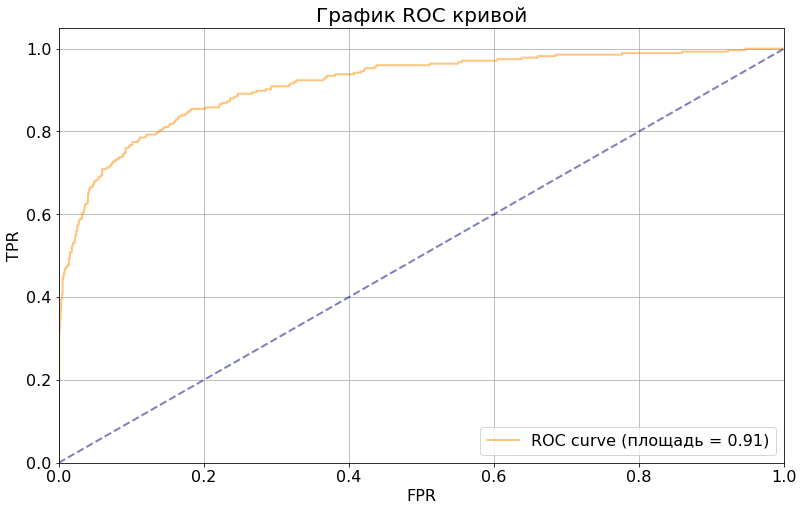

In [35]:
#создание ROC кривой

eval_pool = Pool(fea_test, tar_test, cat_features=cat_features)
curve = get_roc_curve(model2, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

plt.figure(figsize=(13, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (площадь = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.title('График ROC кривой', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


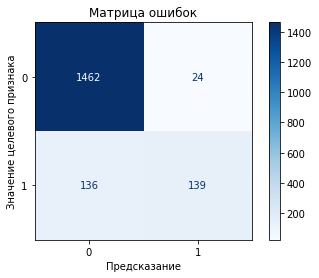

In [36]:
cm = get_confusion_matrix(model2, eval_pool)
color = 'black'
matrix = plot_confusion_matrix(model2, fea_test, tar_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Матрица ошибок', color=color)
plt.xlabel('Предсказание', color=color)
plt.ylabel('Значение целевого признака', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

По матрице можно сделать вывод, что модель почти с 50-ти процентой вероятностью правильно предскажет значение 1

In [37]:
#feature_importance

model2.get_feature_importance(prettified=True)

Feature Id  Importances
0            duration    49.448939
1                type     9.648008
2       total_charges     8.485033
3     monthly_charges     8.258673
4      payment_method     5.771314
5             partner     3.448153
6      multiple_lines     3.163809
7    internet_service     2.146193
8   device_protection     1.530082
9       online_backup     1.499876
10         dependents     1.126237
11  paperless_billing     1.111408
12   streaming_movies     1.055005
13     senior_citizen     0.945572
14       tech_support     0.724453
15       streaming_tv     0.654292
16             gender     0.492361
17    online_security     0.490592

Как заметно по матрице корреляции признаков, наибольшее влияние на целевой оказывает количество дней пользования услугами. 